In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') 
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy.stats
import figure_utils as fu
from return_gene_descriptions import return_gene_descriptions

/tmp/ipykernel_47358/1308656522.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
def get_cmap(n, name='Set3'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [3]:
df_species = pd.read_csv(f"/u/project/ngarud/Garud_lab/HumanizedMouse/merged_midas_output/species/relative_abundance.txt.bz2",sep="\t",index_col=0)

mnum = [f[:2] for f in df_species.columns]
msite = [f[2:].split("_")[0][:-1] for f in df_species.columns]
mdiet = [f[2:].split("_")[0][-1] for f in df_species.columns]
mhouse = []
for m in mnum:
    if m == "M1" or m == "M2" or m == "M3":
        mhouse.append("C1")
    elif m == "M4" or m =="M5":
        mhouse.append("C2")
    else:
        mhouse.append("C3")
    
df_species = df_species.T
df_species["mouse_number"] = mnum
df_species.set_index('mouse_number', append=True, inplace=True)
df_species["region"] = msite
df_species.set_index('region', append=True, inplace=True)
df_species["diet"] = mdiet
df_species.set_index('diet', append=True, inplace=True)
df_species["cohouse"] = mhouse
df_species.set_index('cohouse', append=True, inplace=True)

df_species.index.names = ["sample","mouse_number","region","diet","cohouse"]
df_species = df_species.reorder_levels(["cohouse","mouse_number","region","diet","sample"])
df_species = df_species.sort_index(level="mouse_number")


In [19]:
mnum_sample_dic = {m:np.argwhere(df_species.sort_index(level="mouse_number").index.get_level_values("mouse_number") == m).ravel() for m in list(set(mnum))}

msite_sample_dic = {m:np.argwhere(df_species.sort_index(level="region").index.get_level_values("region") == m).ravel() for m in list(set(msite))}

mdiet_sample_dic = {m:np.argwhere(df_species.sort_index(level="diet").index.get_level_values("diet") == m).ravel() for m in list(set(mdiet))}

mhouse_sample_dic = {m:np.argwhere(df_species.sort_index(level="cohouse").index.get_level_values("cohouse") == m).ravel() for m in list(set(mhouse))}


all_sample_dics = {"diet":mdiet_sample_dic,"region":msite_sample_dic,"mouse_number":mnum_sample_dic,"cohouse":mhouse_sample_dic}


In [20]:
df_species.mean().sort_values(ascending=False)[:20]

species_id
Blautia_producta_56315                73.554813
Akkermansia_muciniphila_55290         55.577488
Roseburia_intestinalis_56239          49.899845
Bacteroides_cellulosilyticus_58046    38.075624
Enterococcus_faecium_56947            29.626550
Blautia_wexlerae_56130                21.177071
Lactobacillus_acidophilus_51143       20.944308
Parabacteroides_distasonis_56985      19.552990
Bacteroides_ovatus_58035              17.134644
Burkholderiales_bacterium_56577       15.385846
Ruminococcus_sp_58571                 11.849621
Coprococcus_sp_62244                  11.374056
Adlercreutzia_equolifaciens_60310     11.265917
Collinsella_sp_62205                  10.533417
Bacteroides_vulgatus_57955             8.997378
Collinsella_aerofaciens_61484          8.602668
Anaerostipes_hadrus_55206              7.445555
Bacteroides_uniformis_57318            6.434365
Bifidobacterium_animalis_58116         5.491507
Clostridiales_bacterium_52743          4.867179
dtype: float64

/tmp/ipykernel_102476/3546059902.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(2,2,figsize=(32,16))


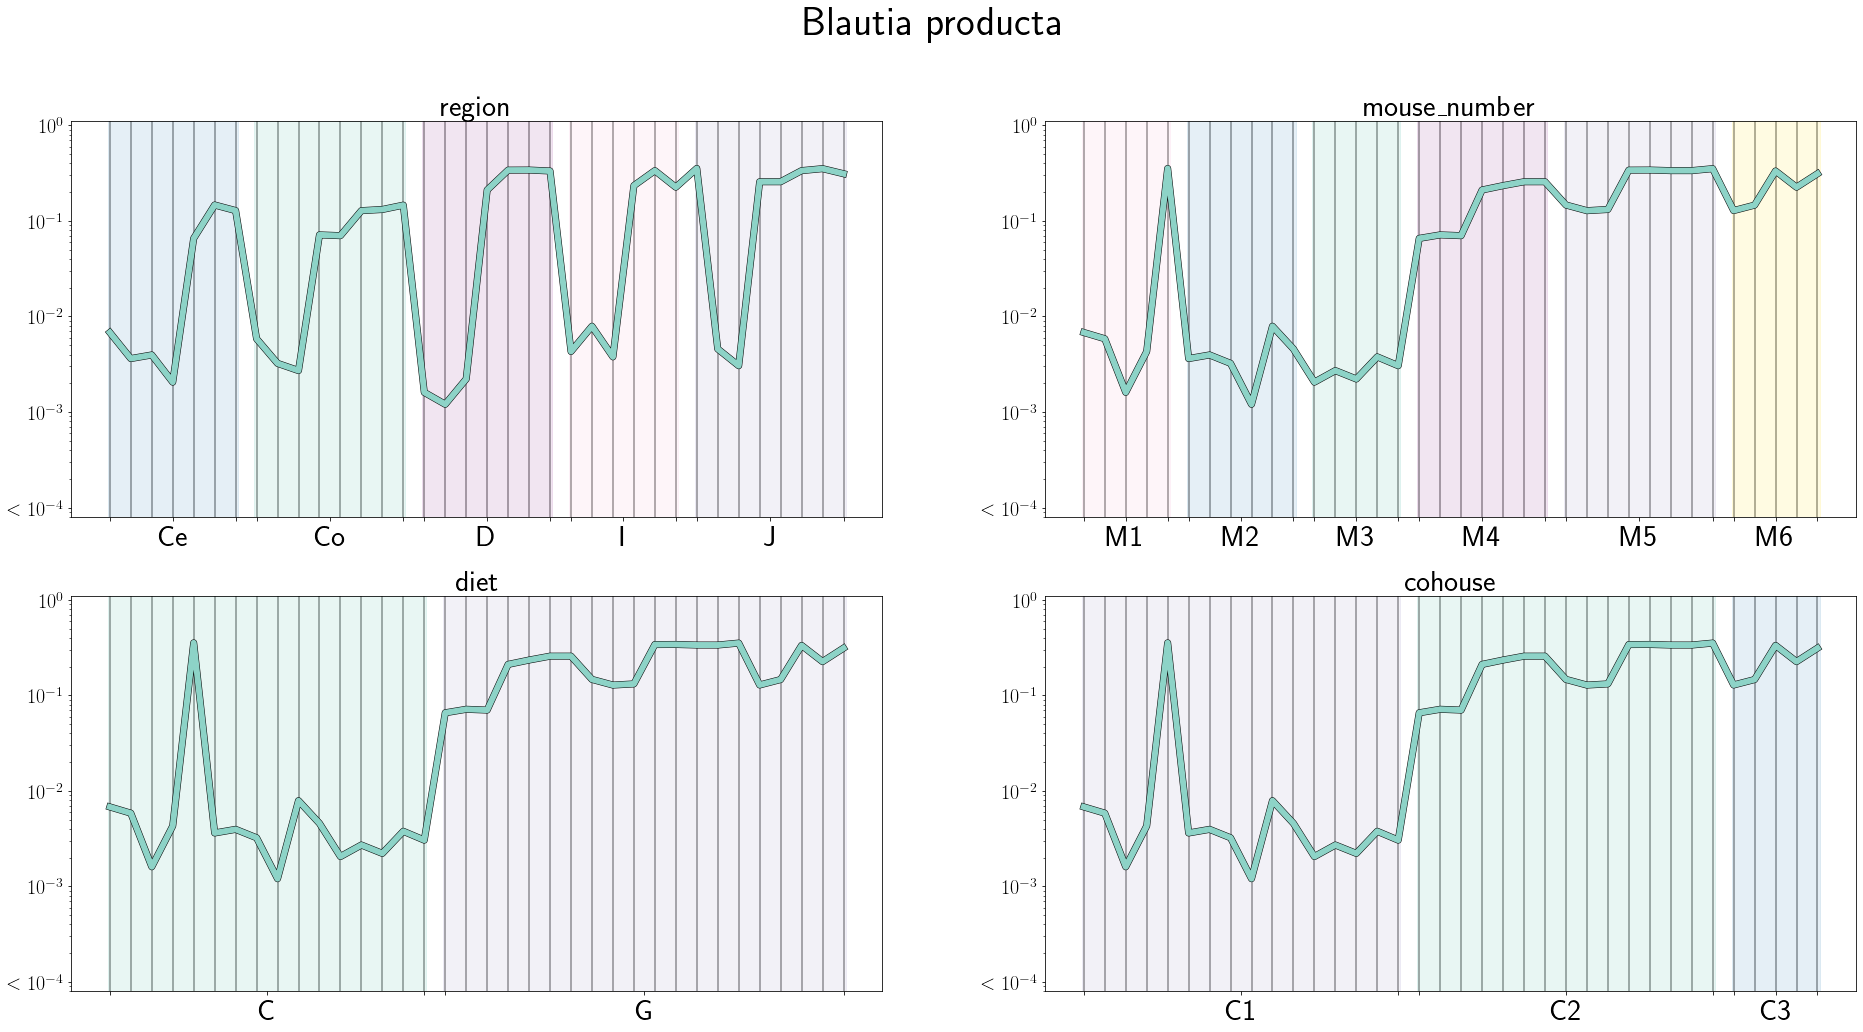

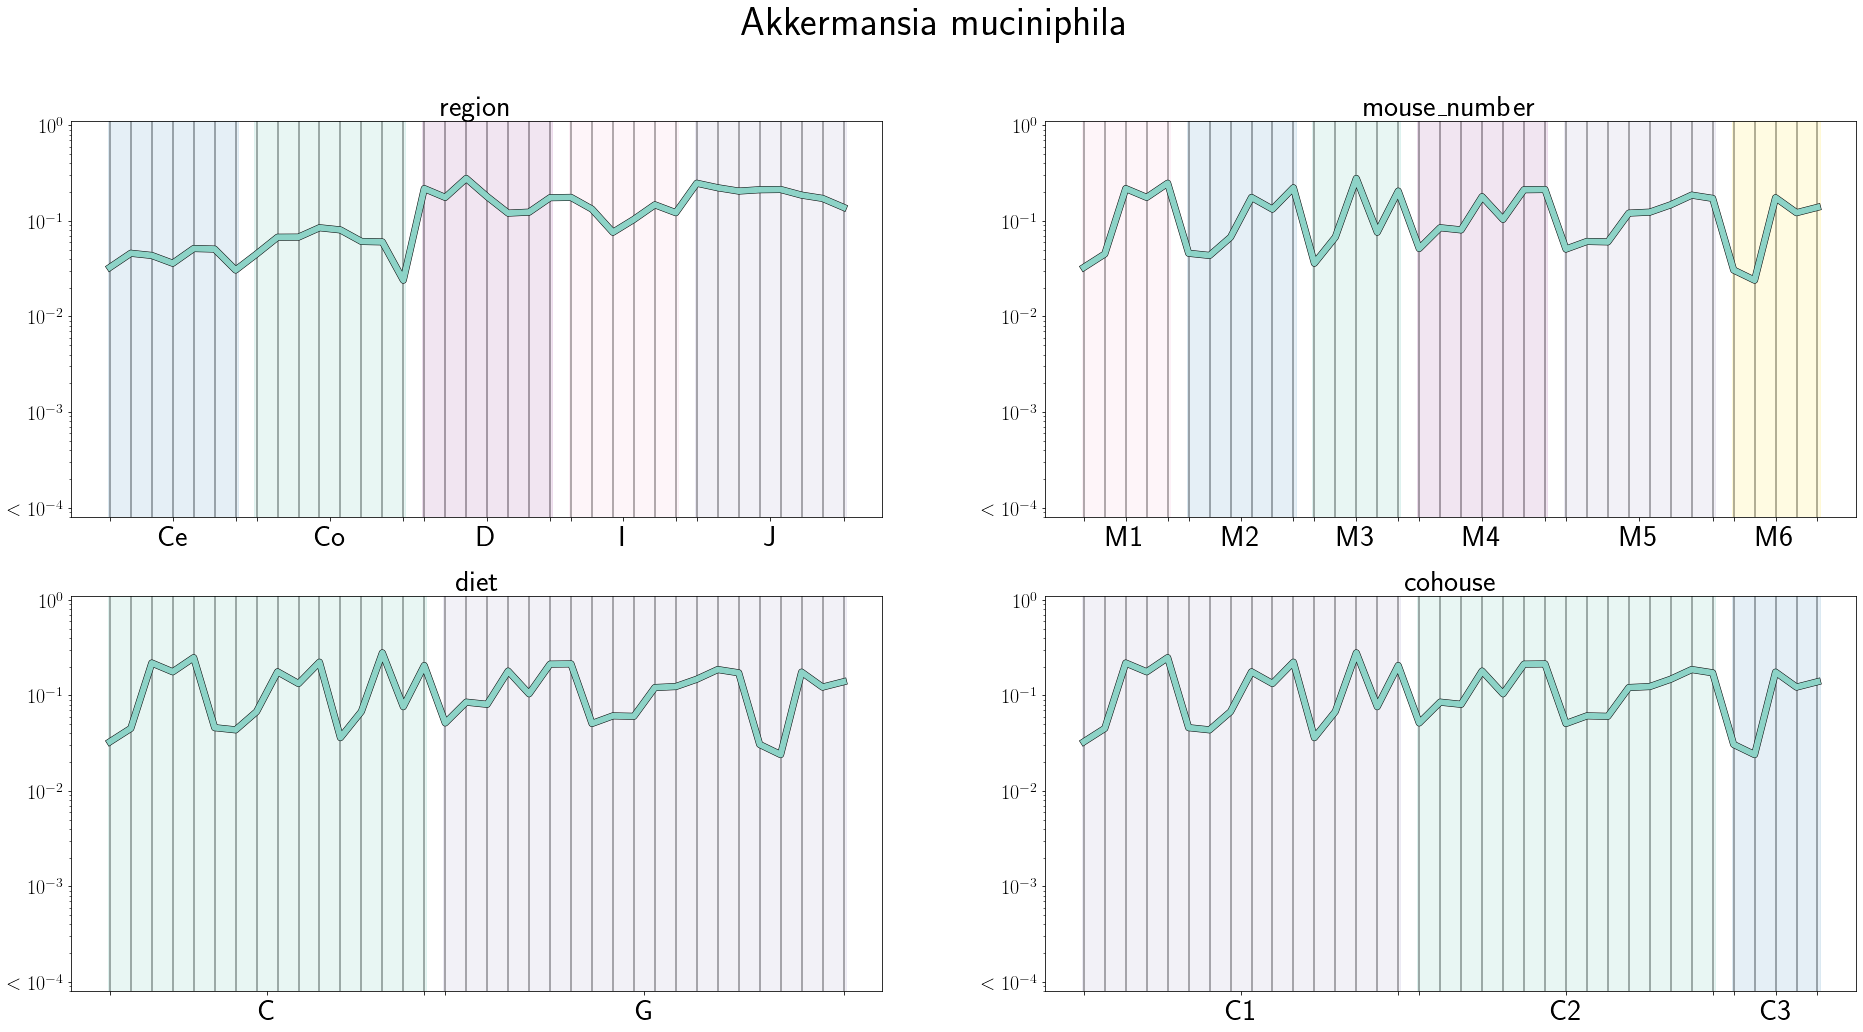

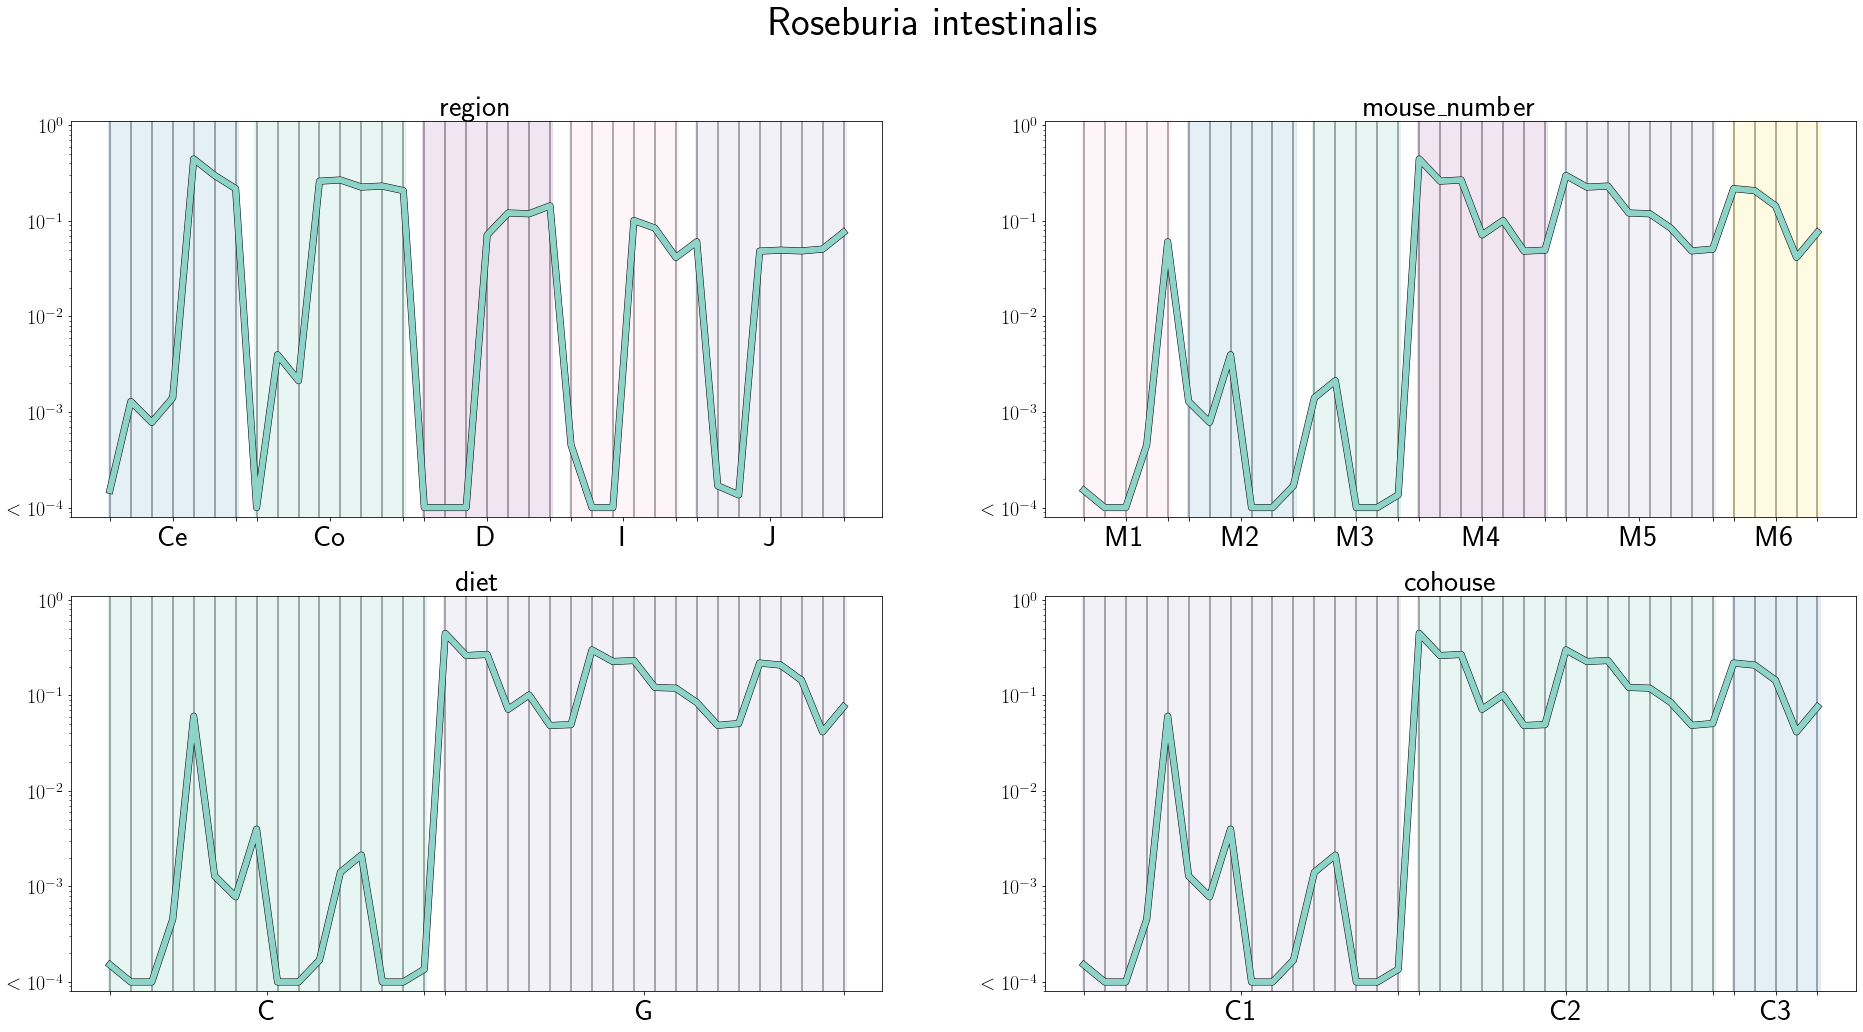

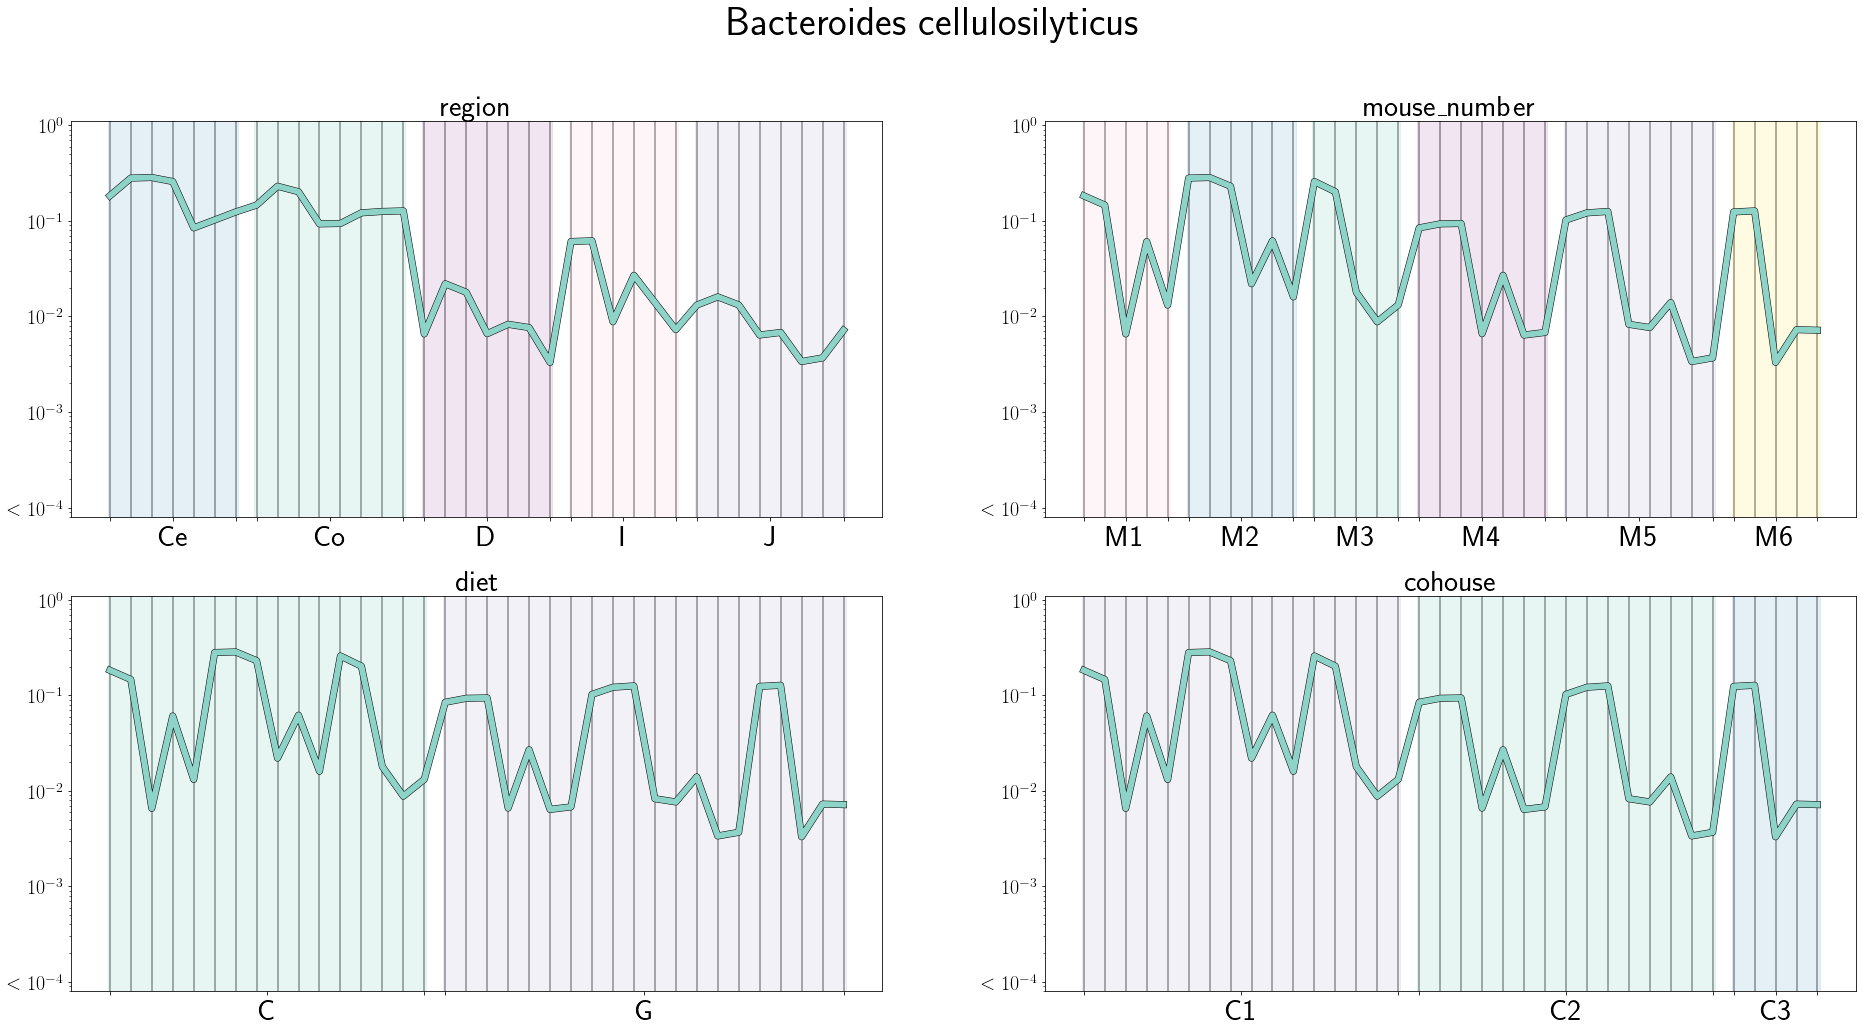

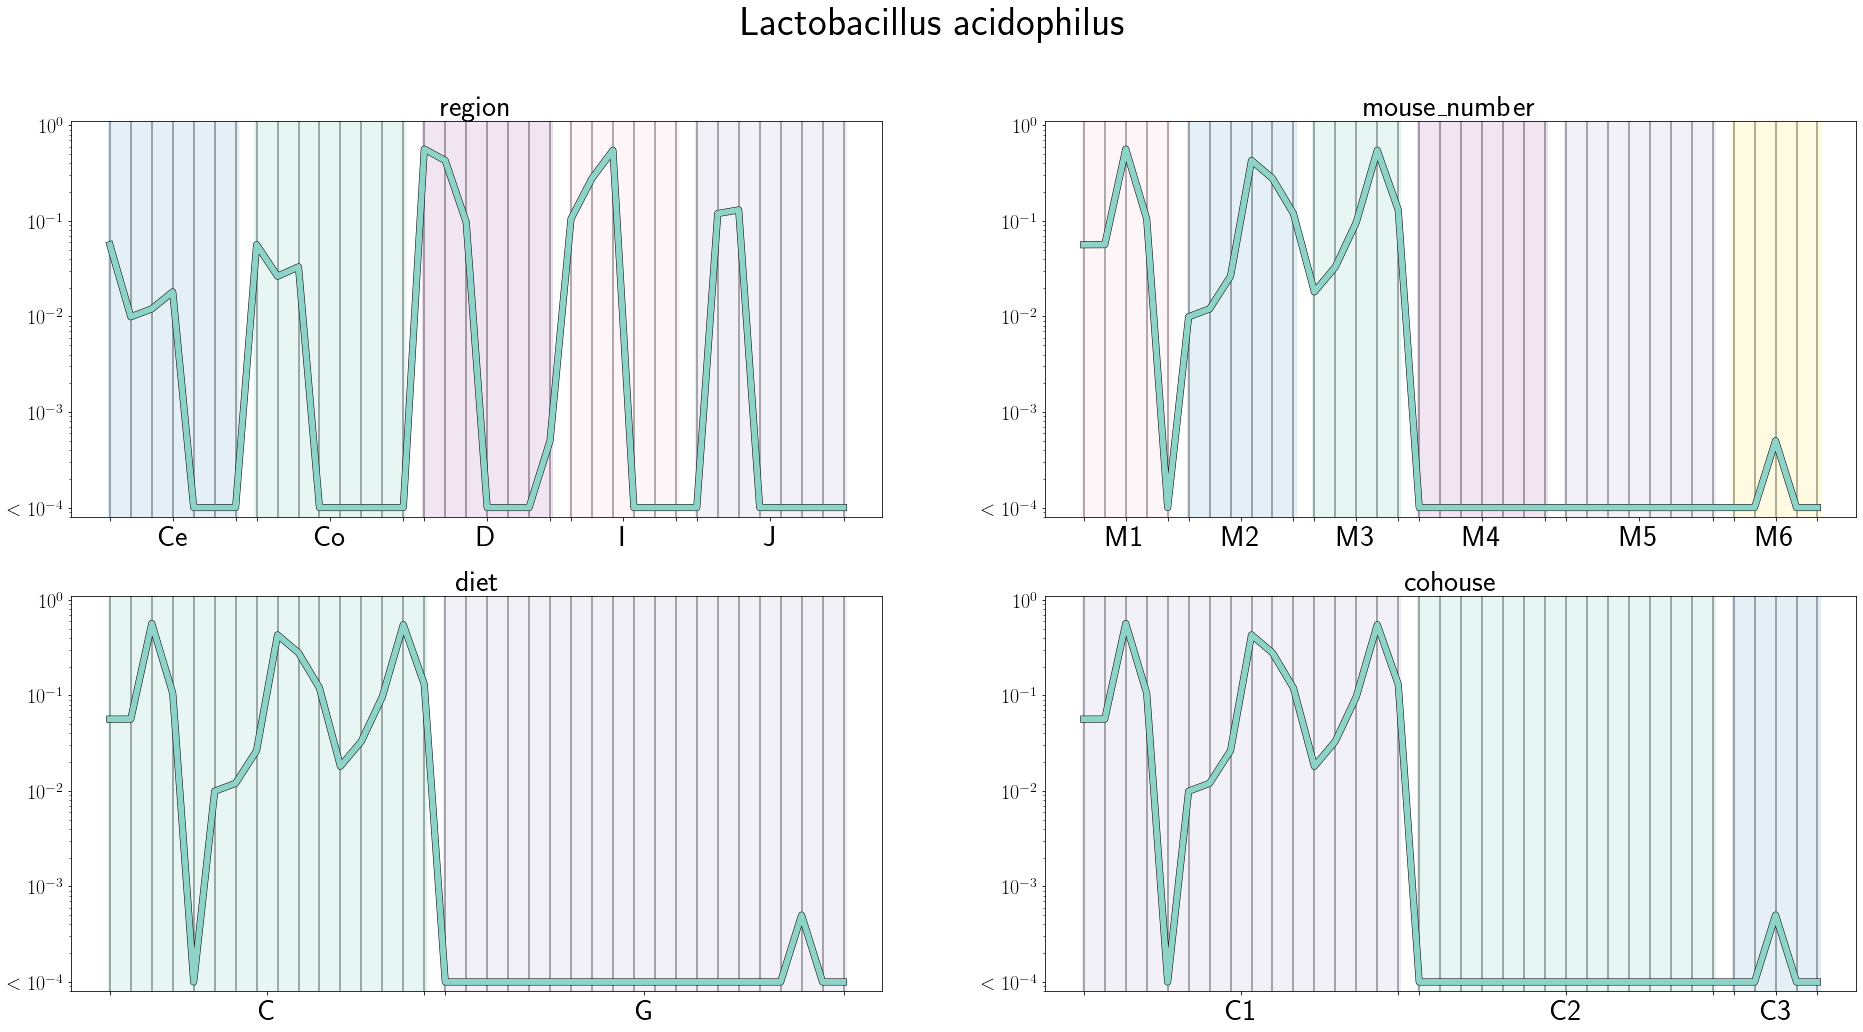

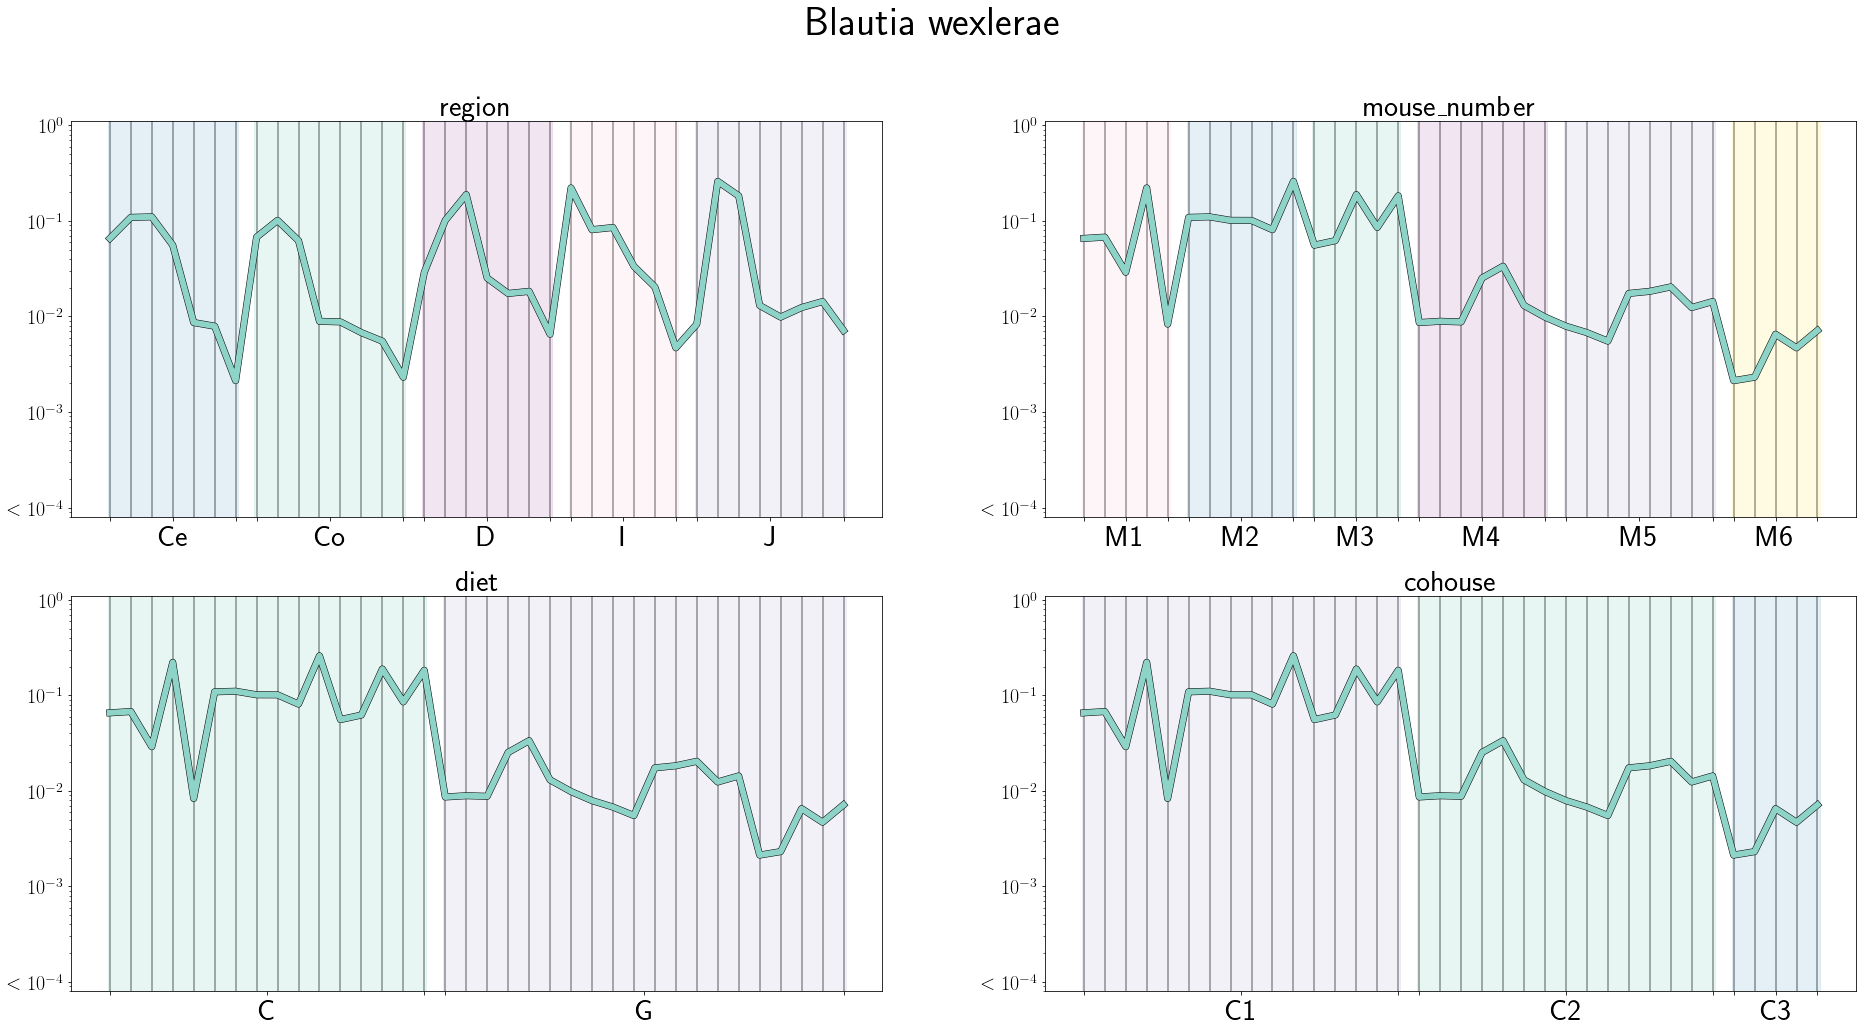

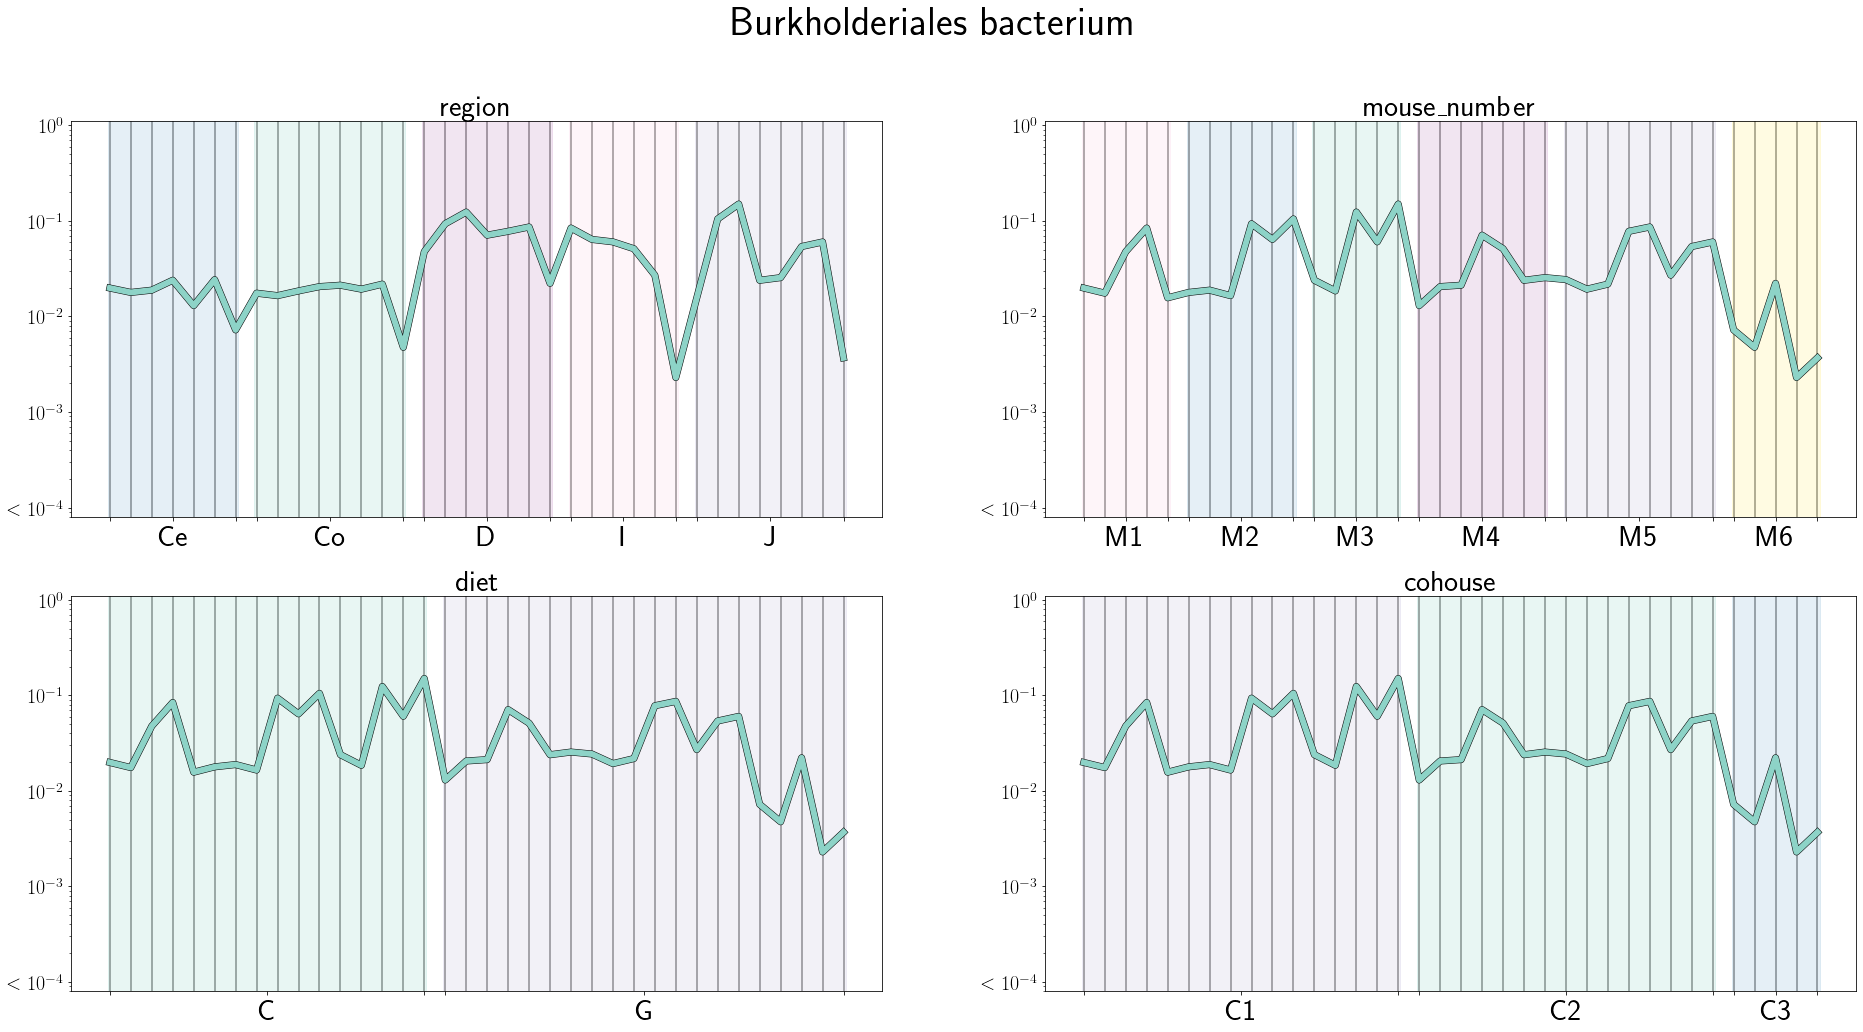

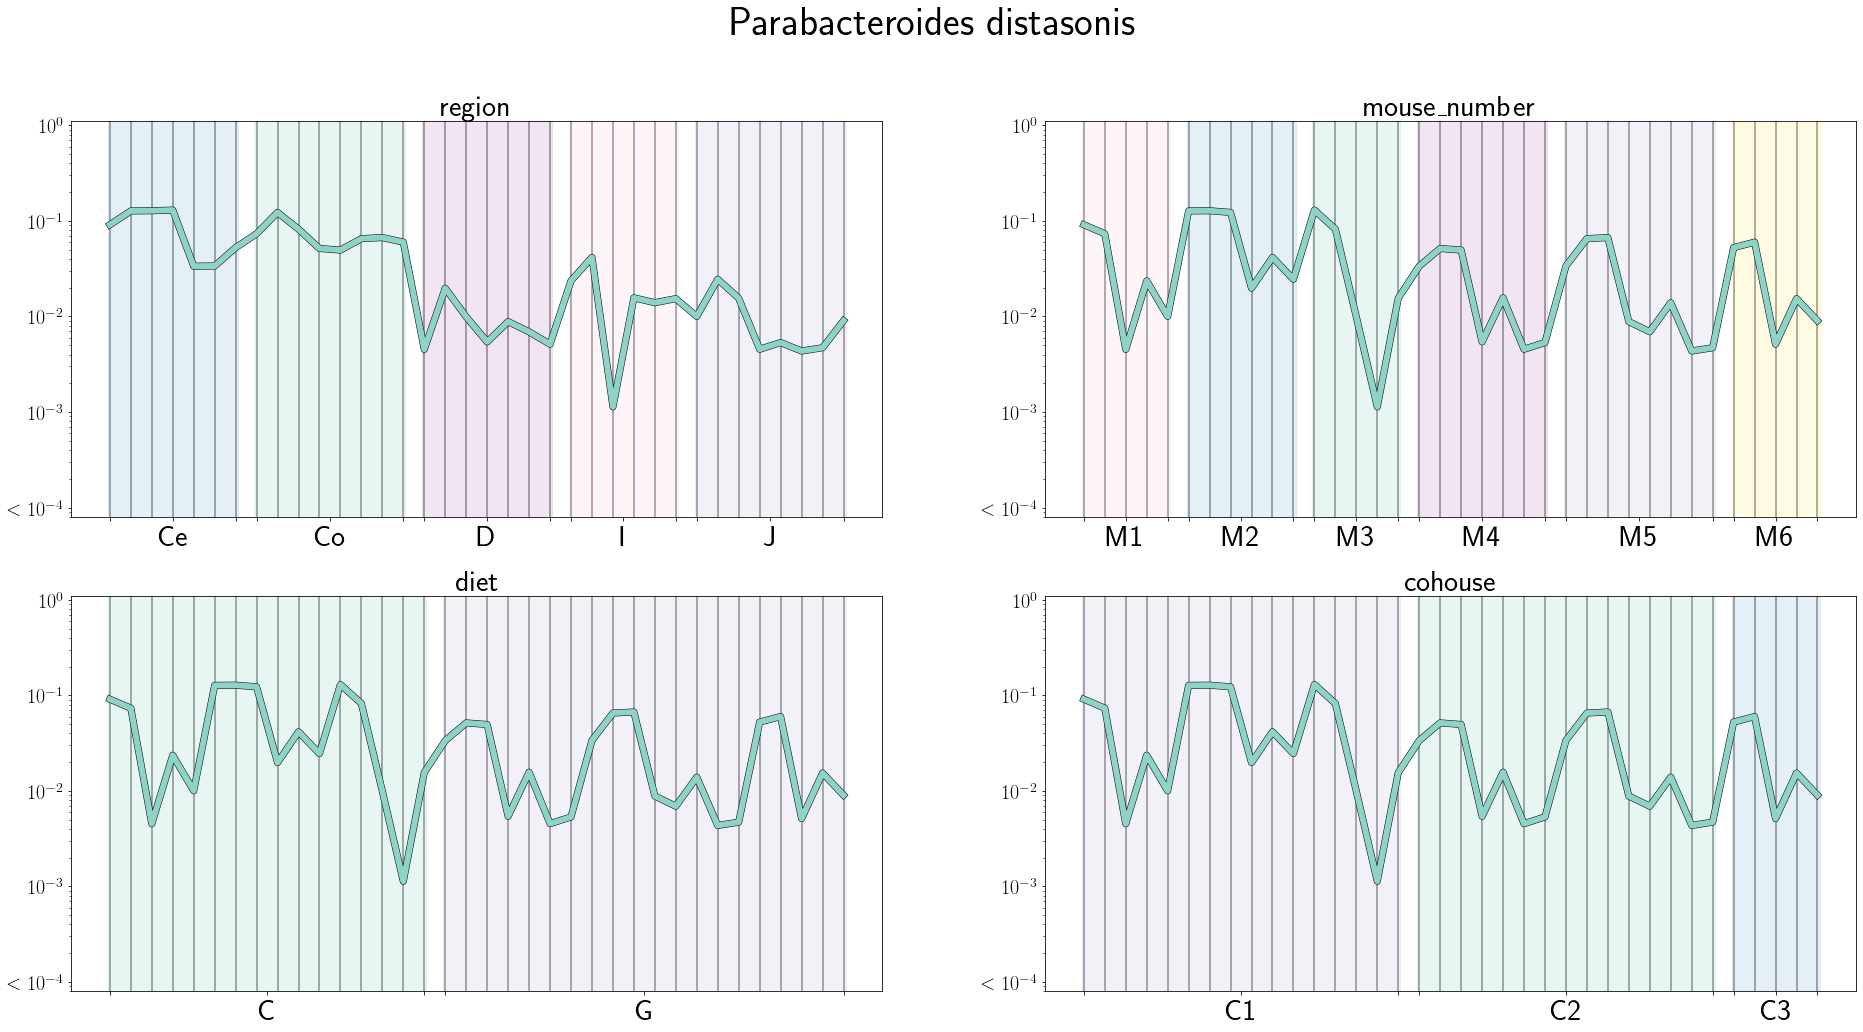

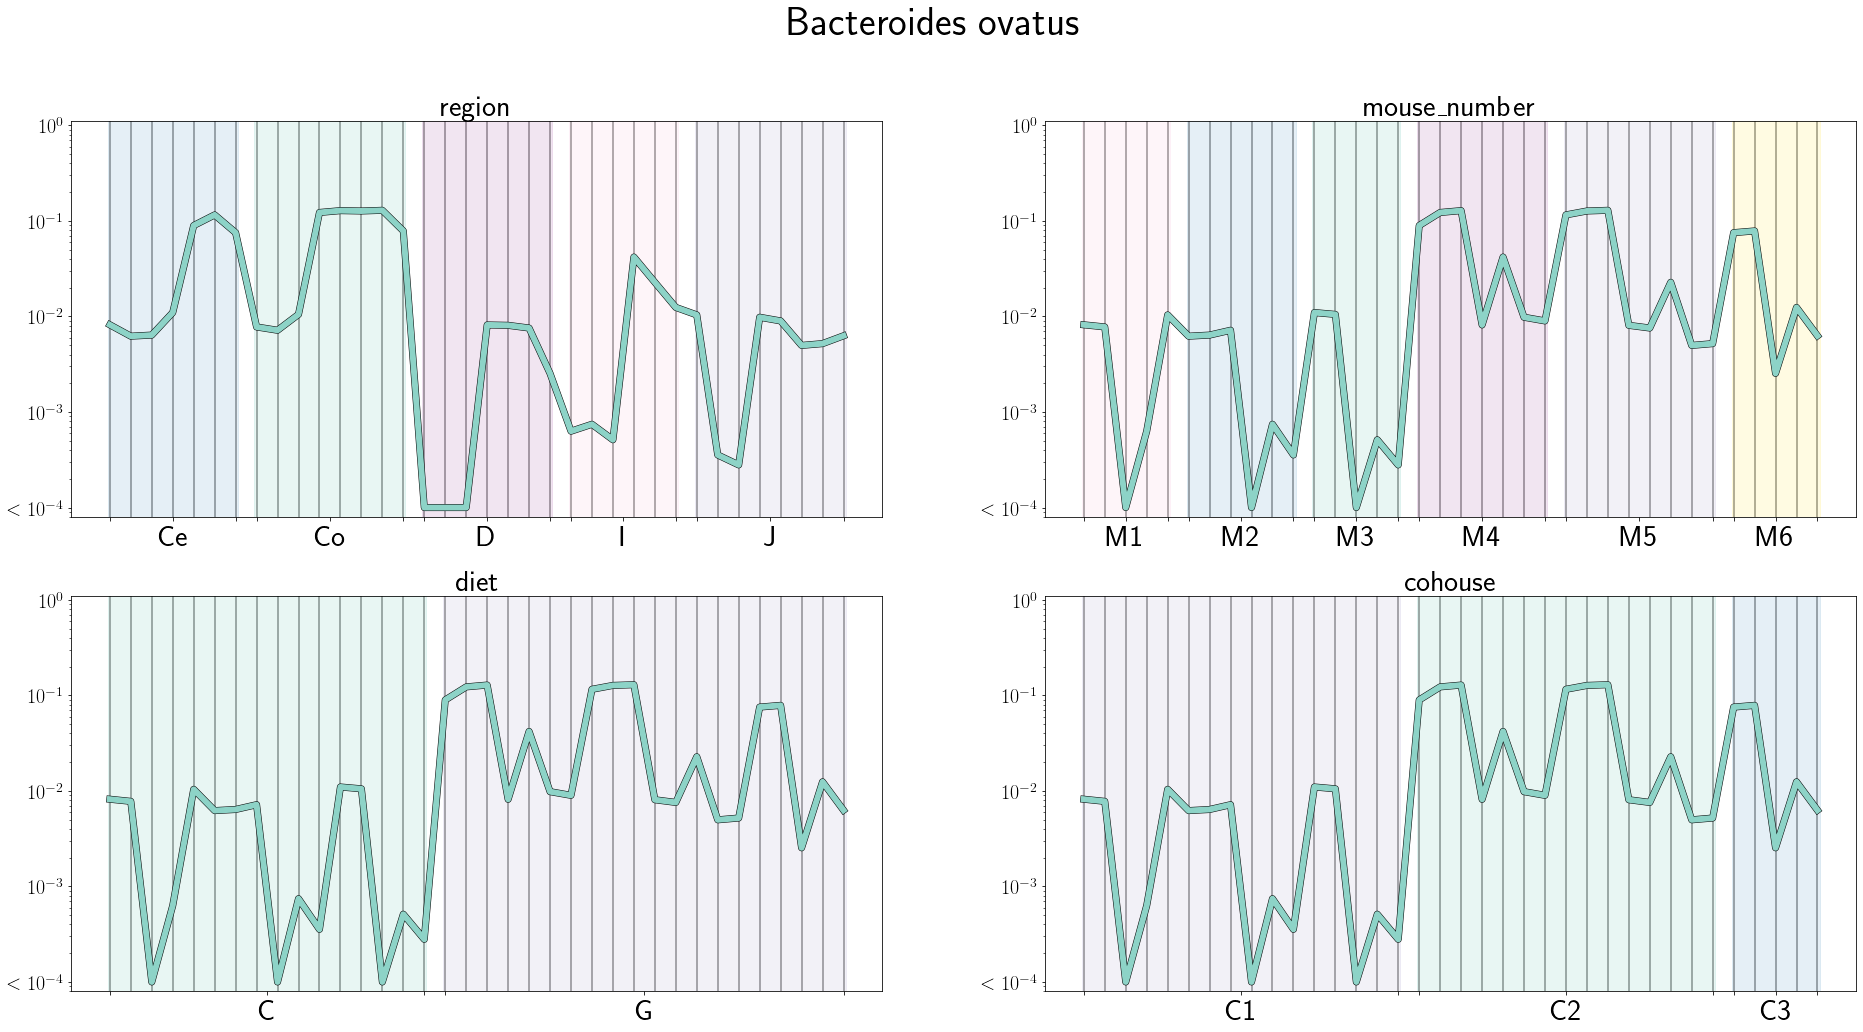

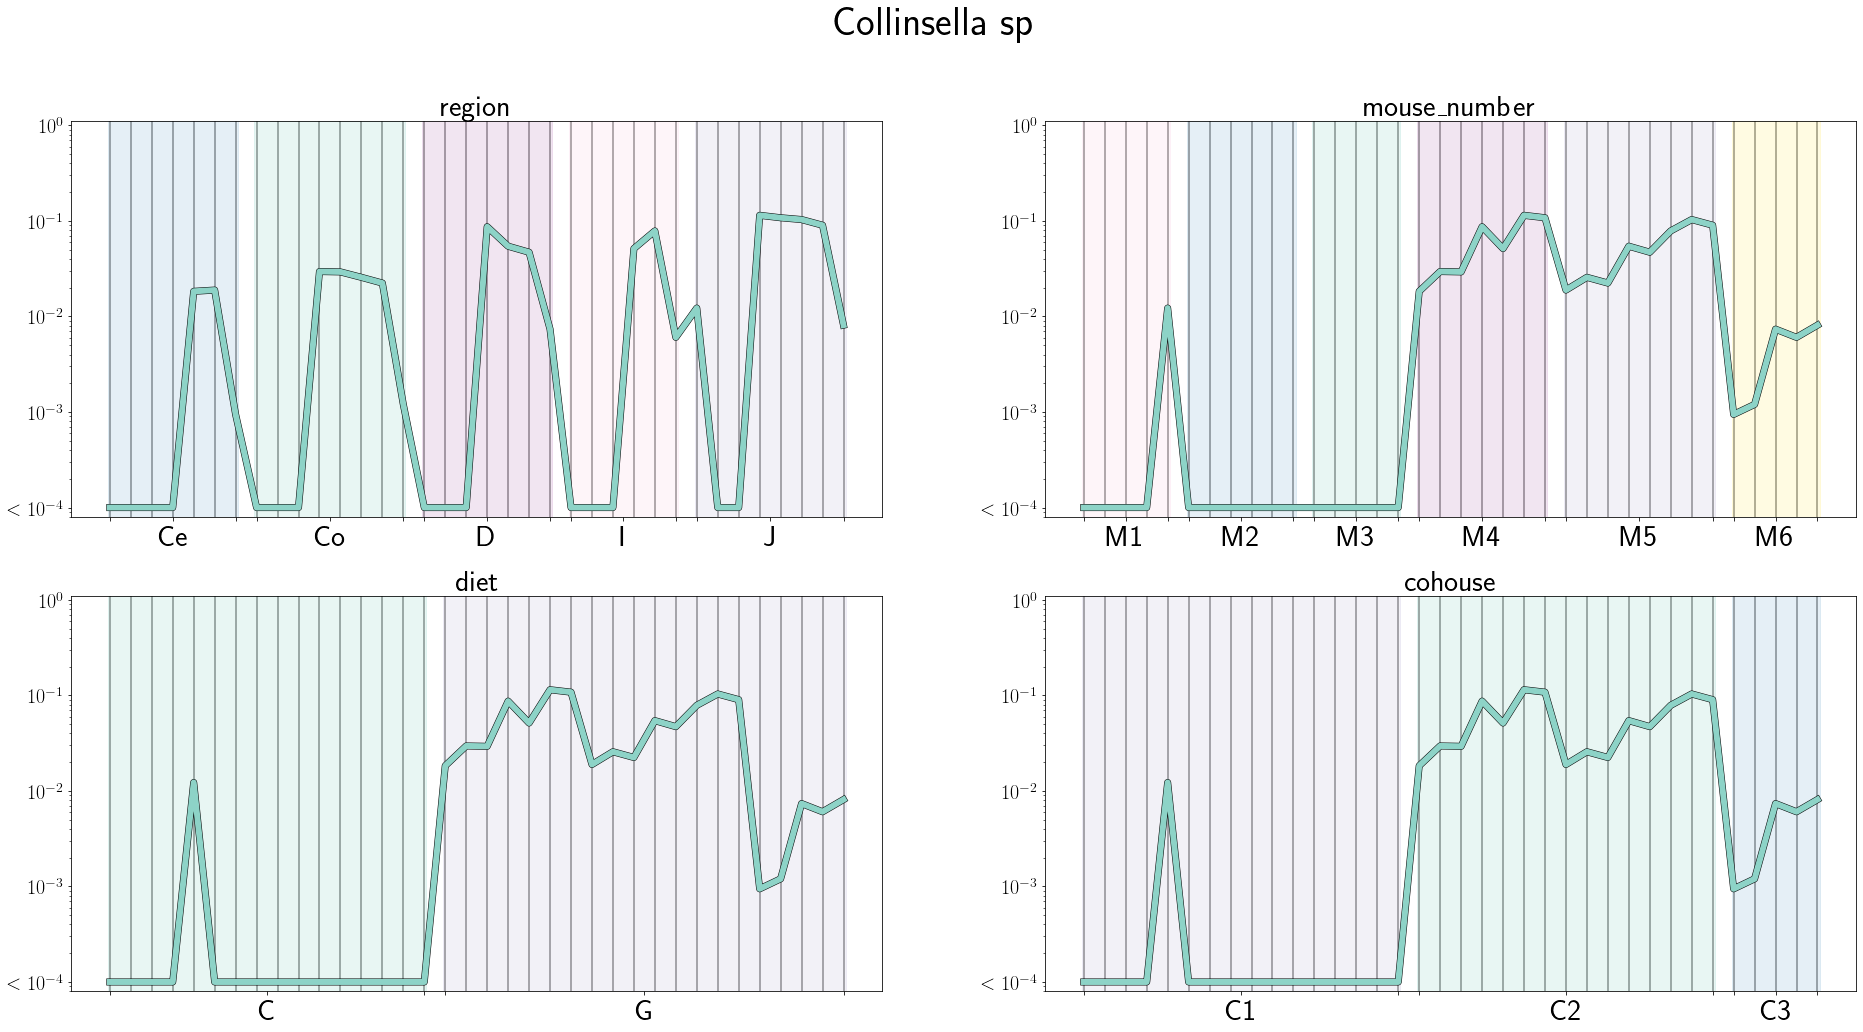

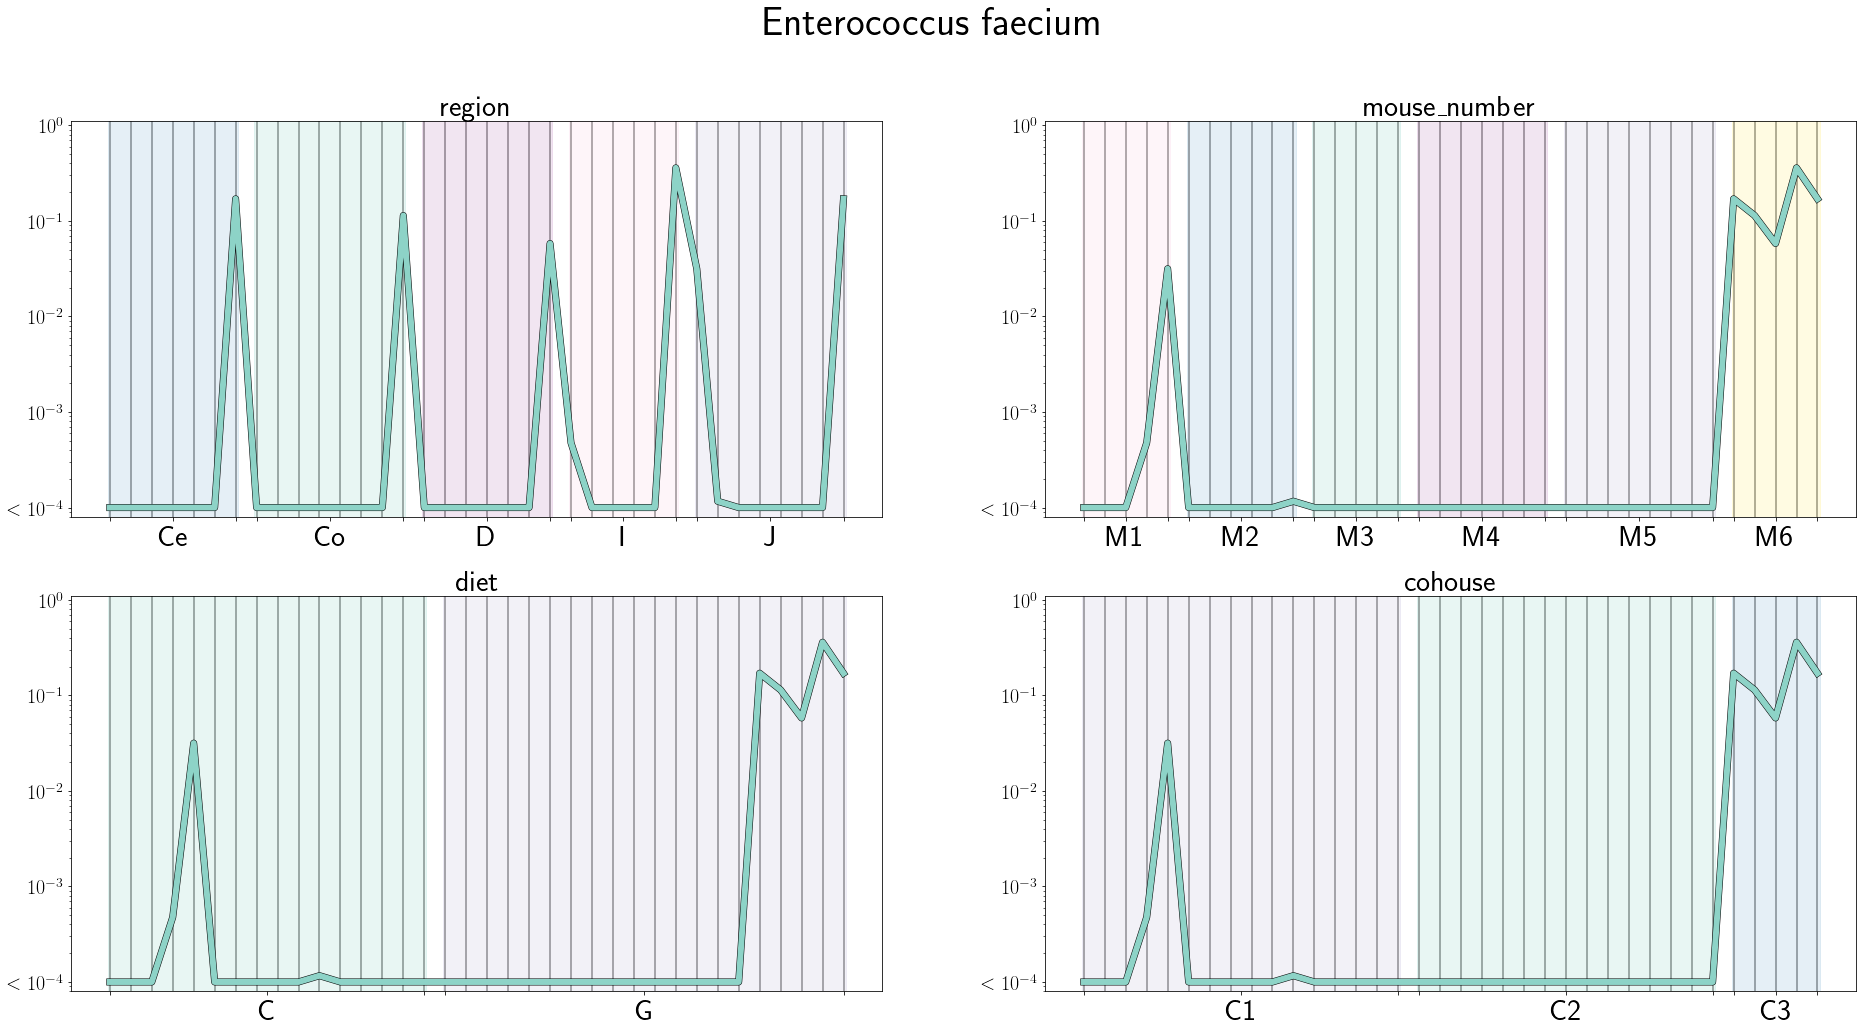

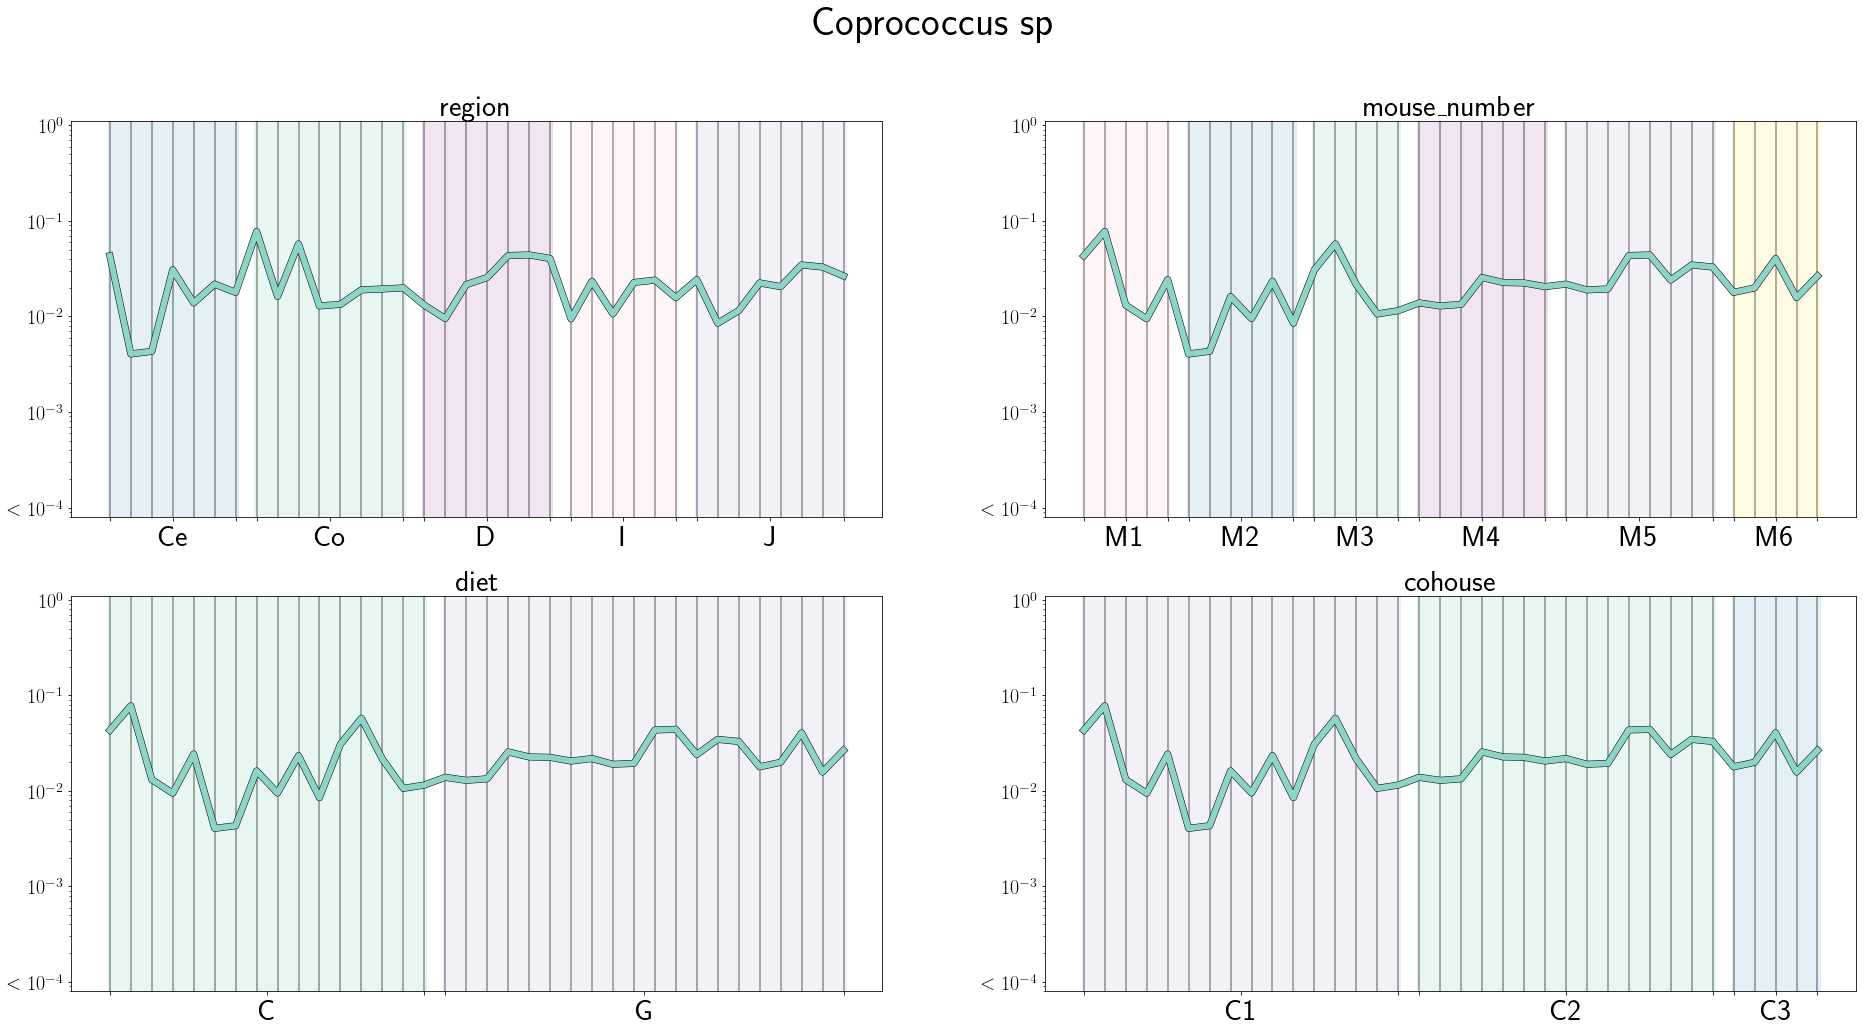

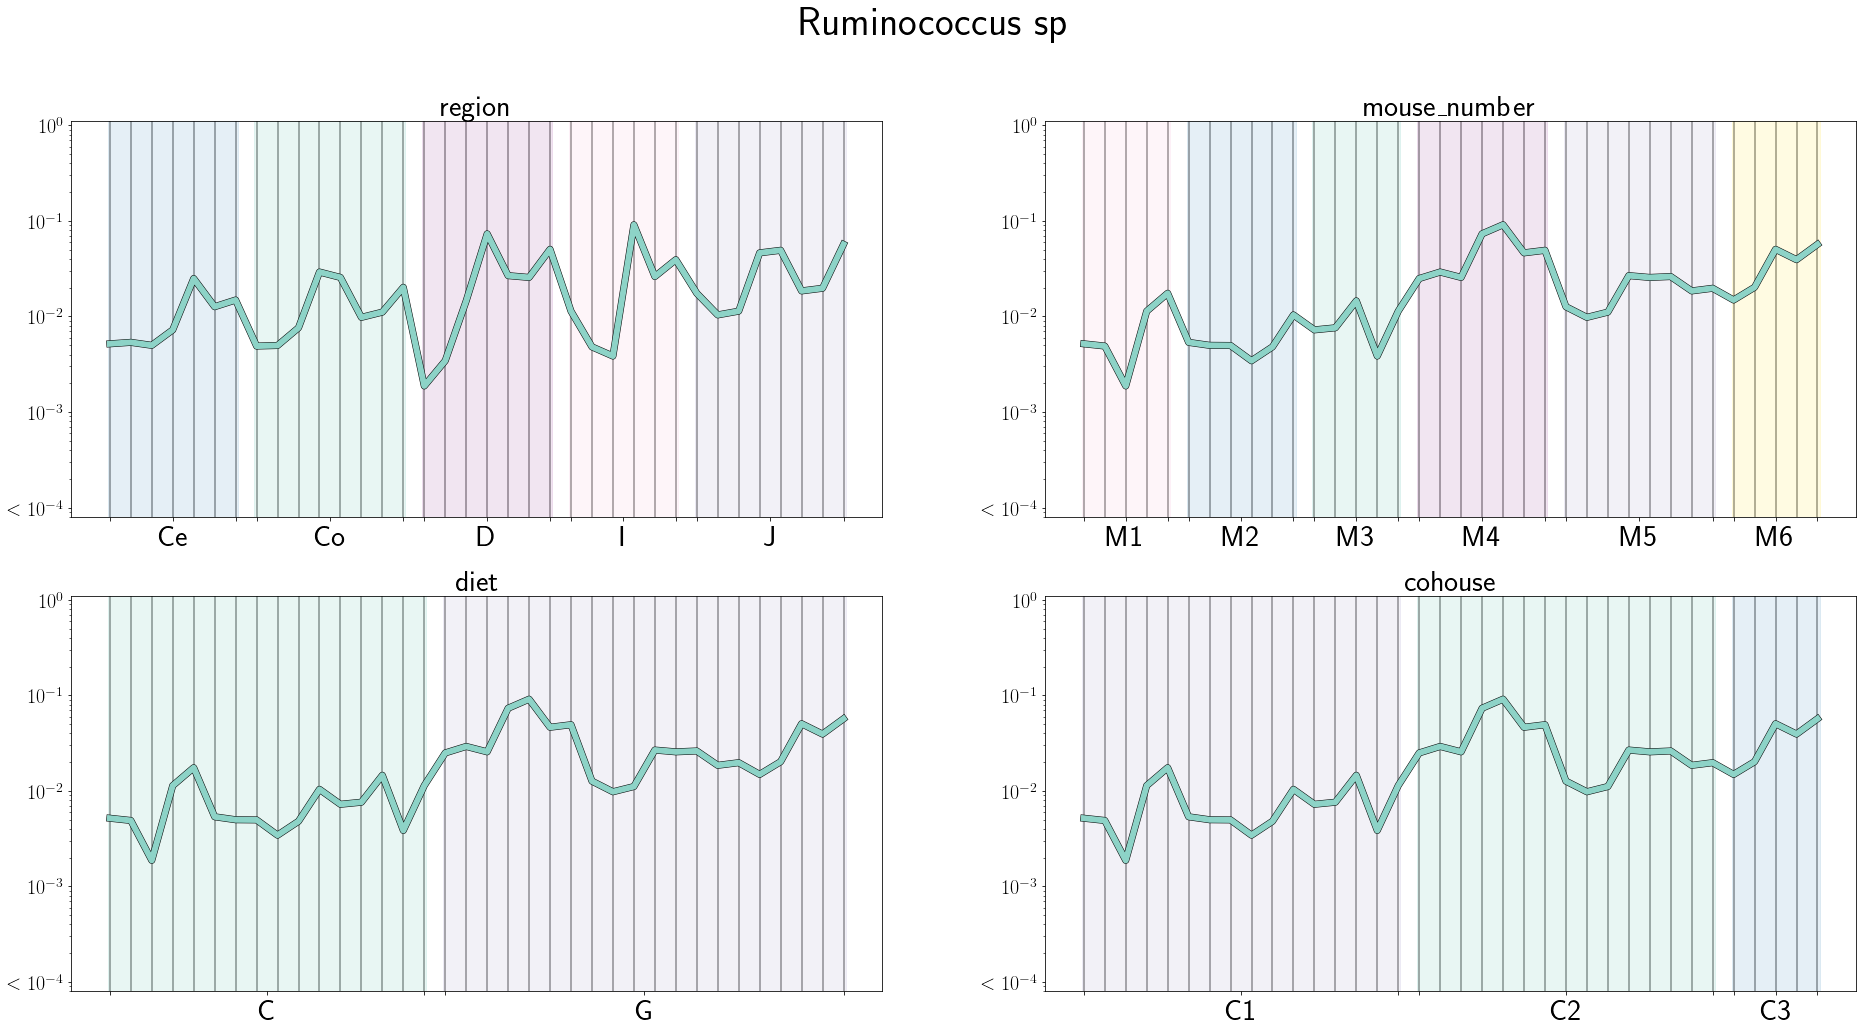

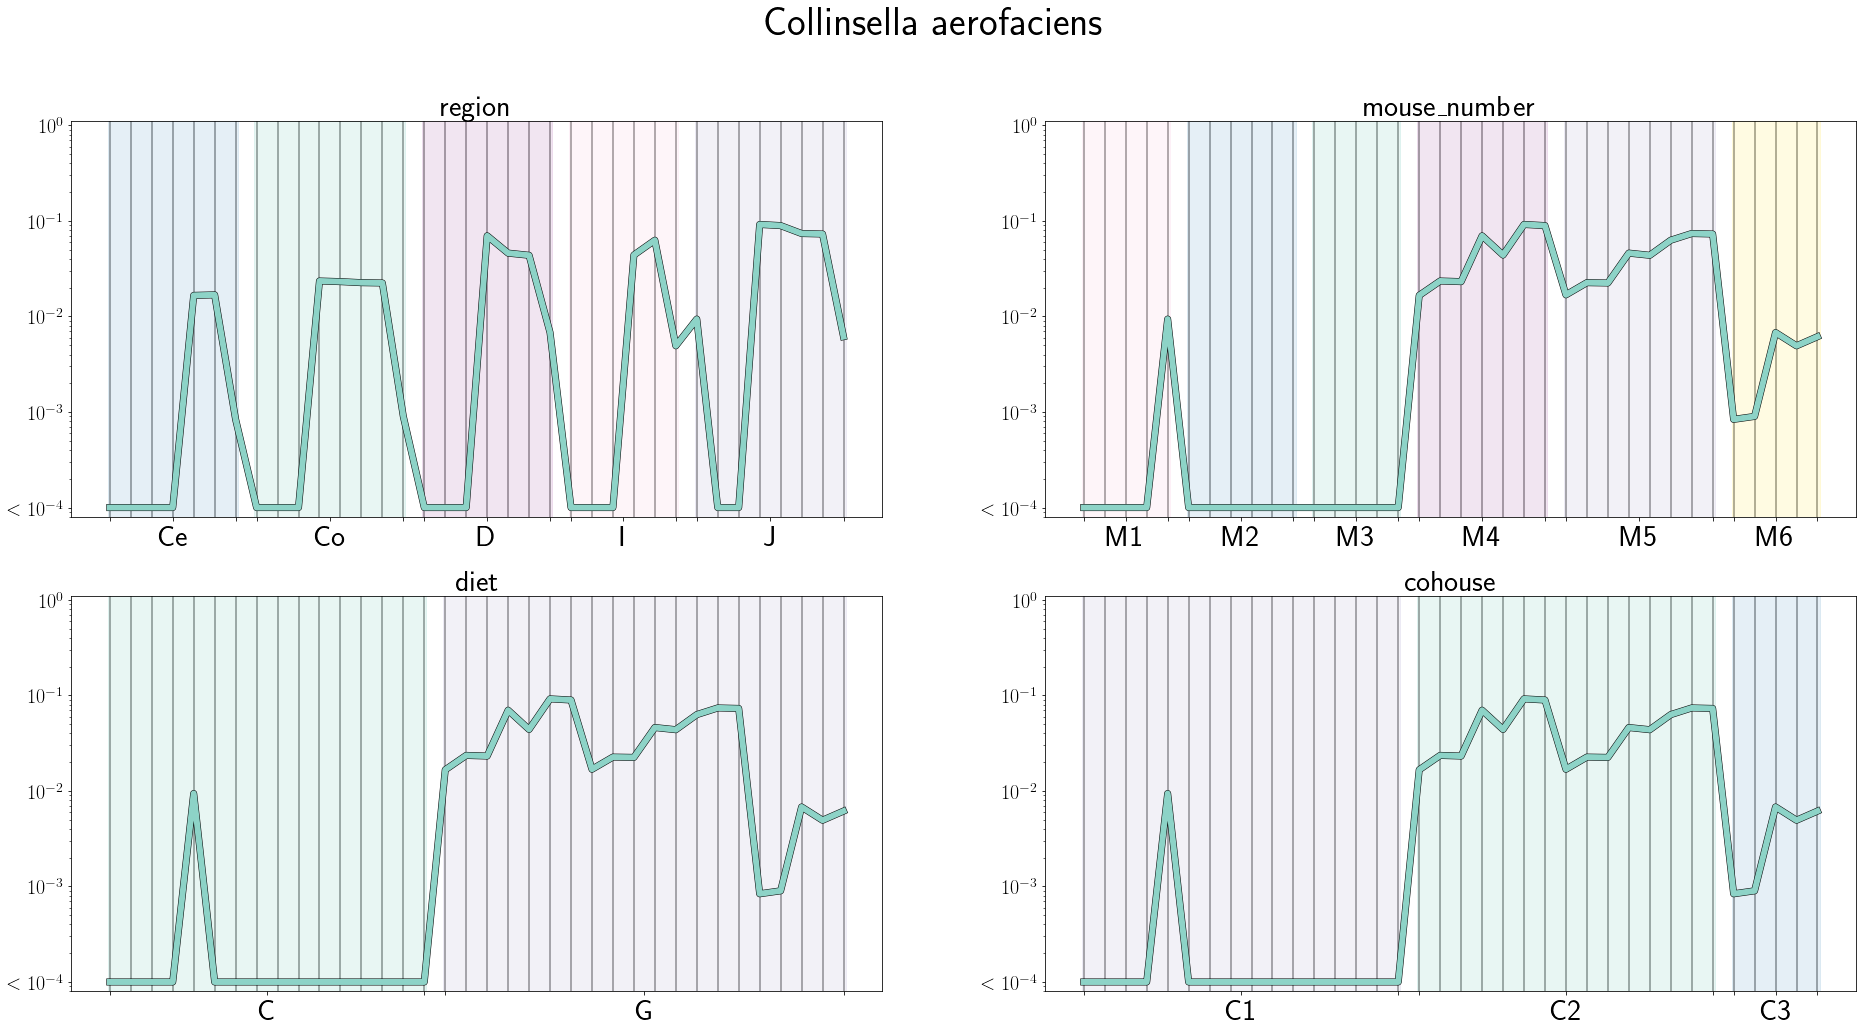

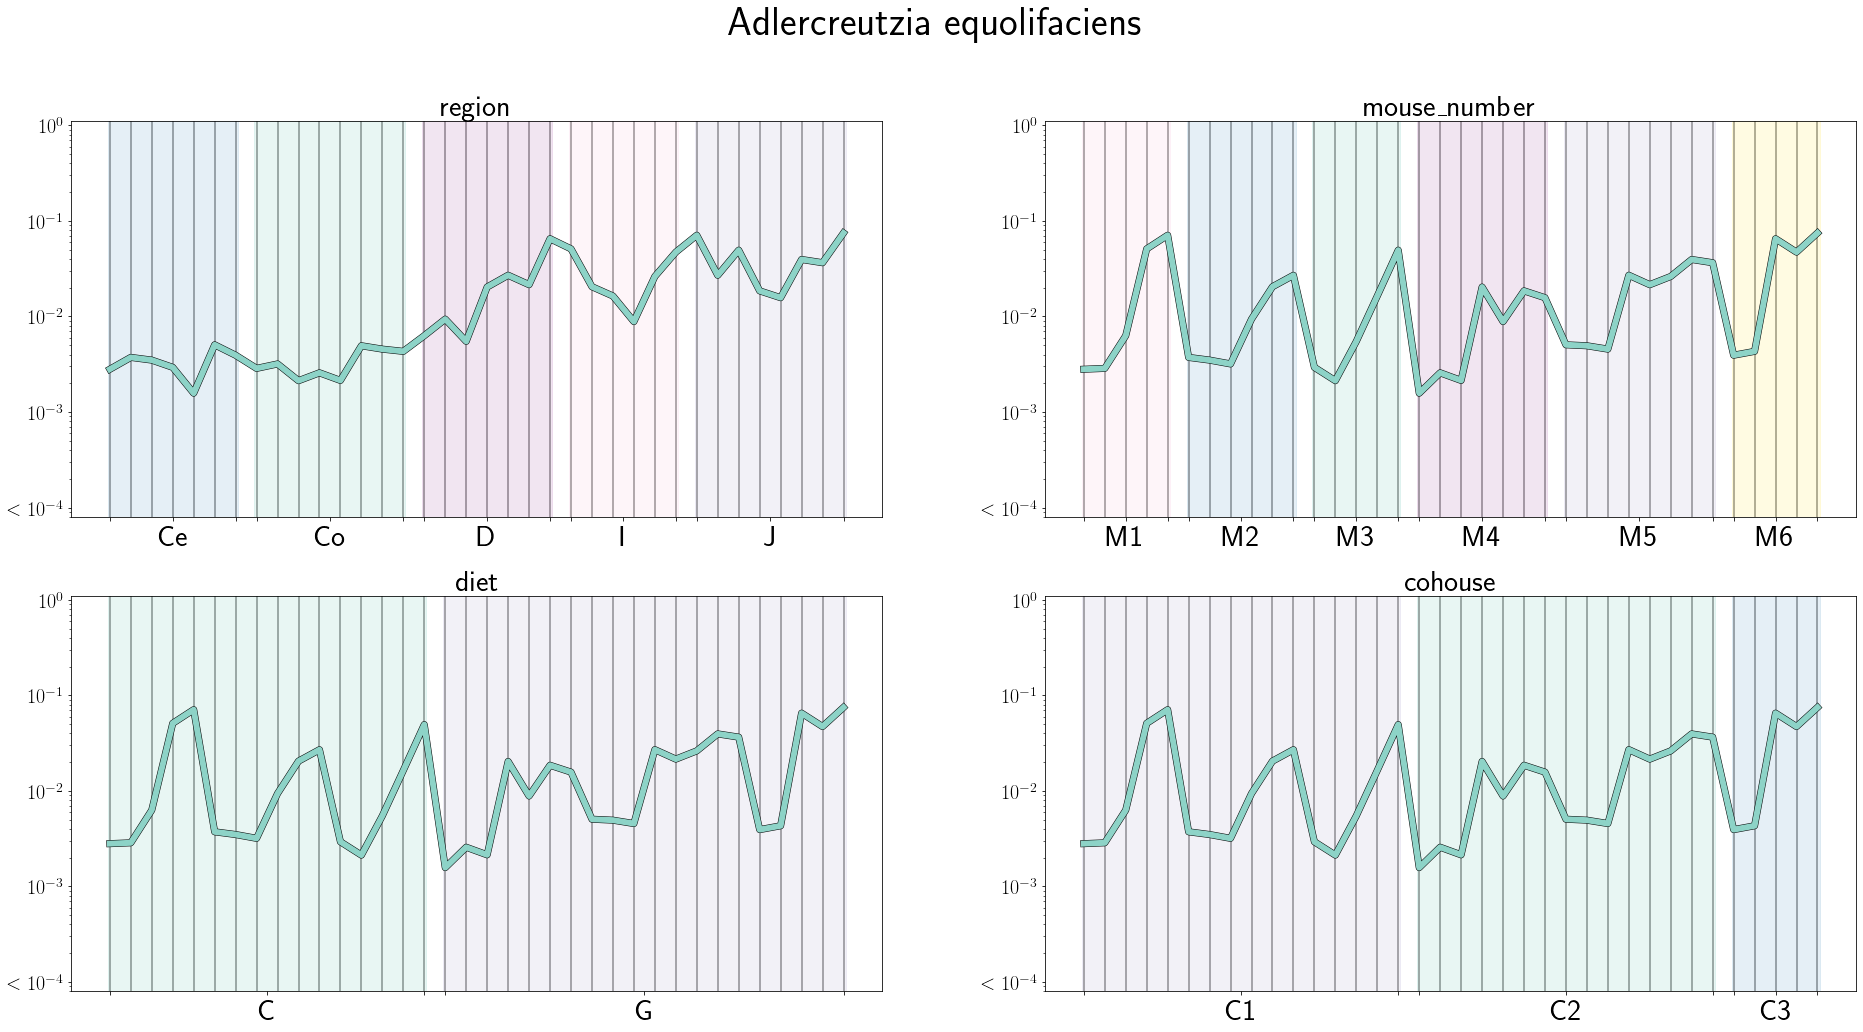

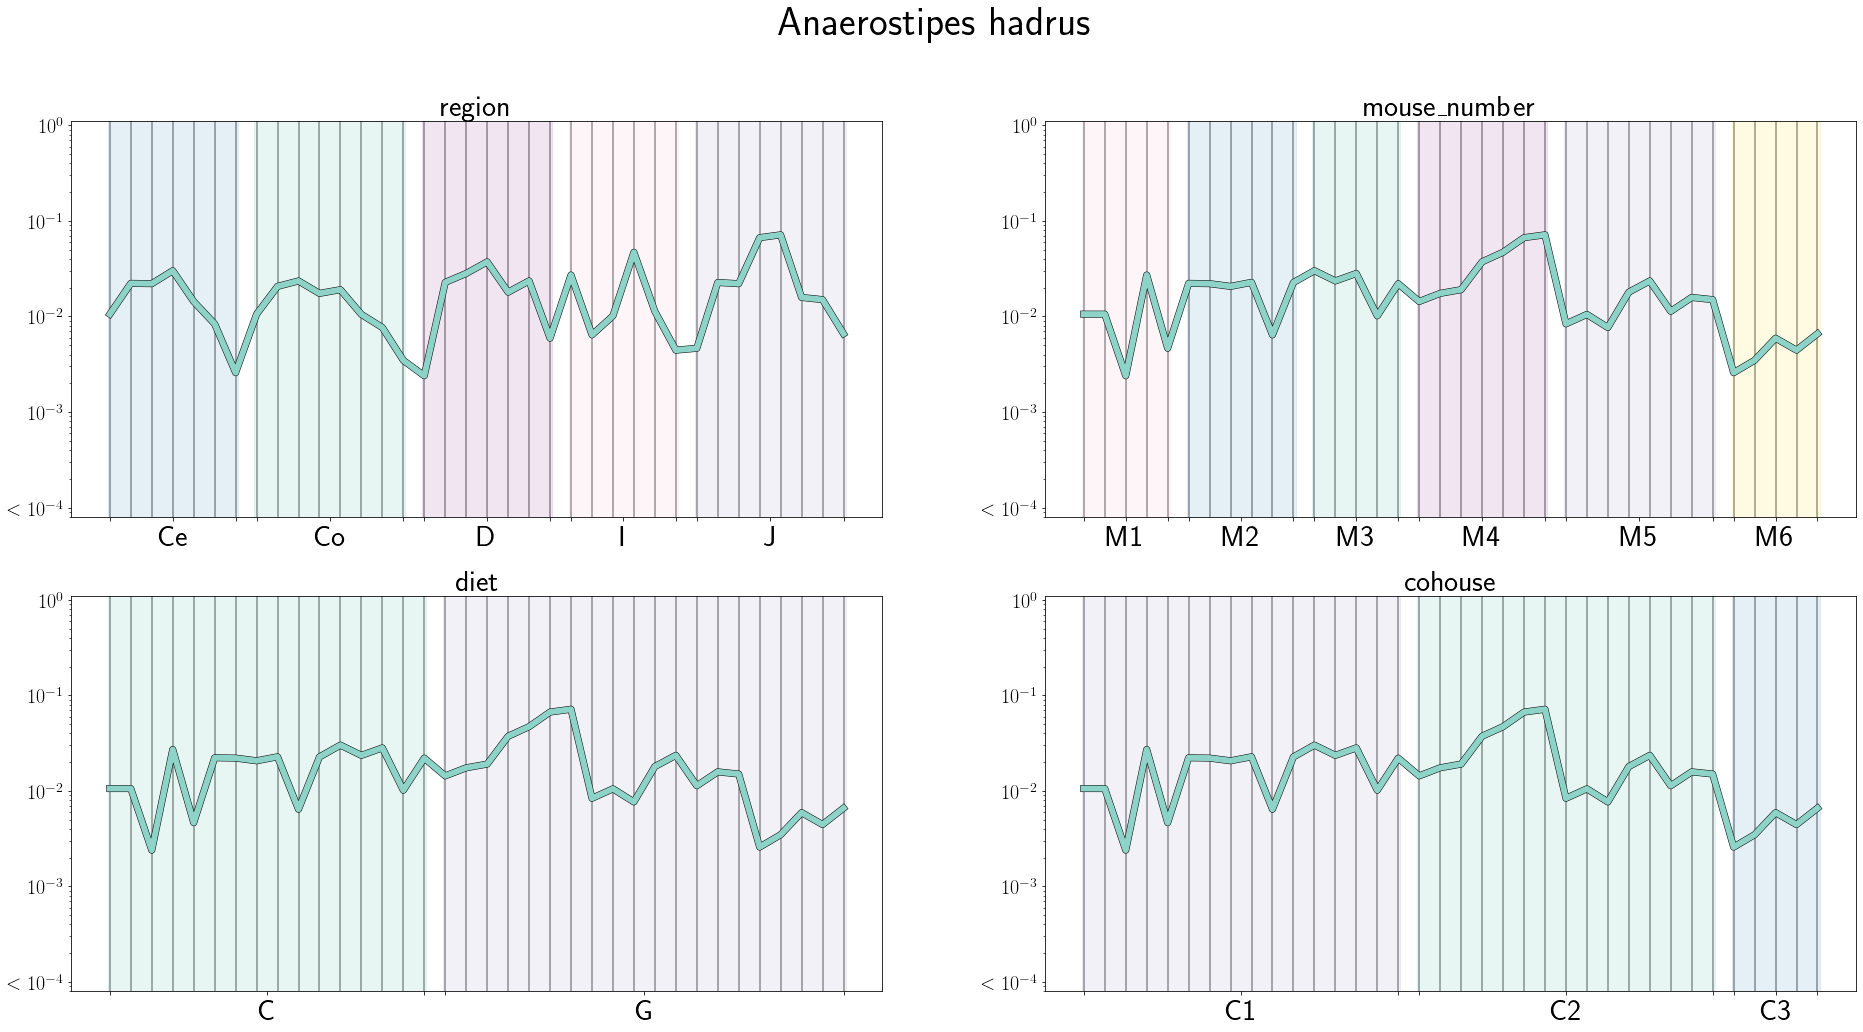

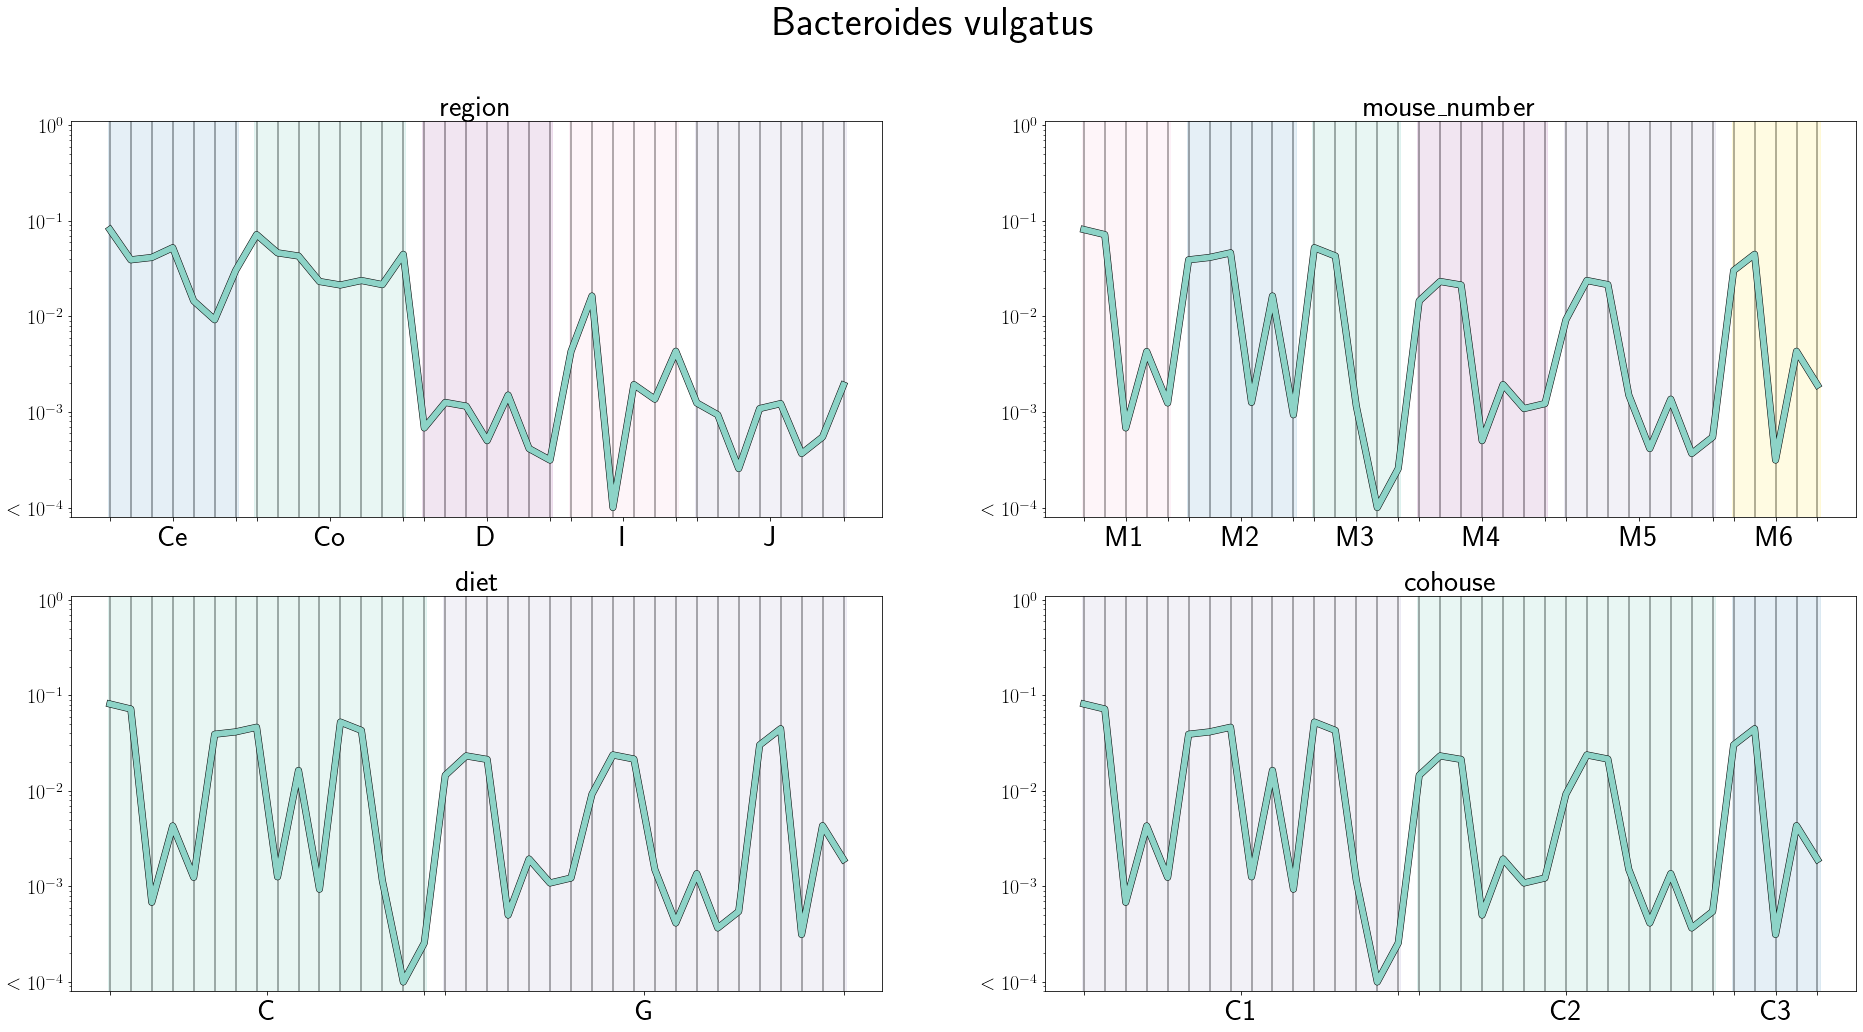

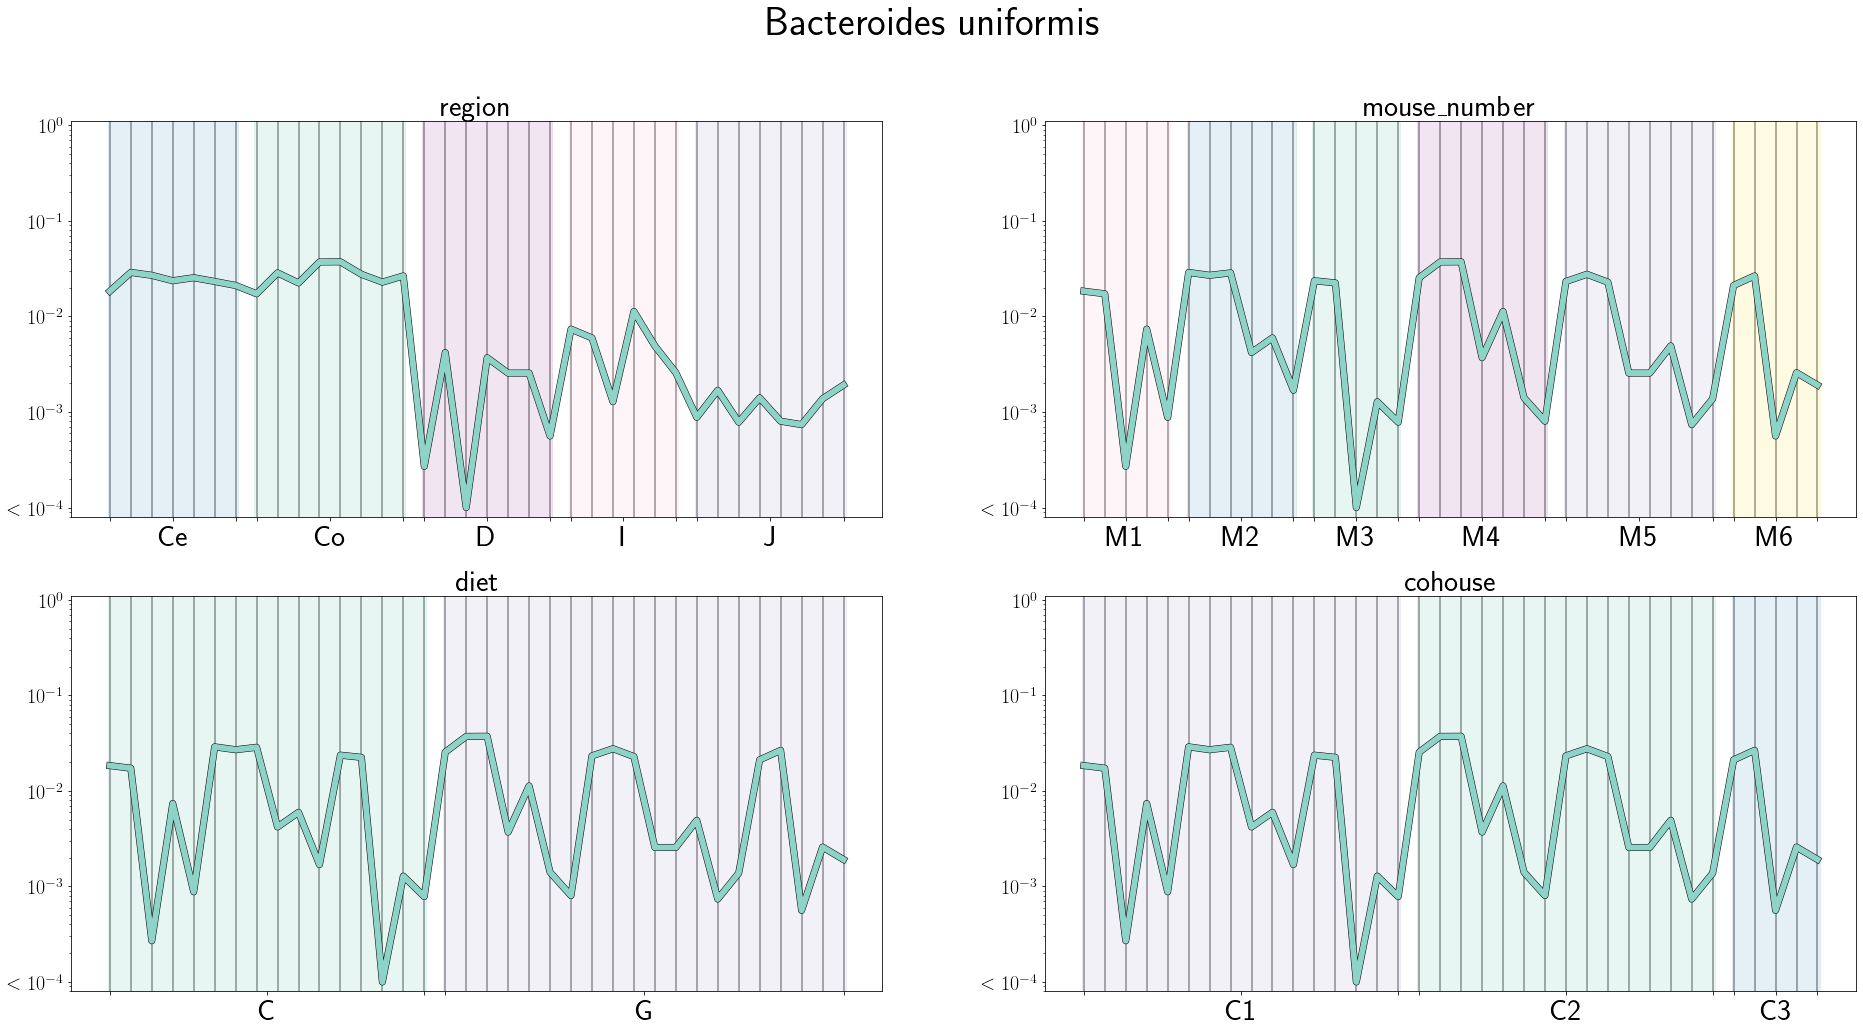

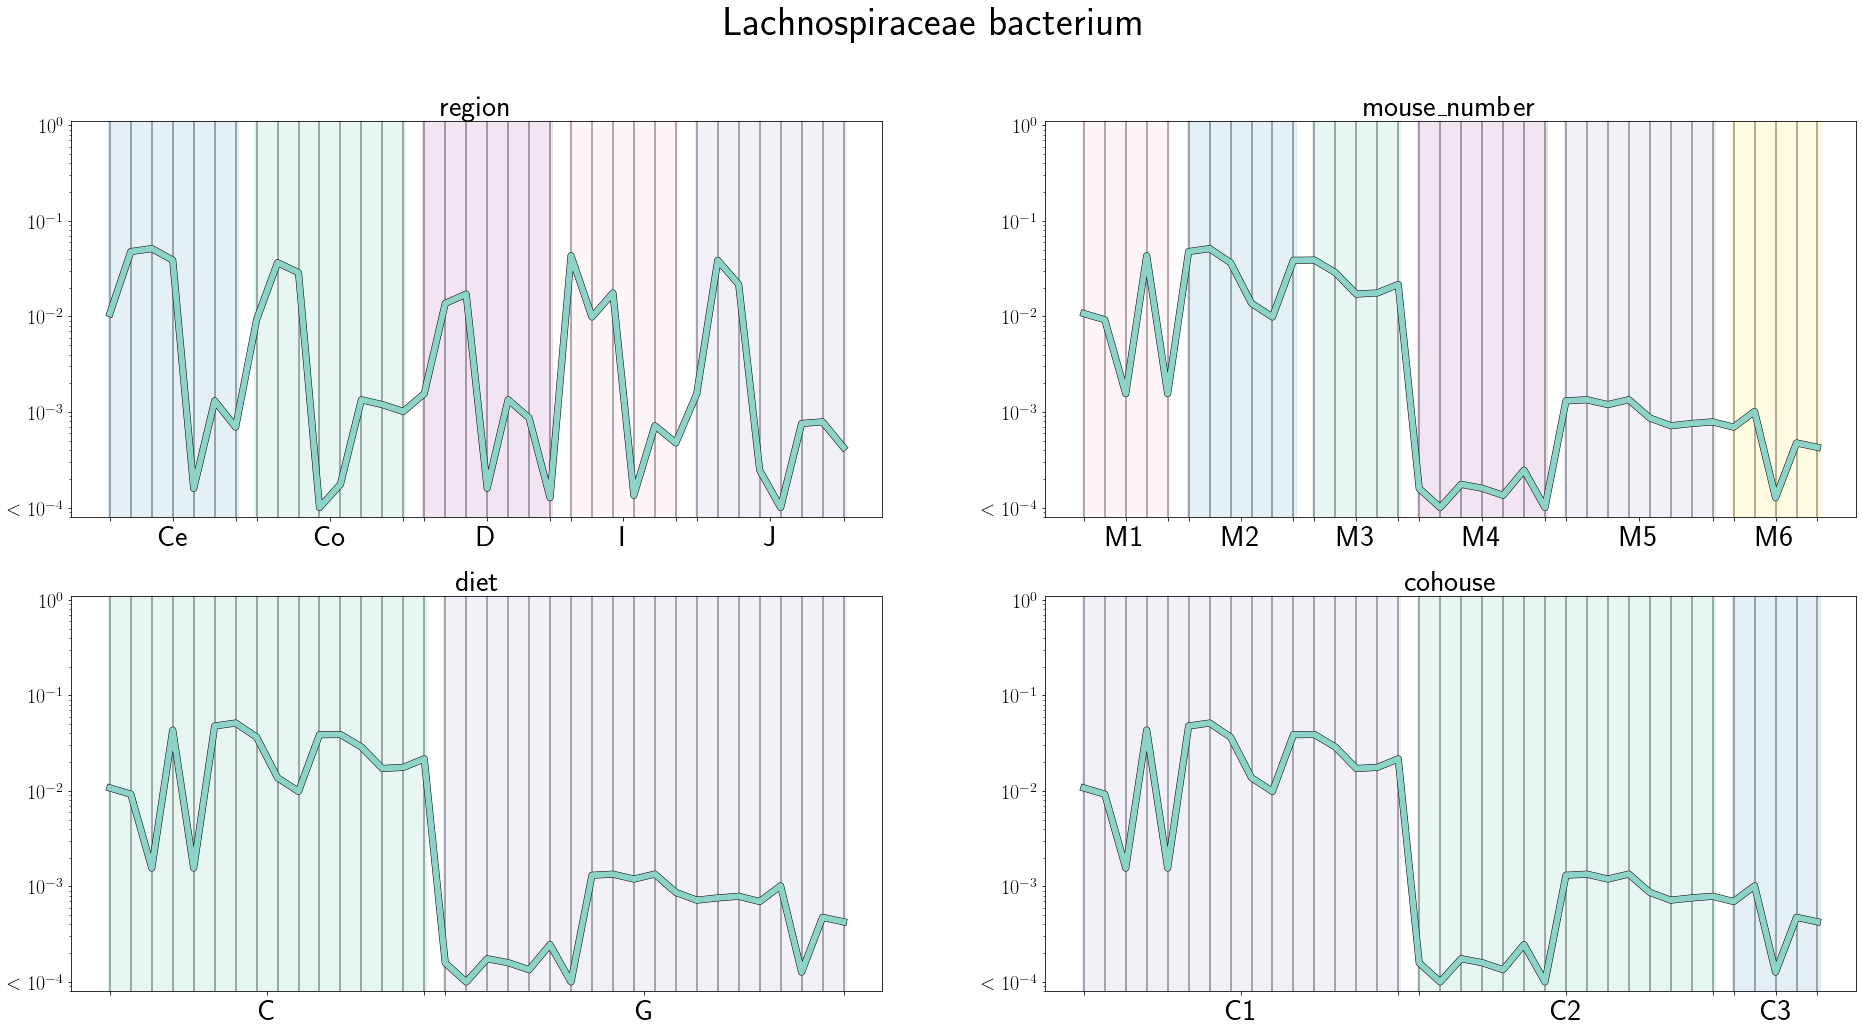

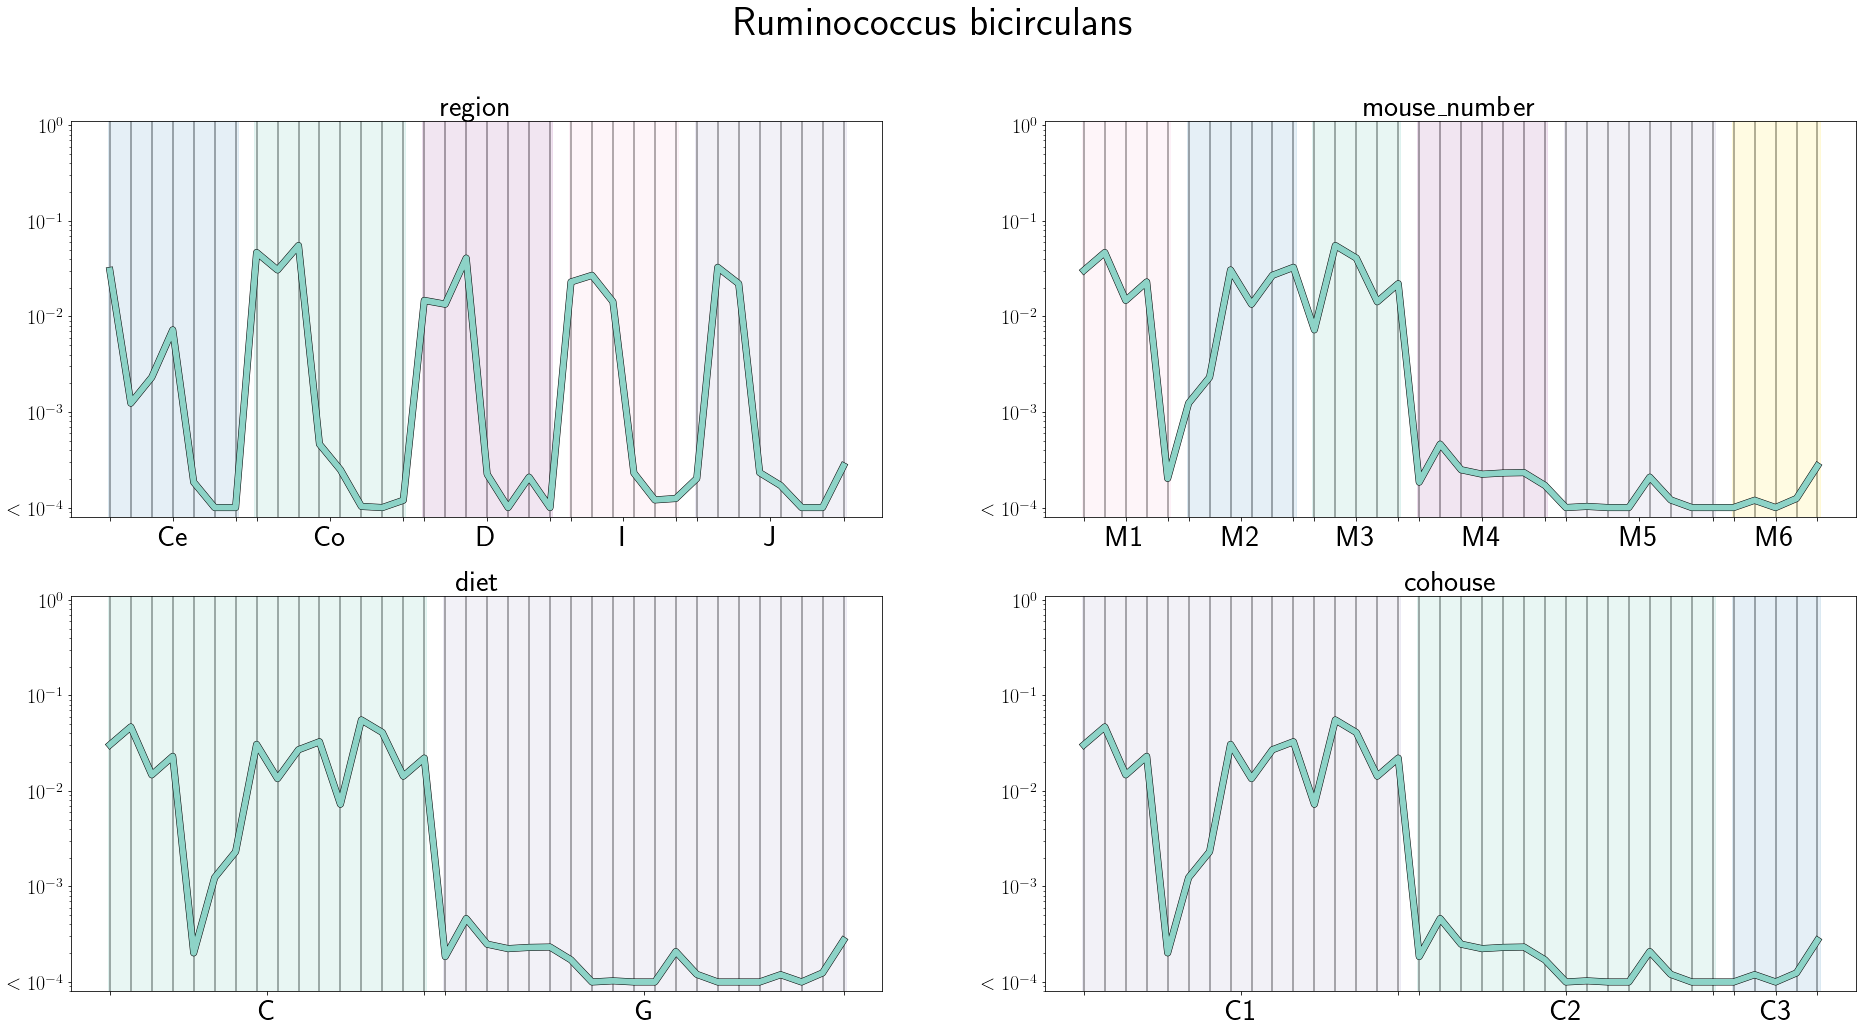

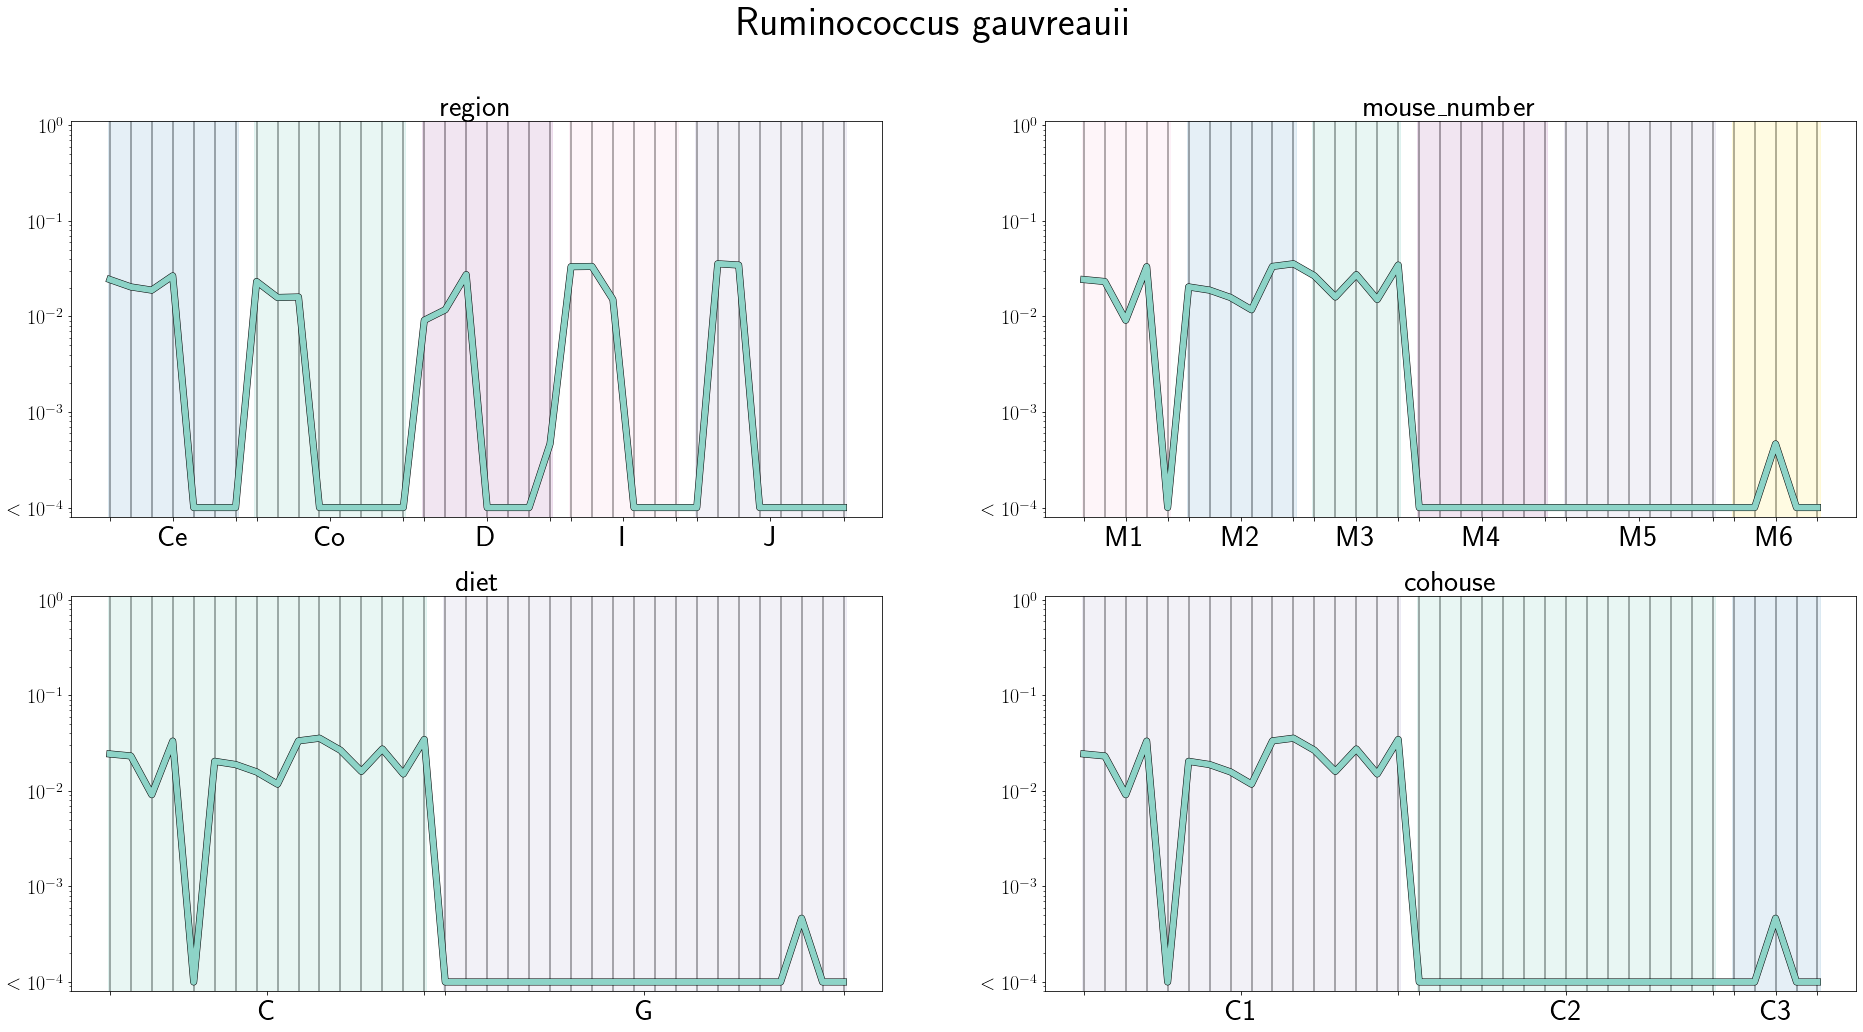

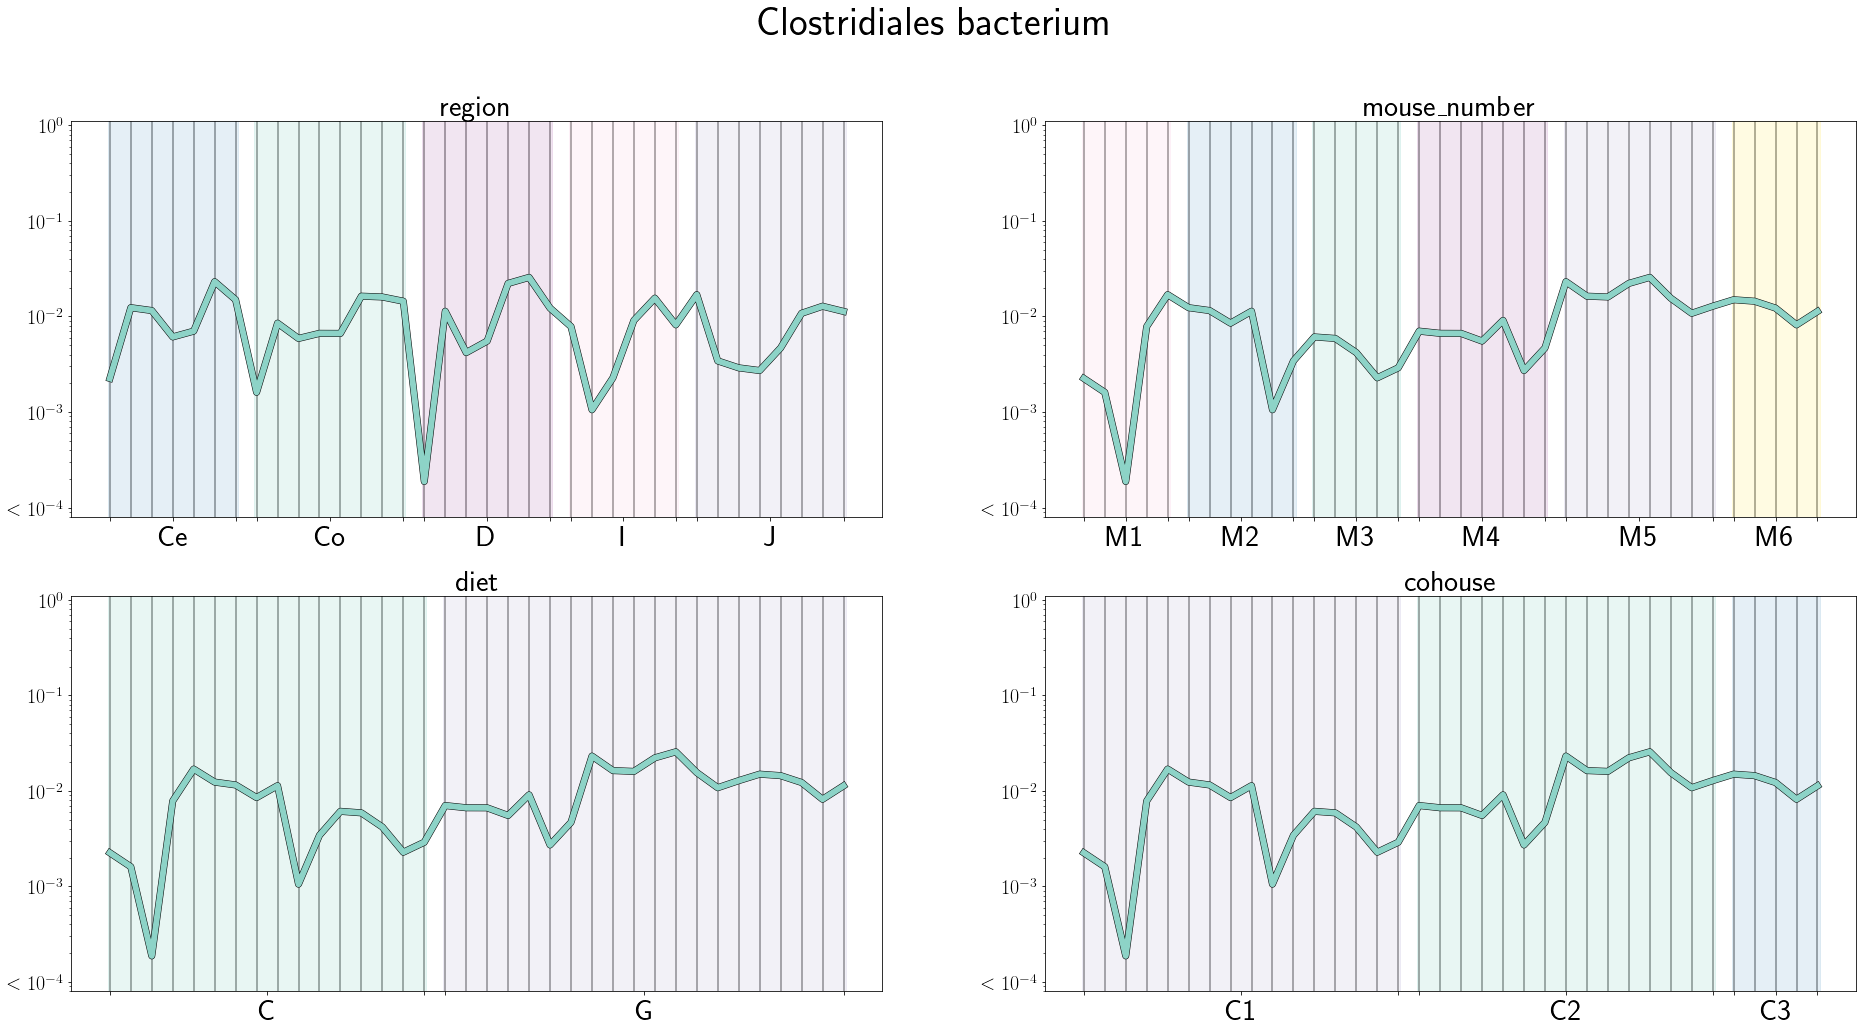

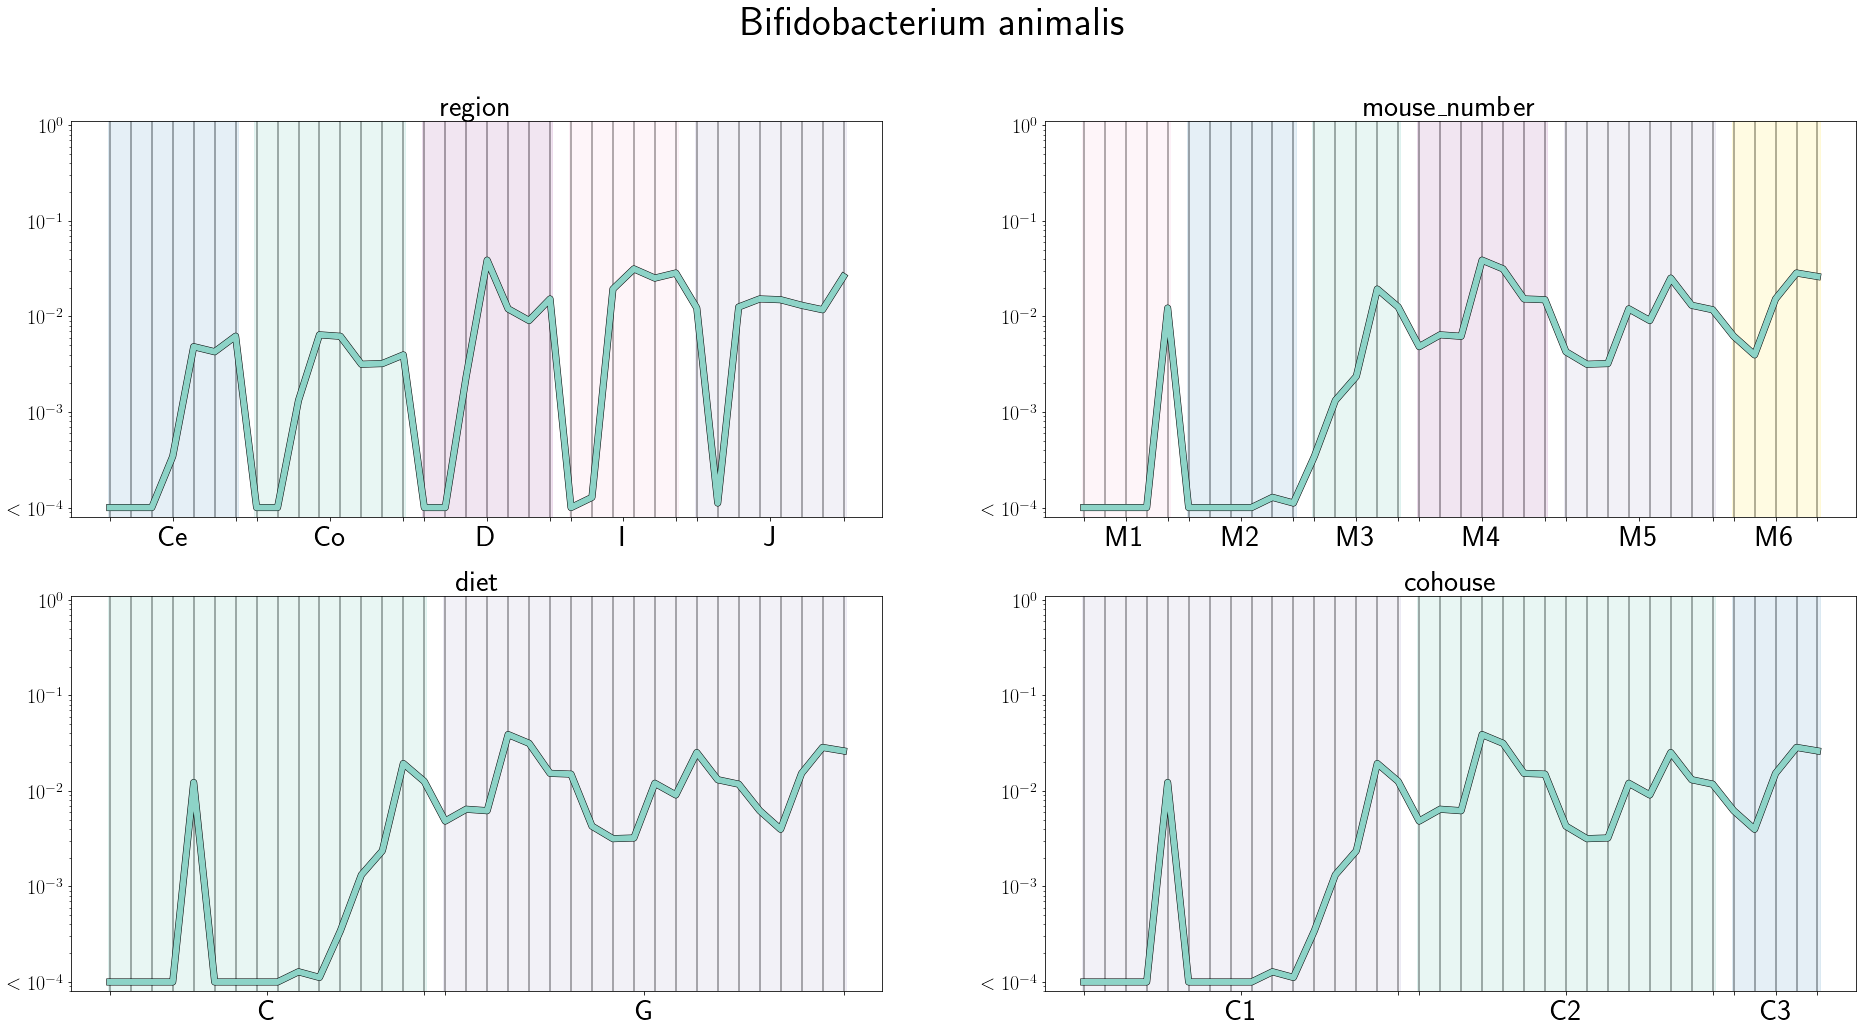

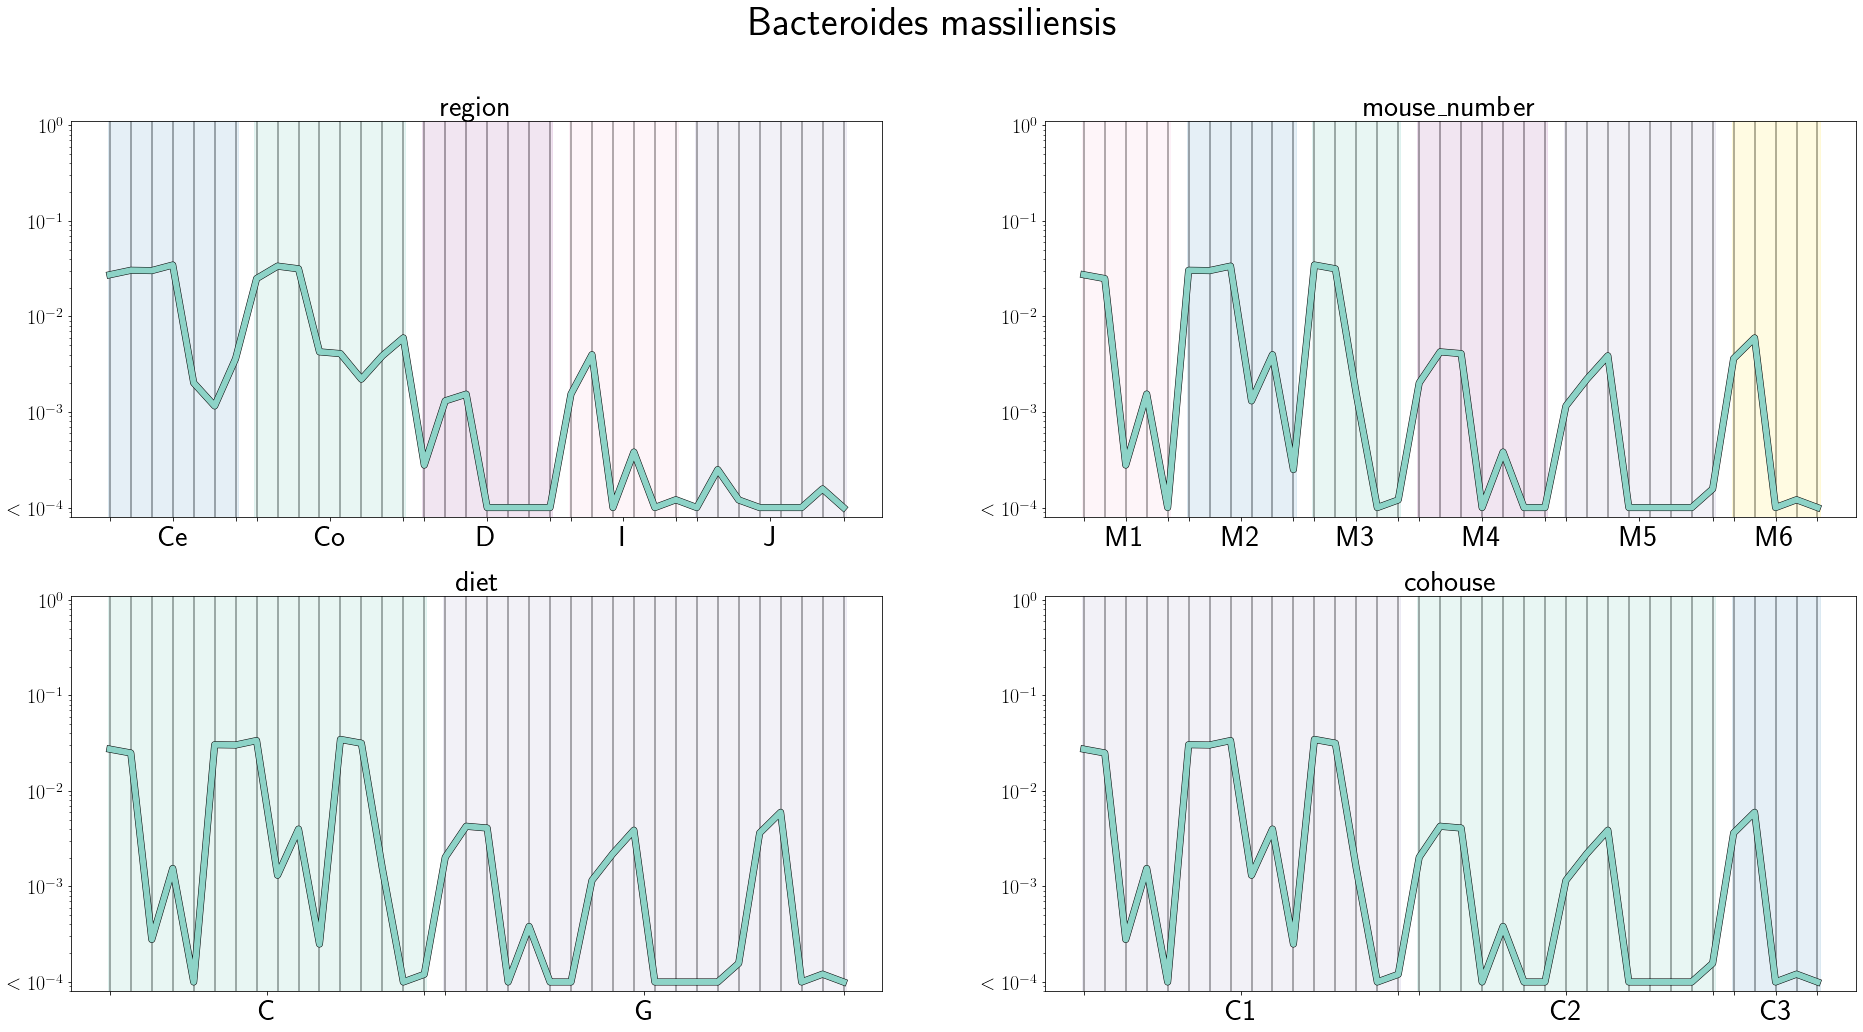

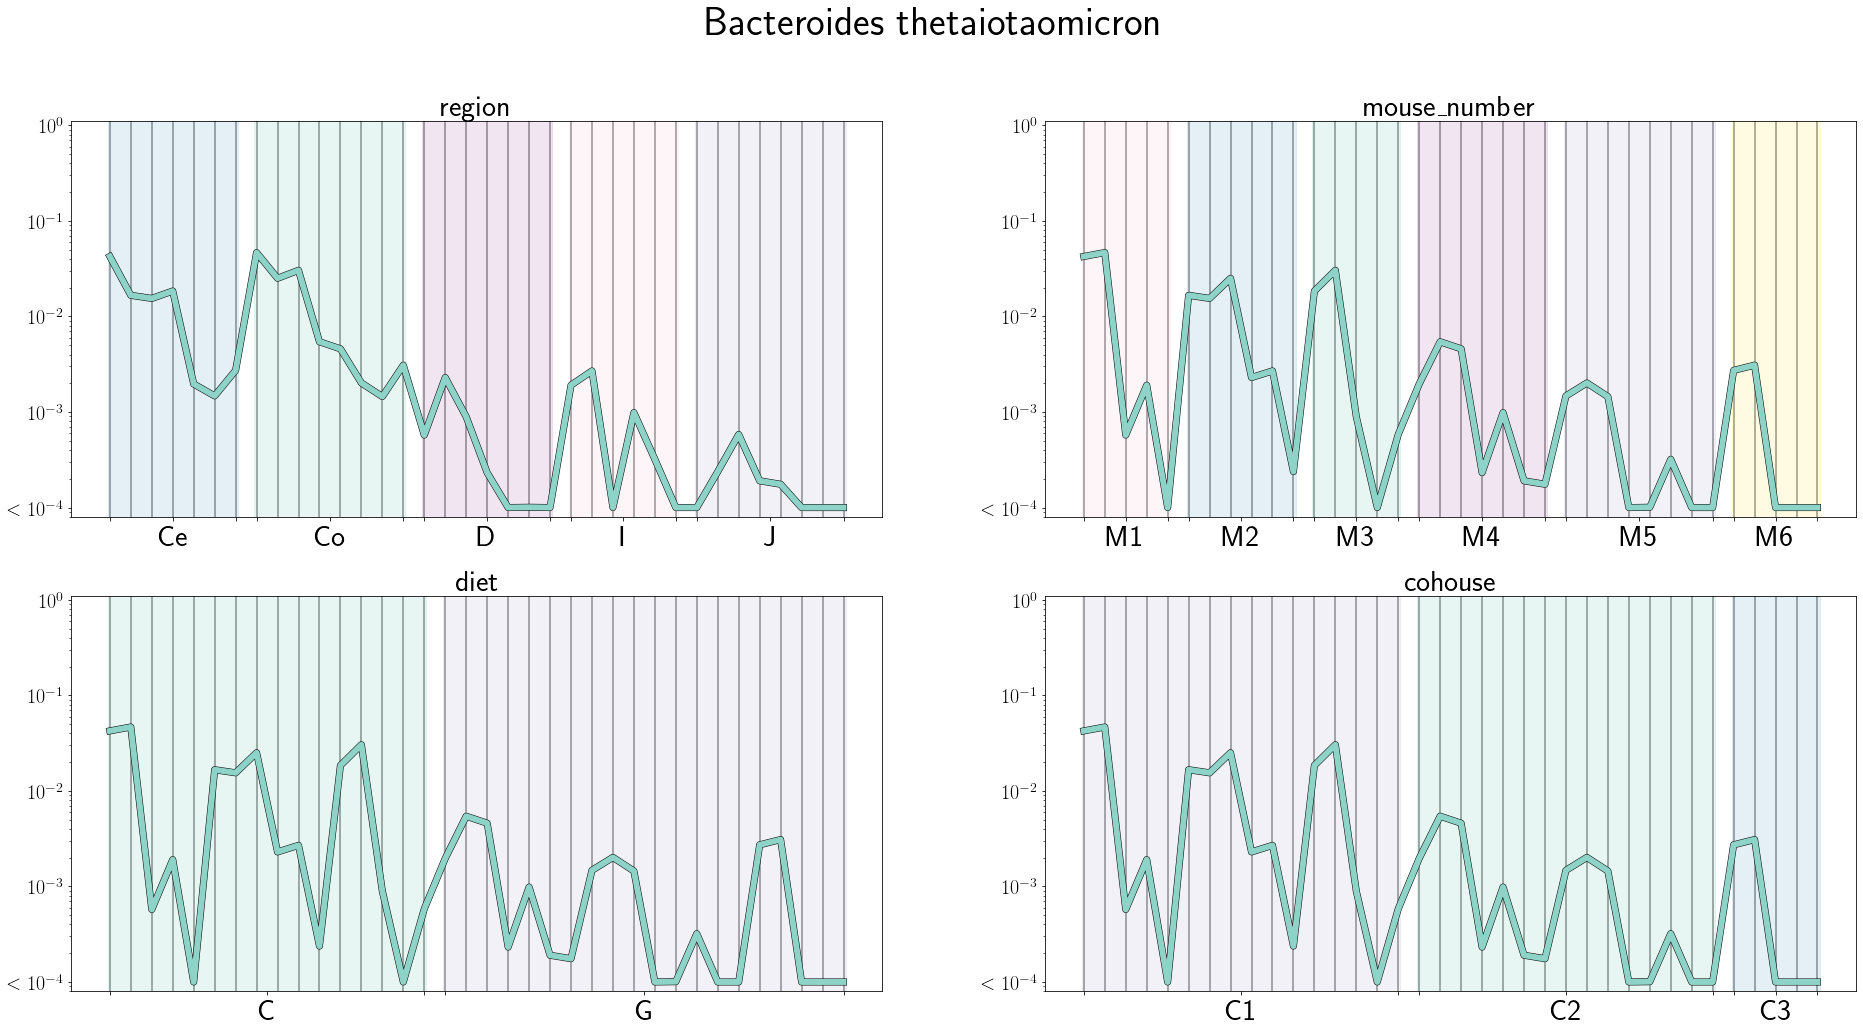

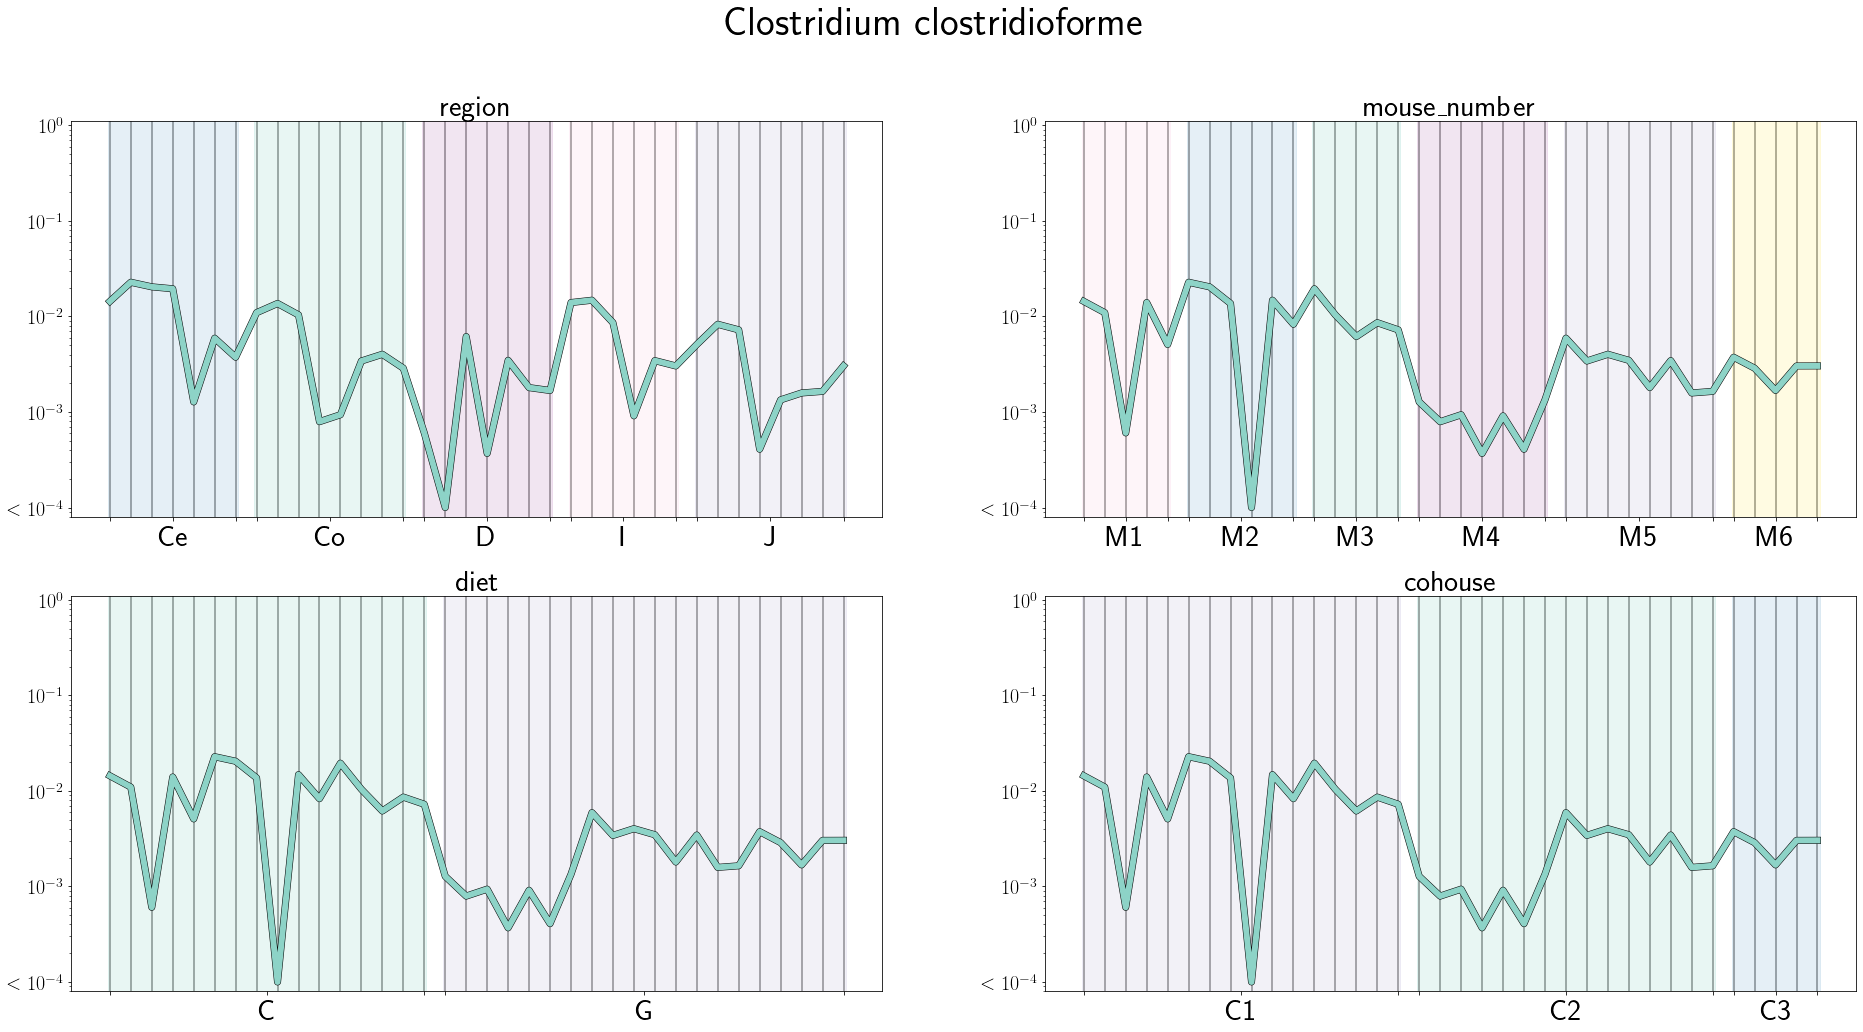

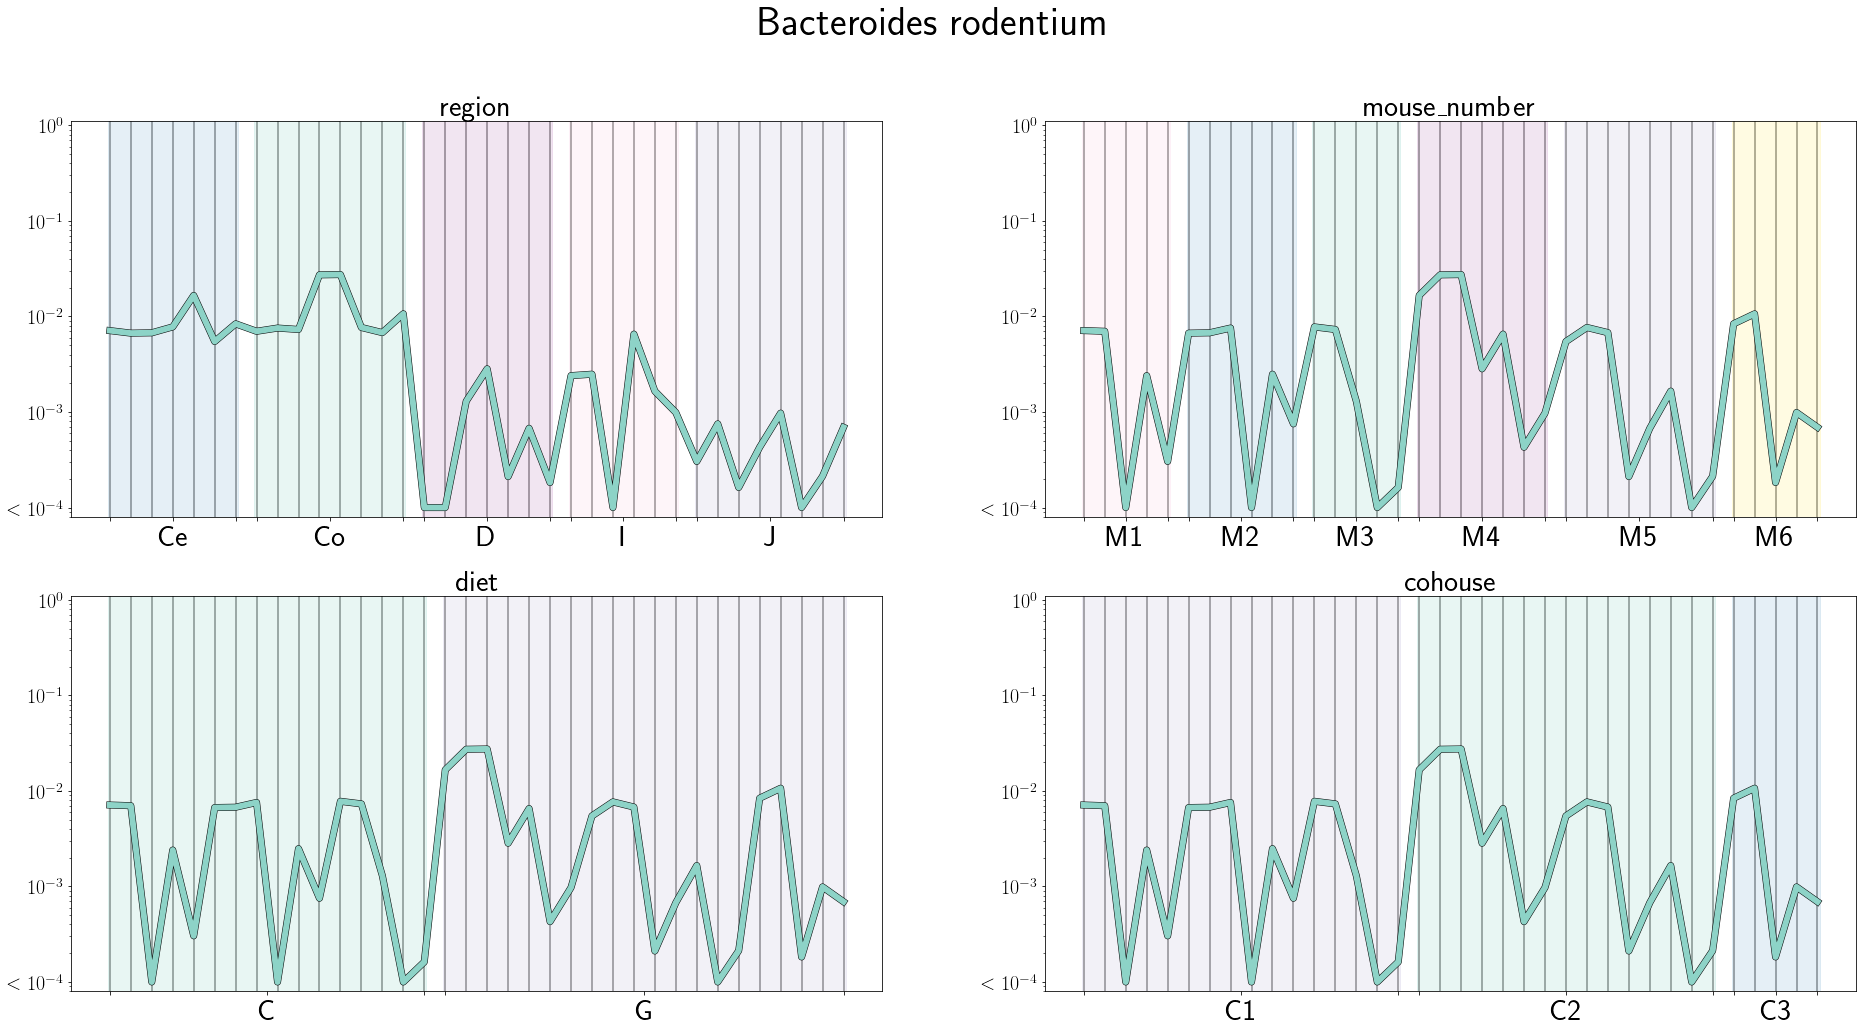

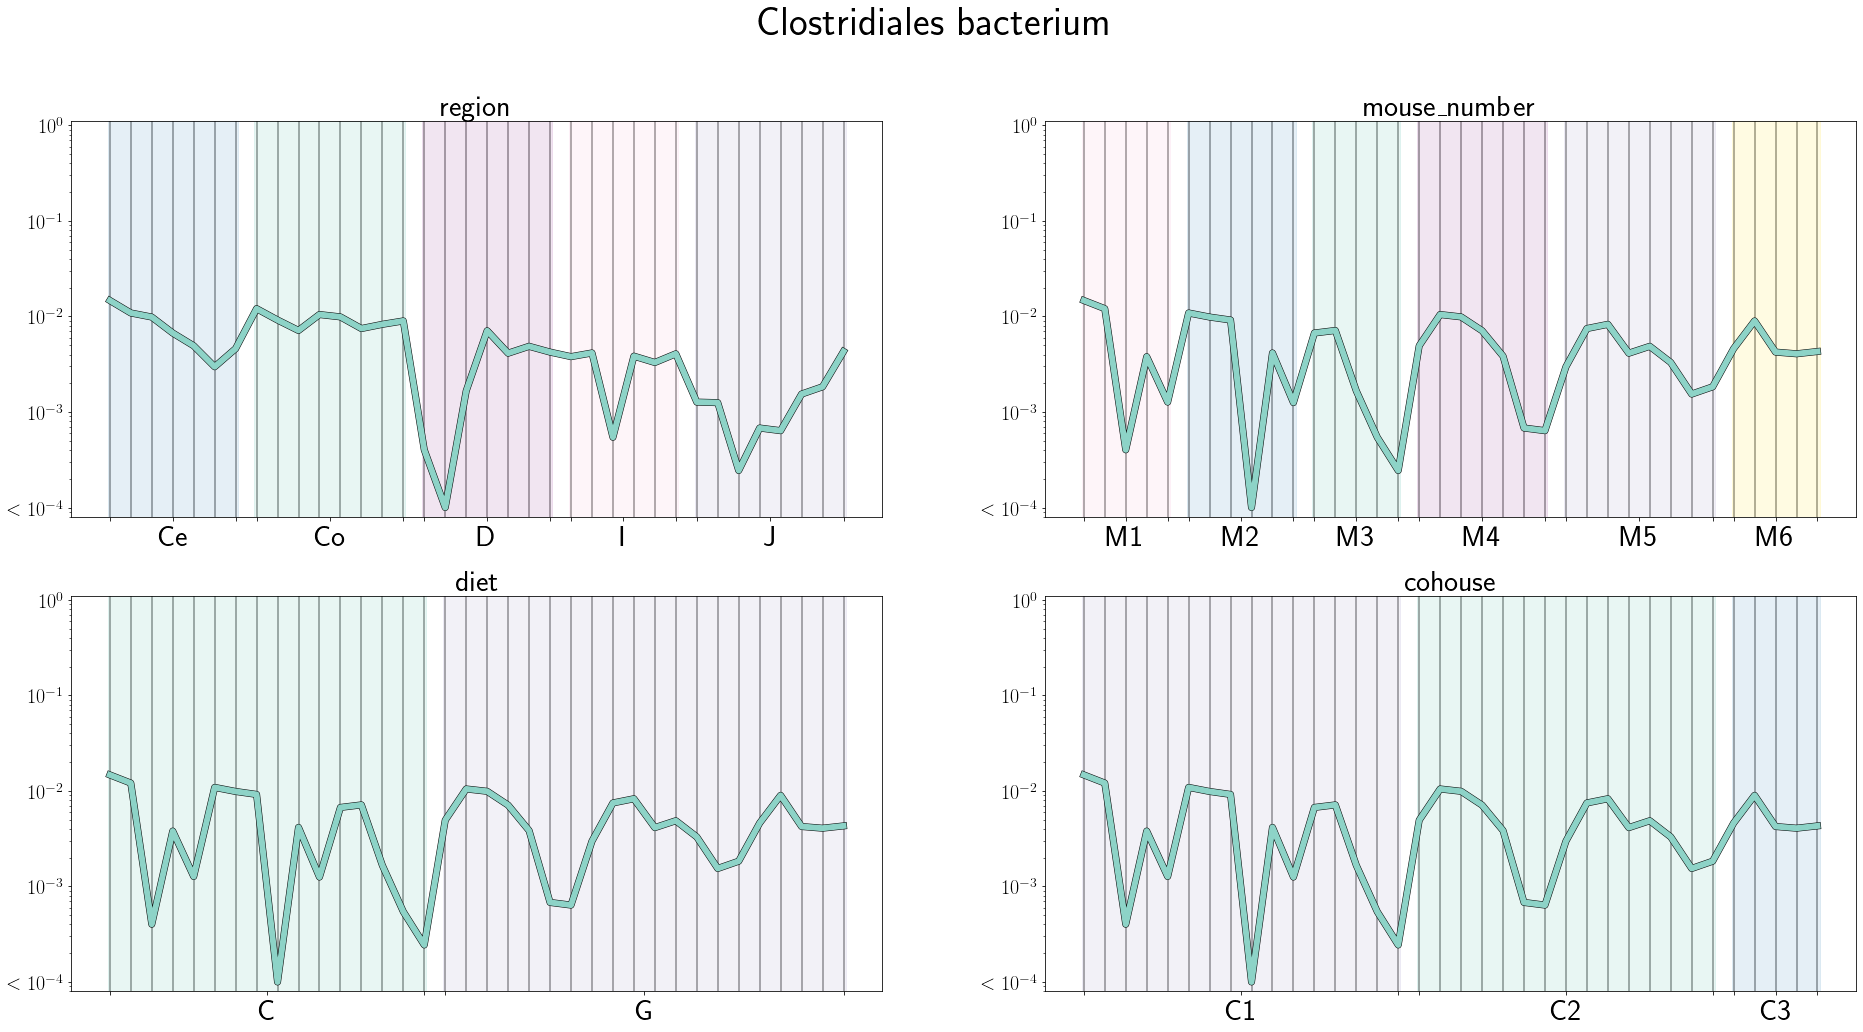

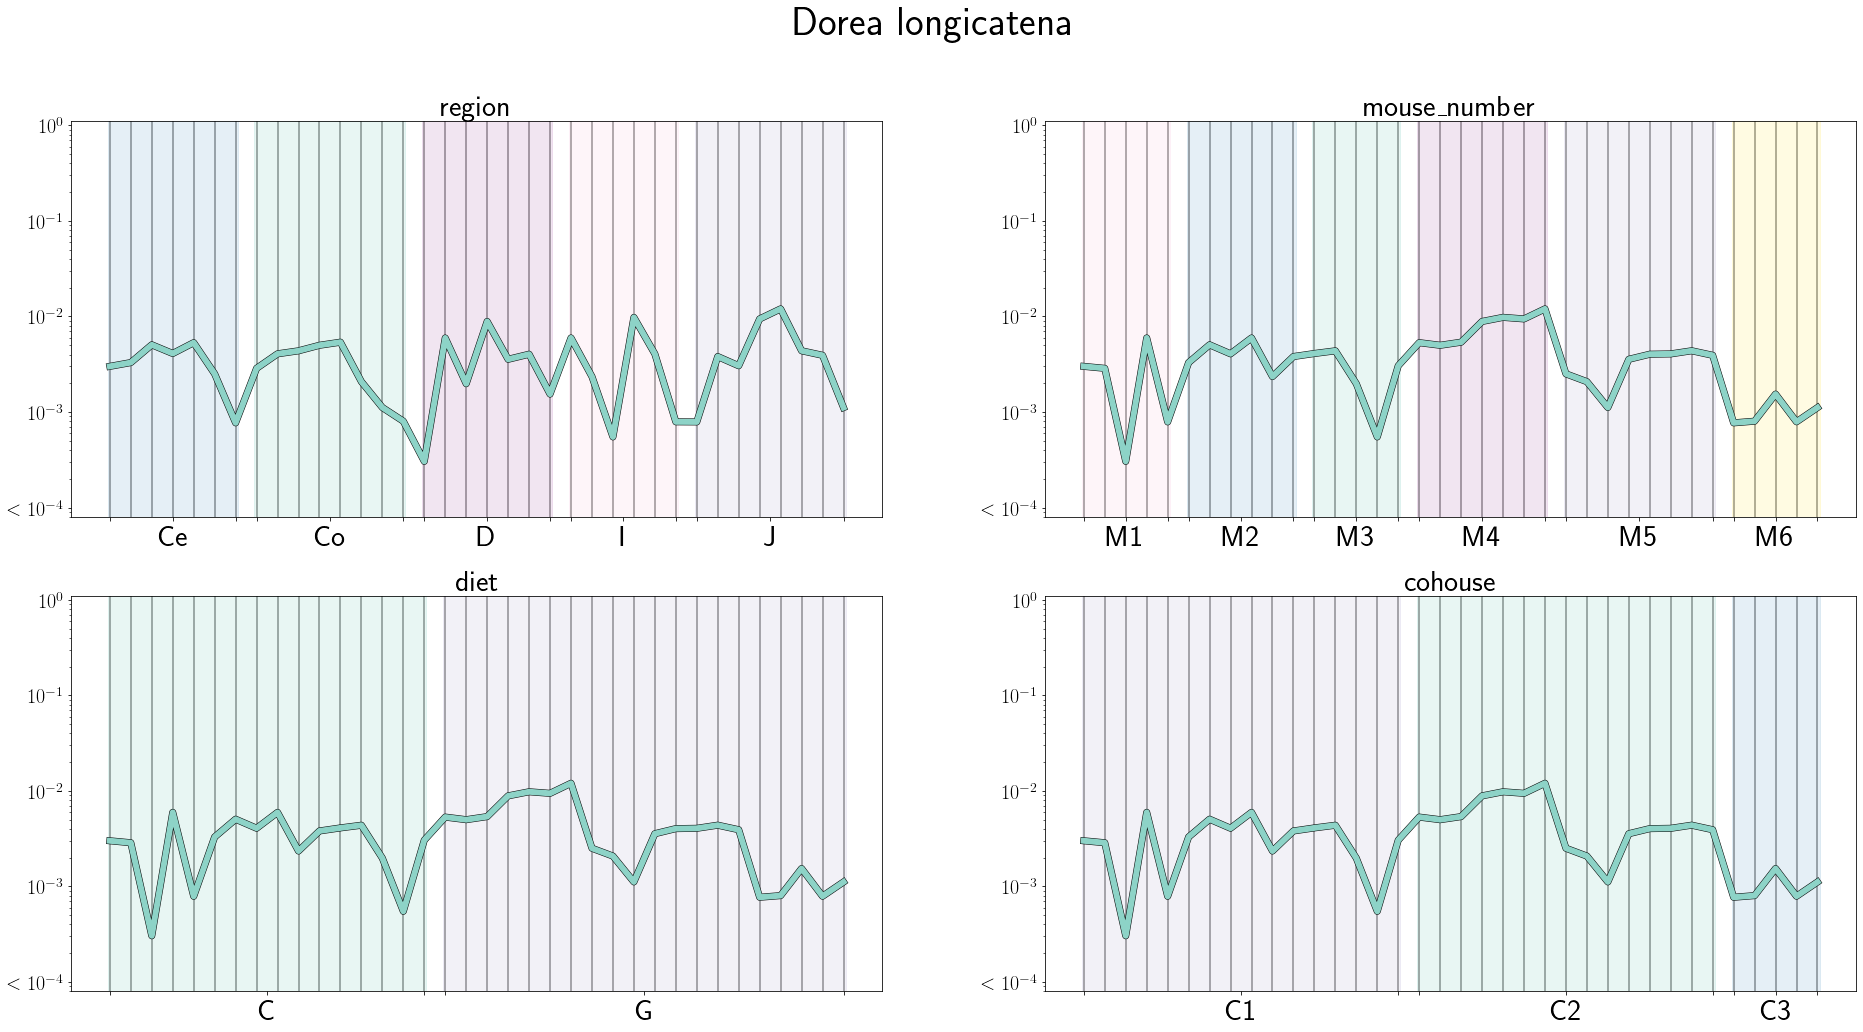

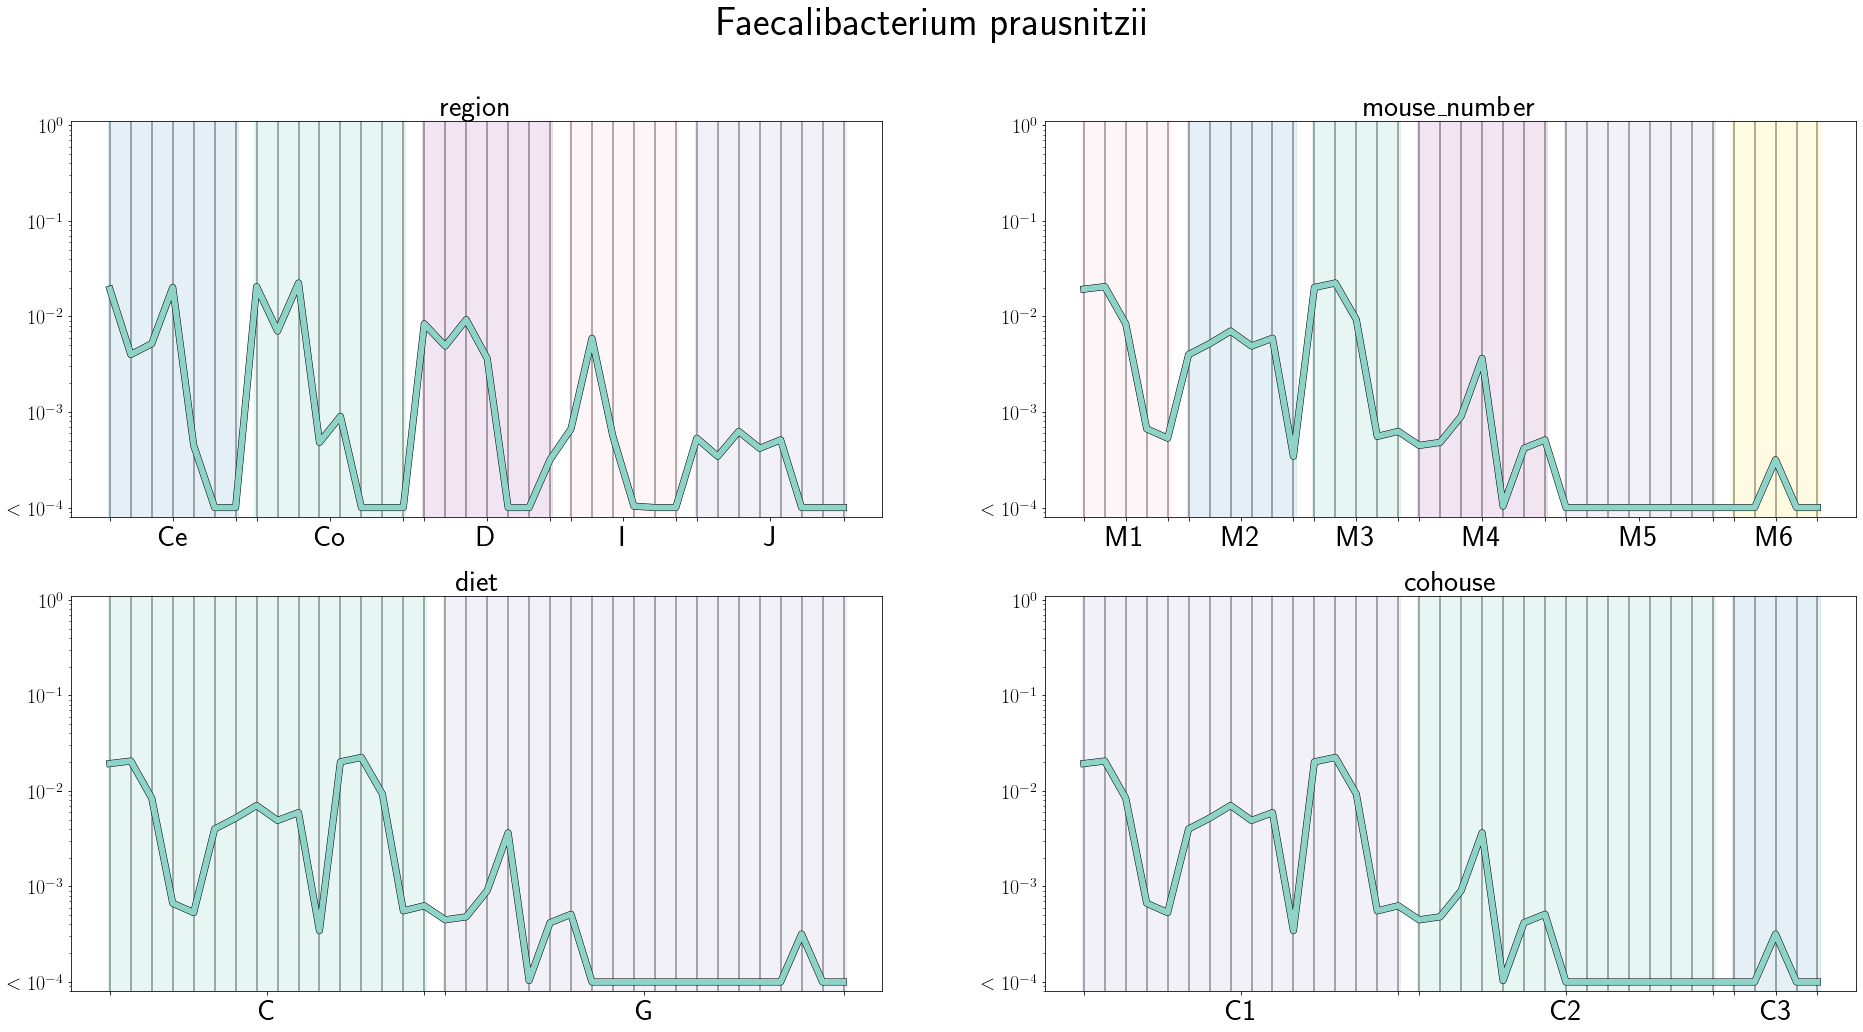

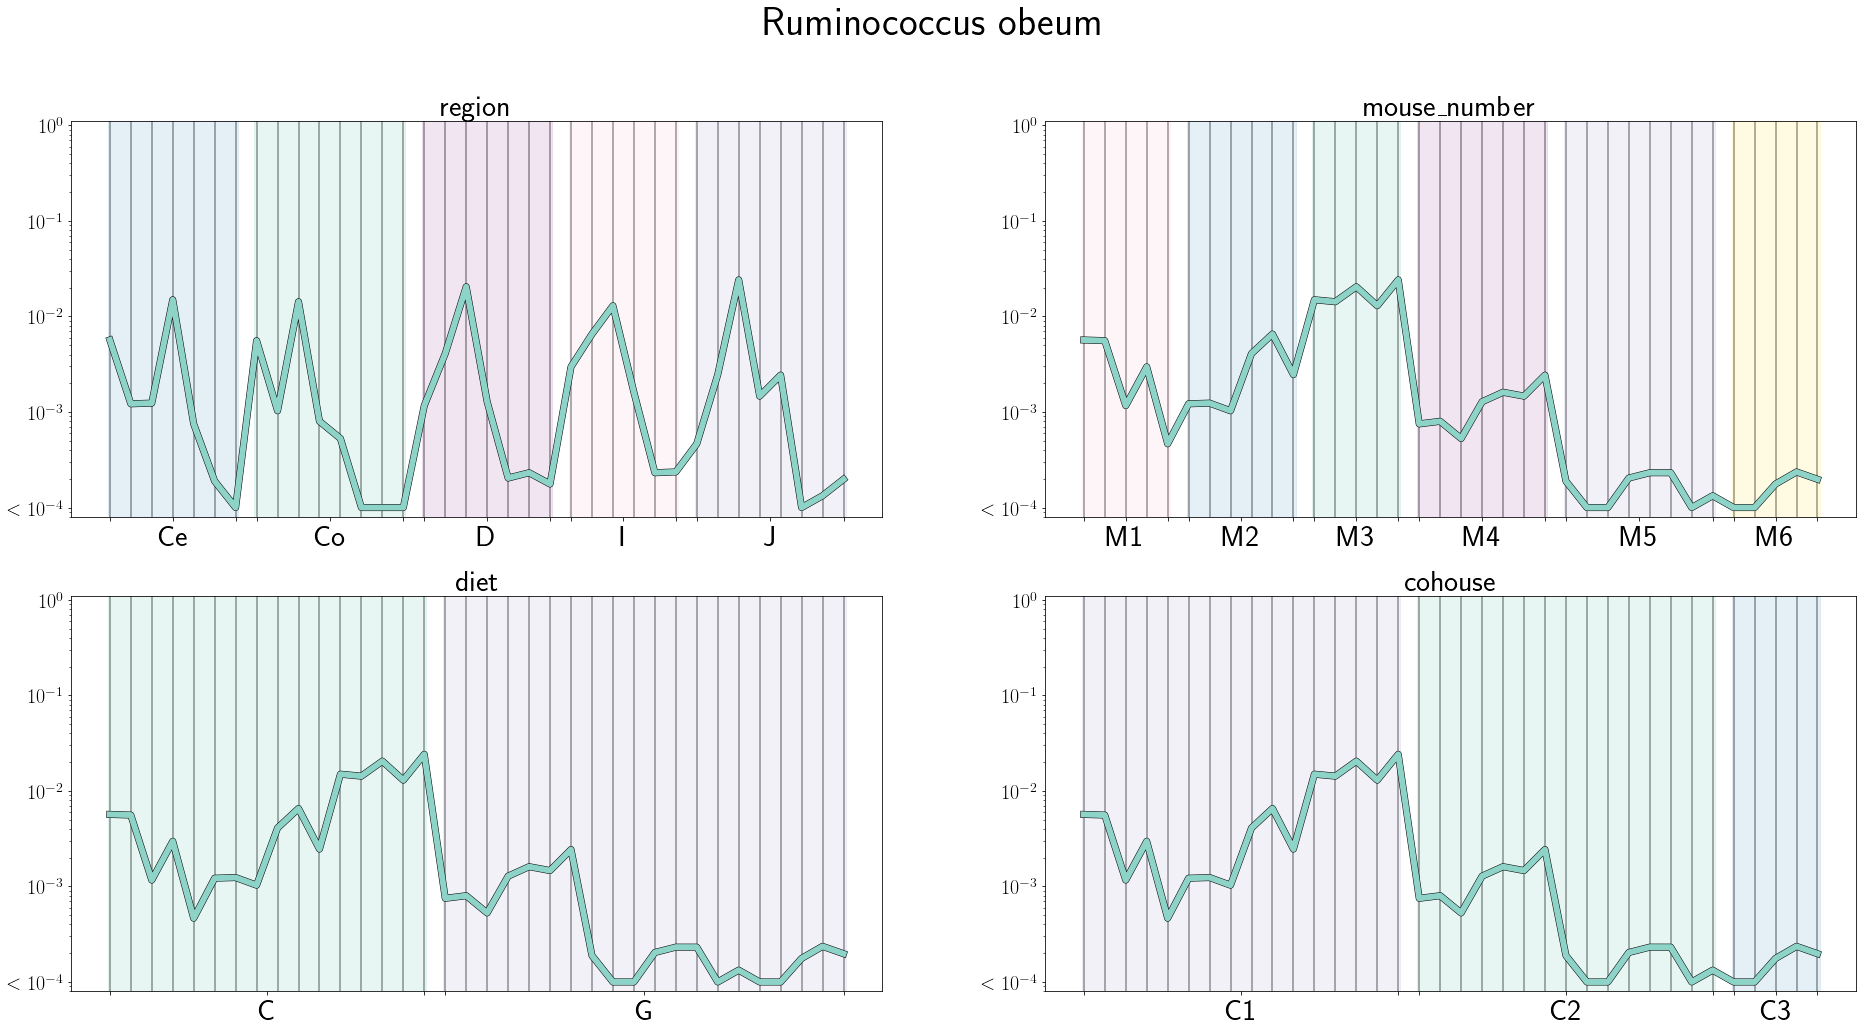

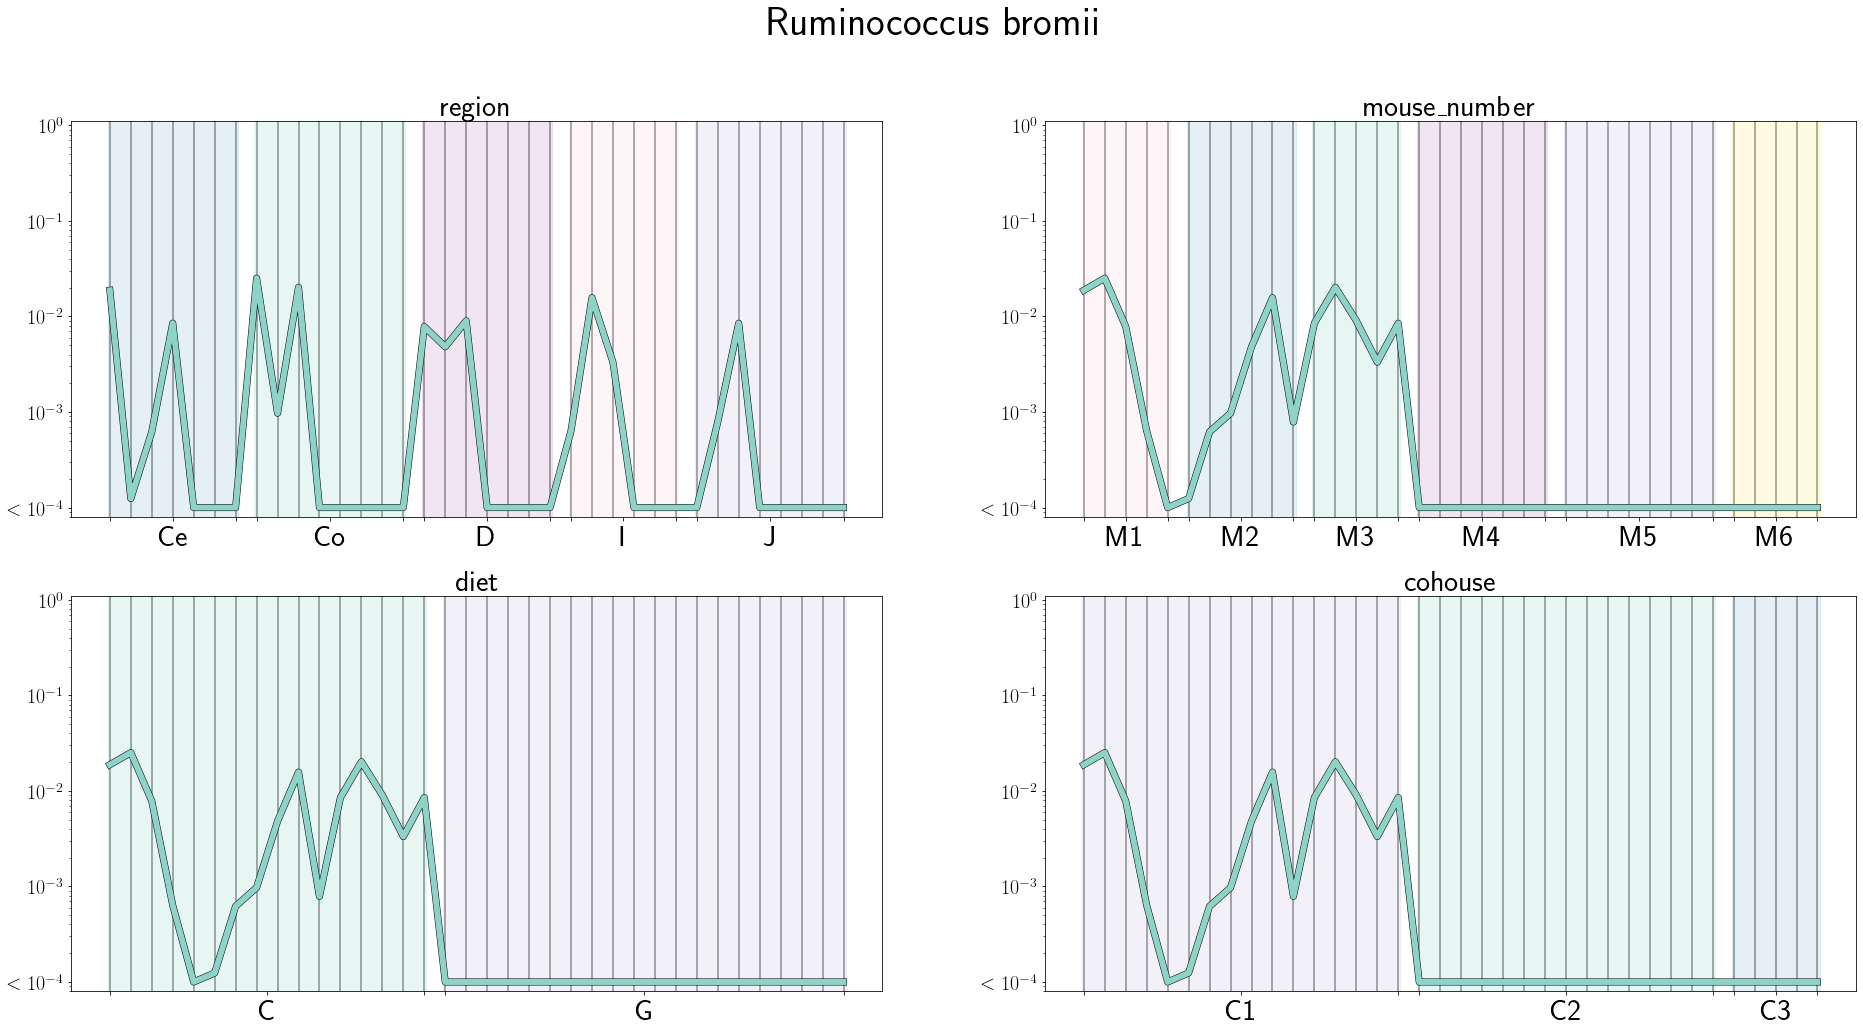

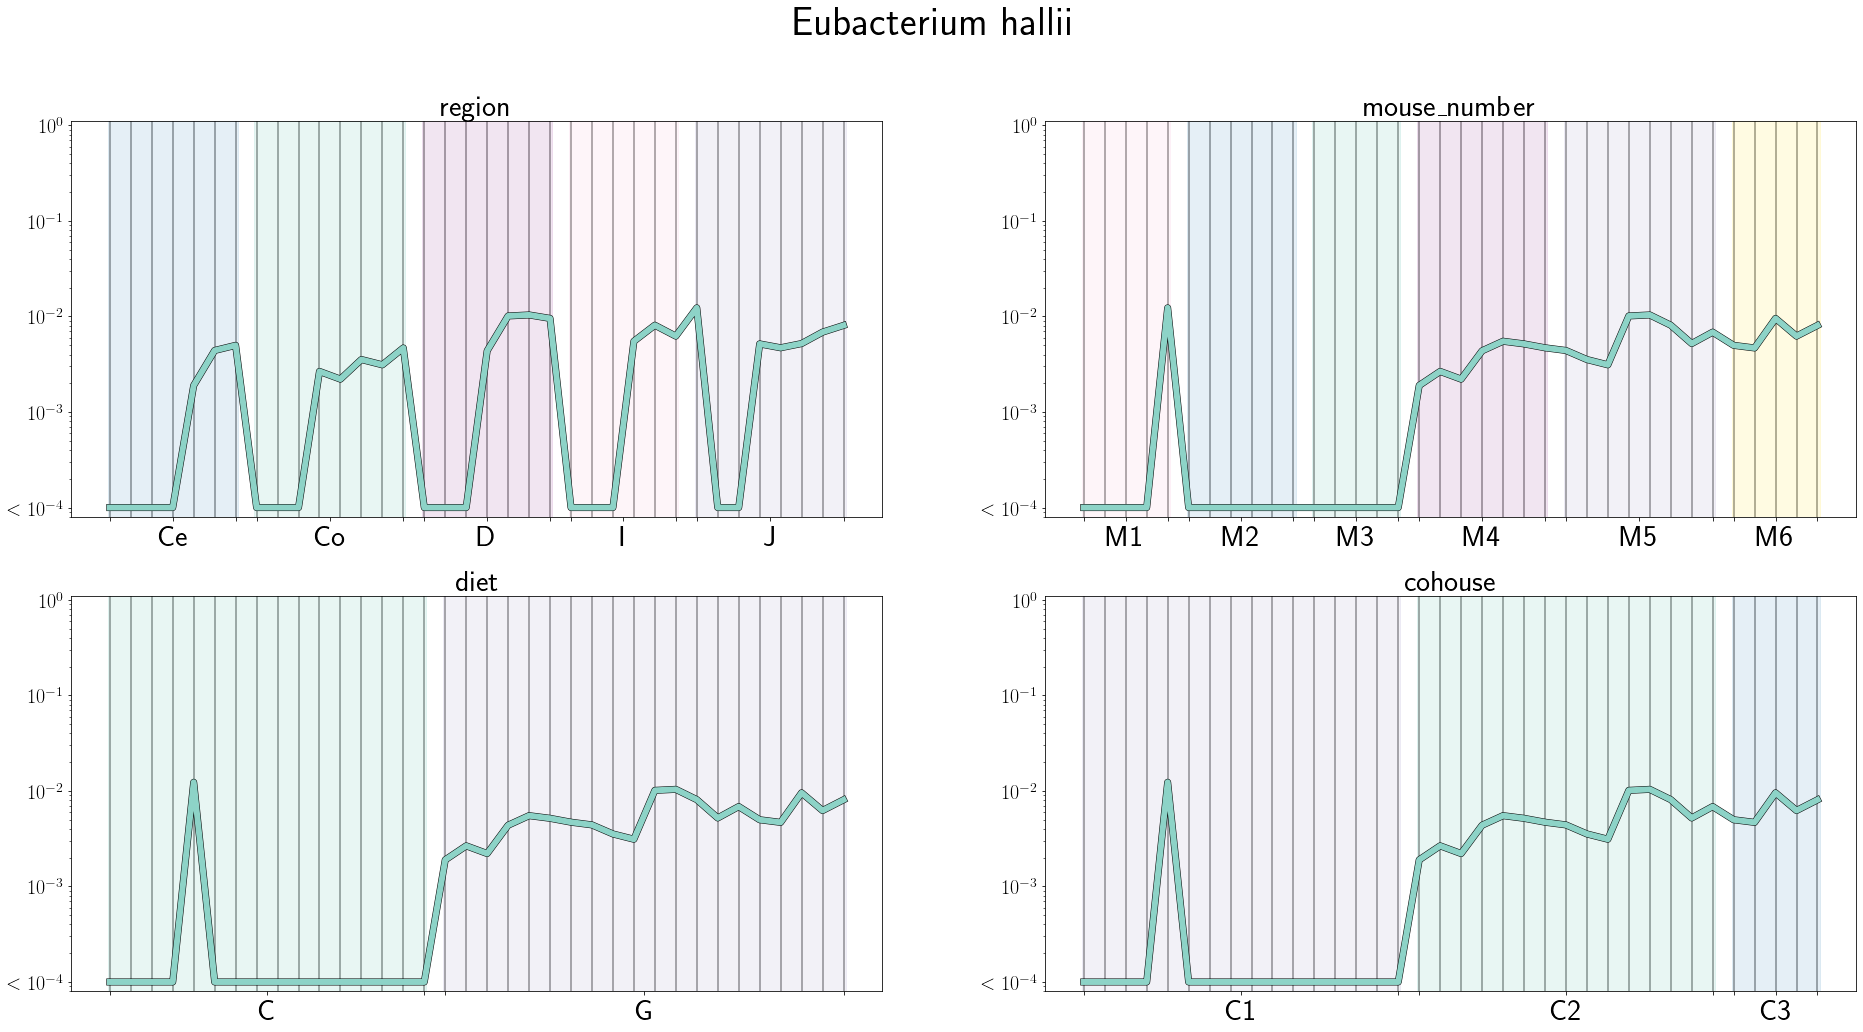

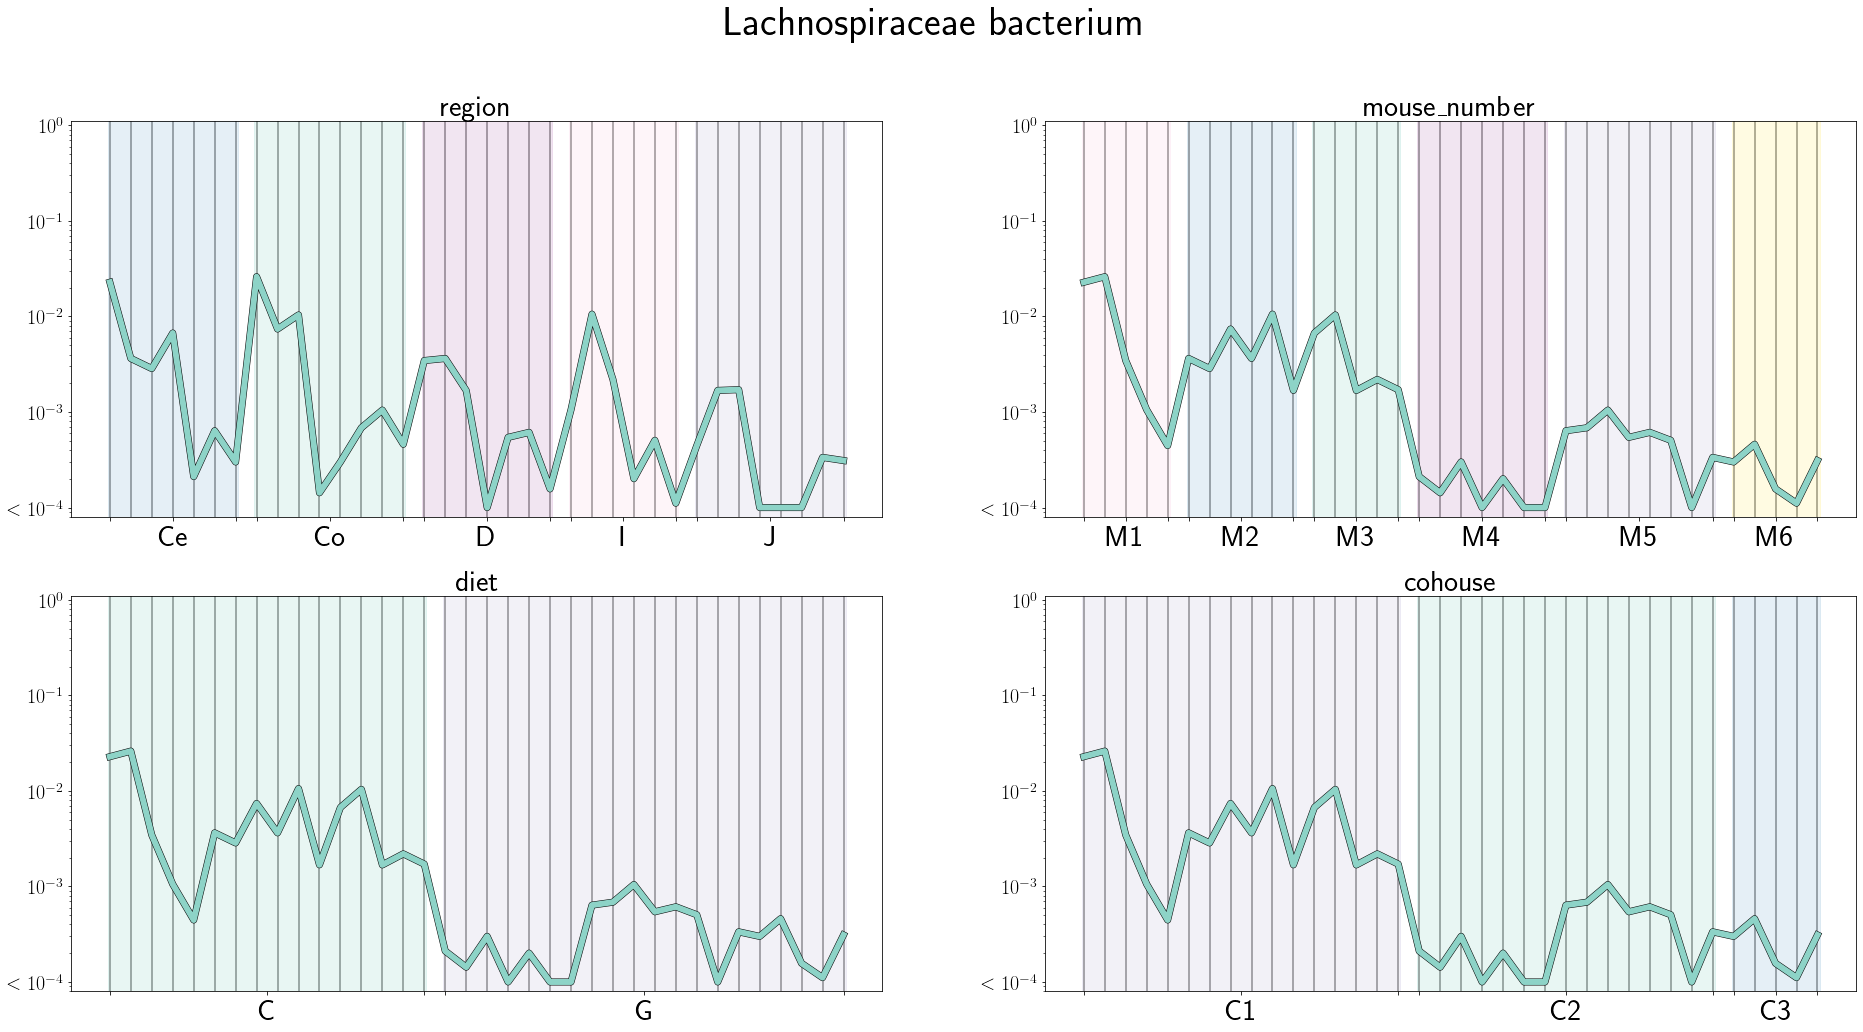

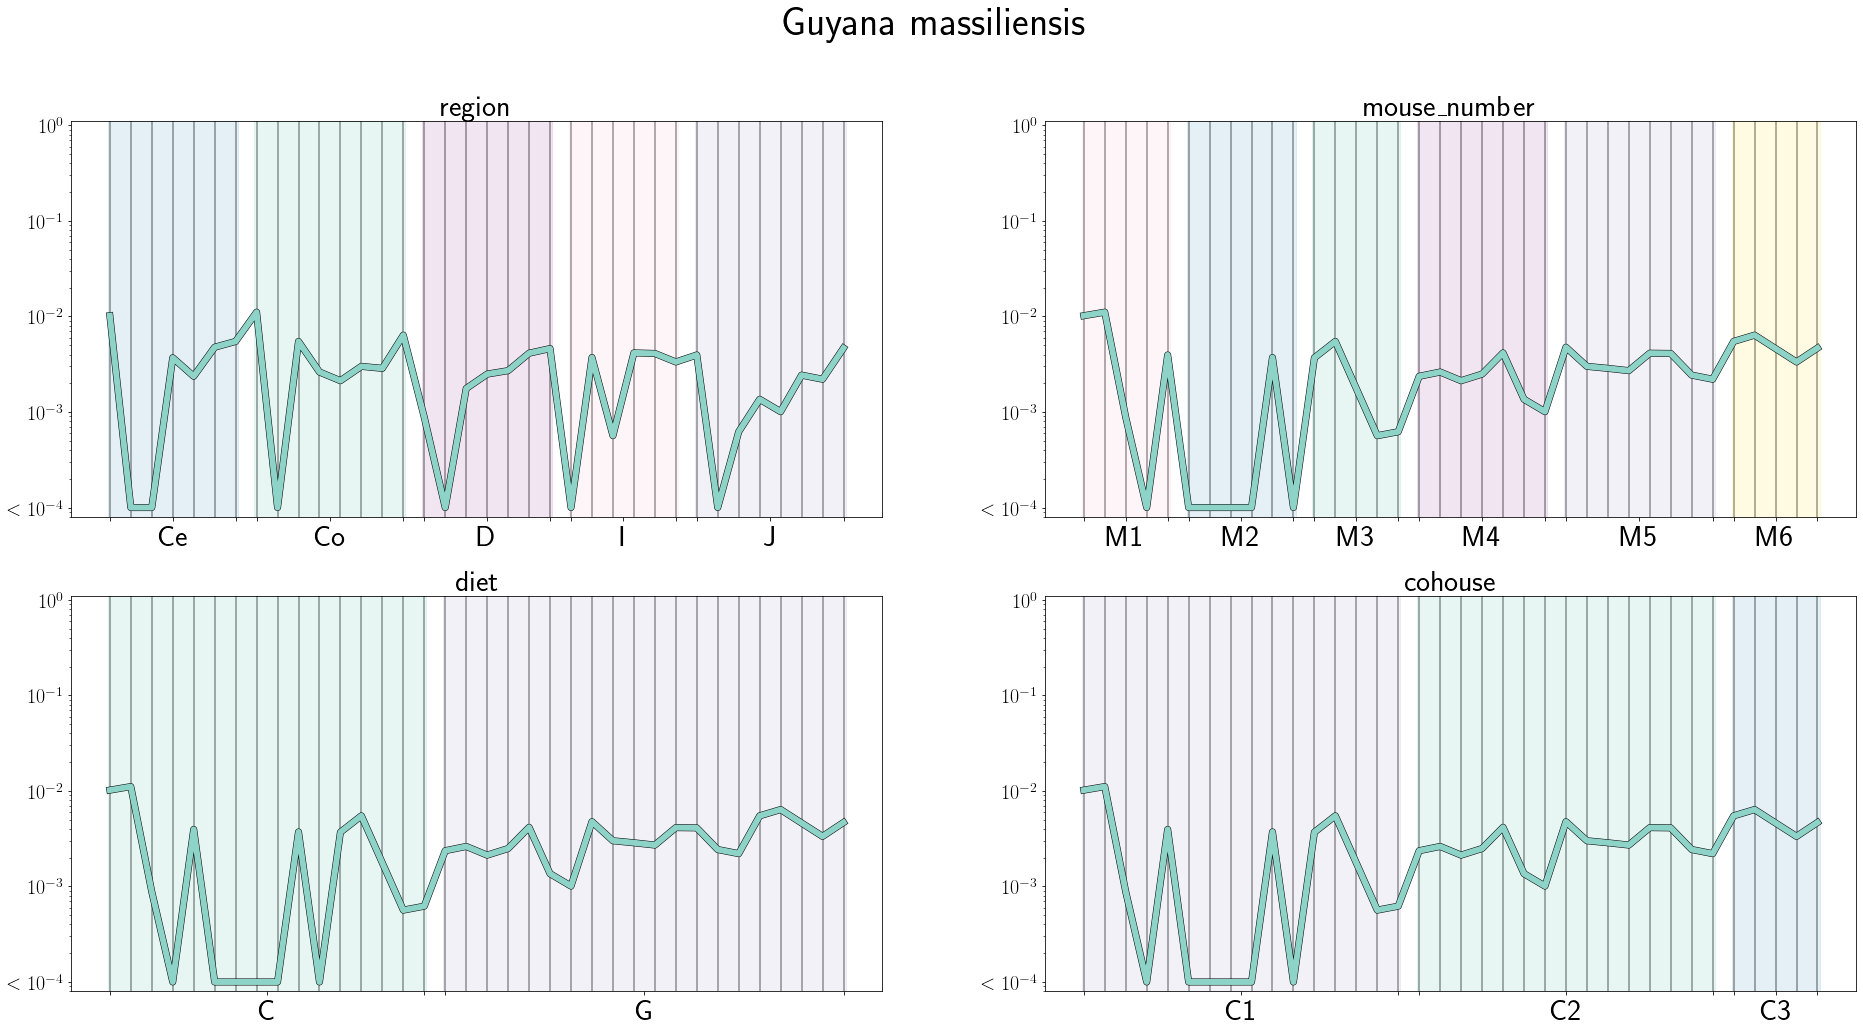

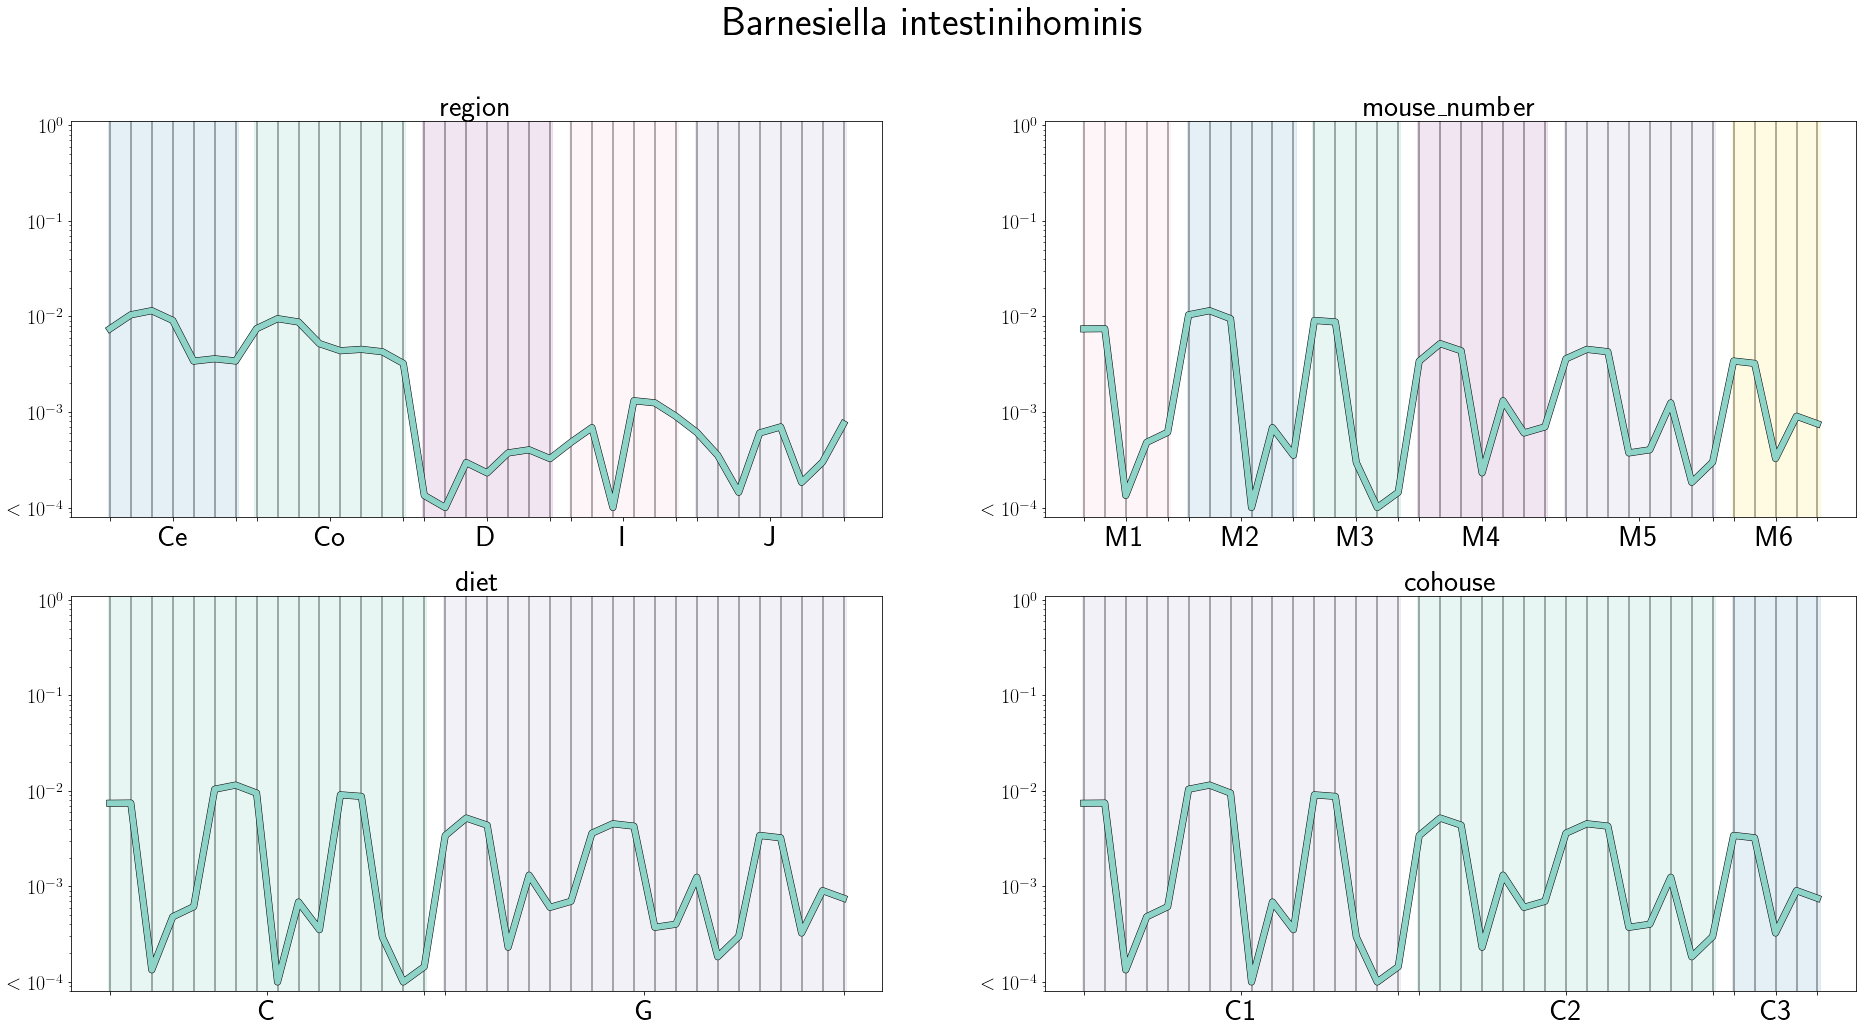

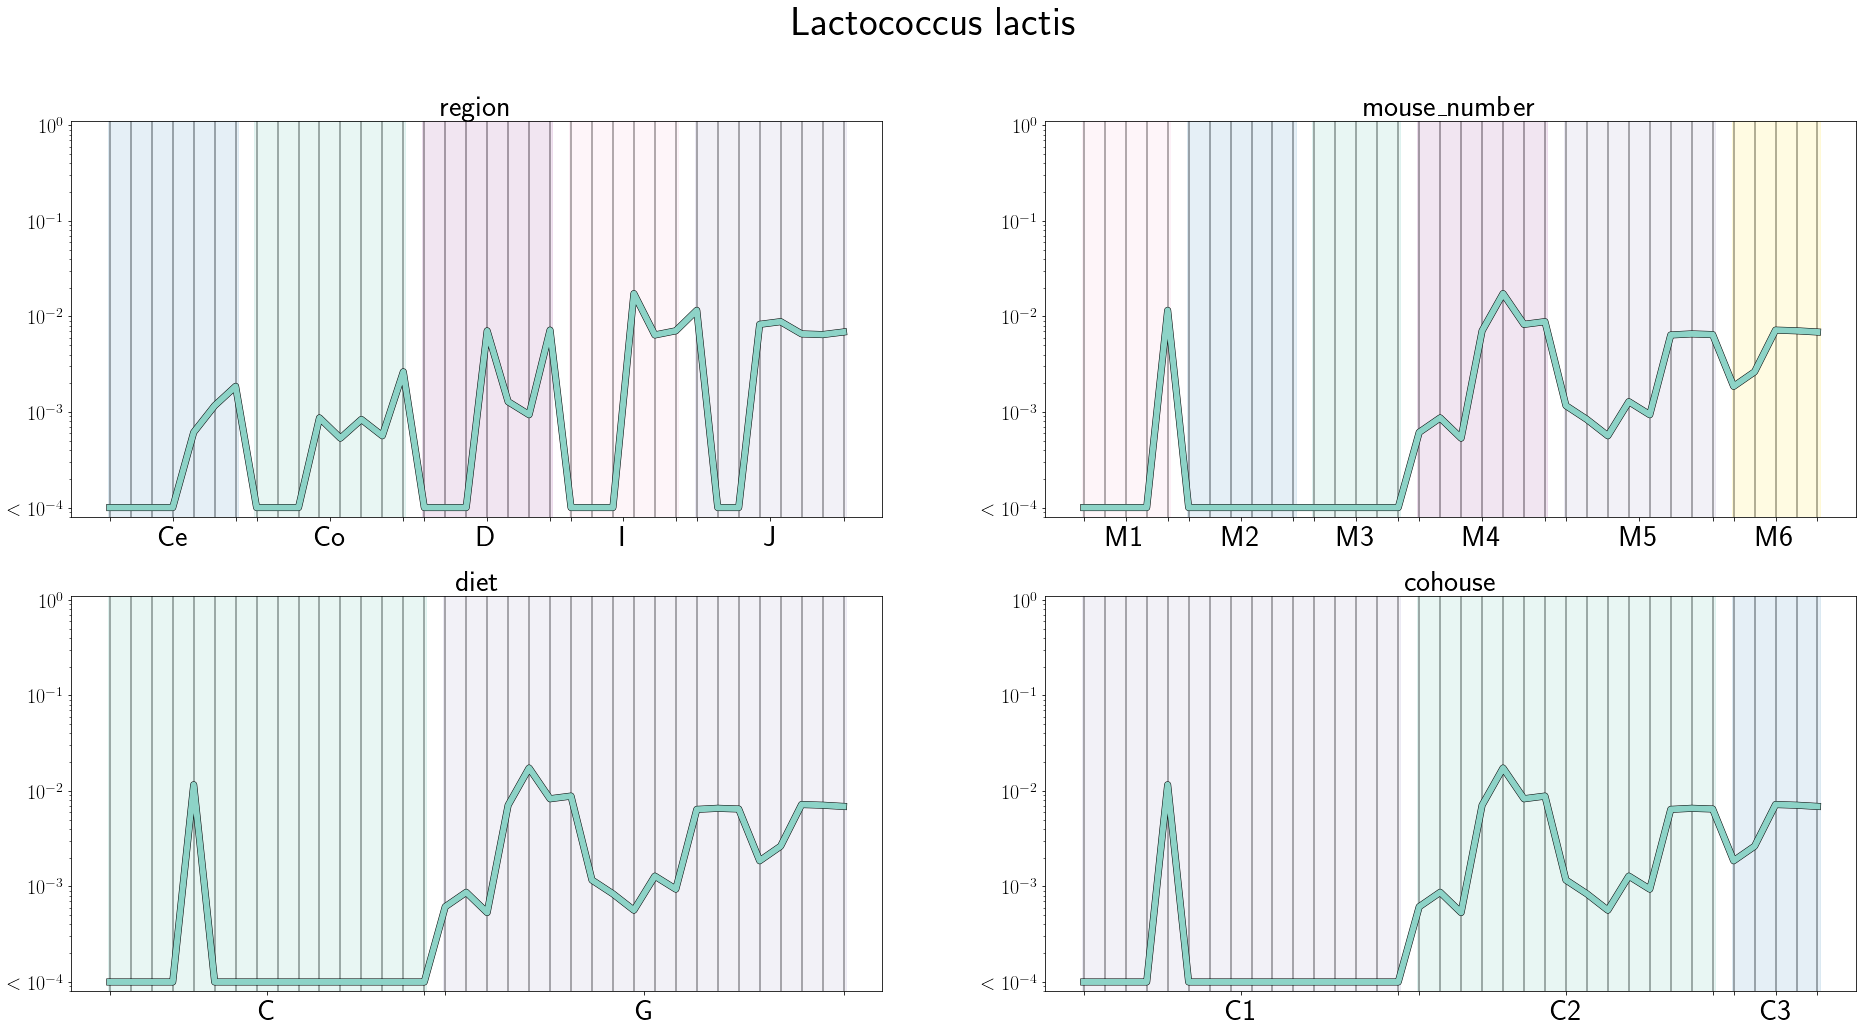

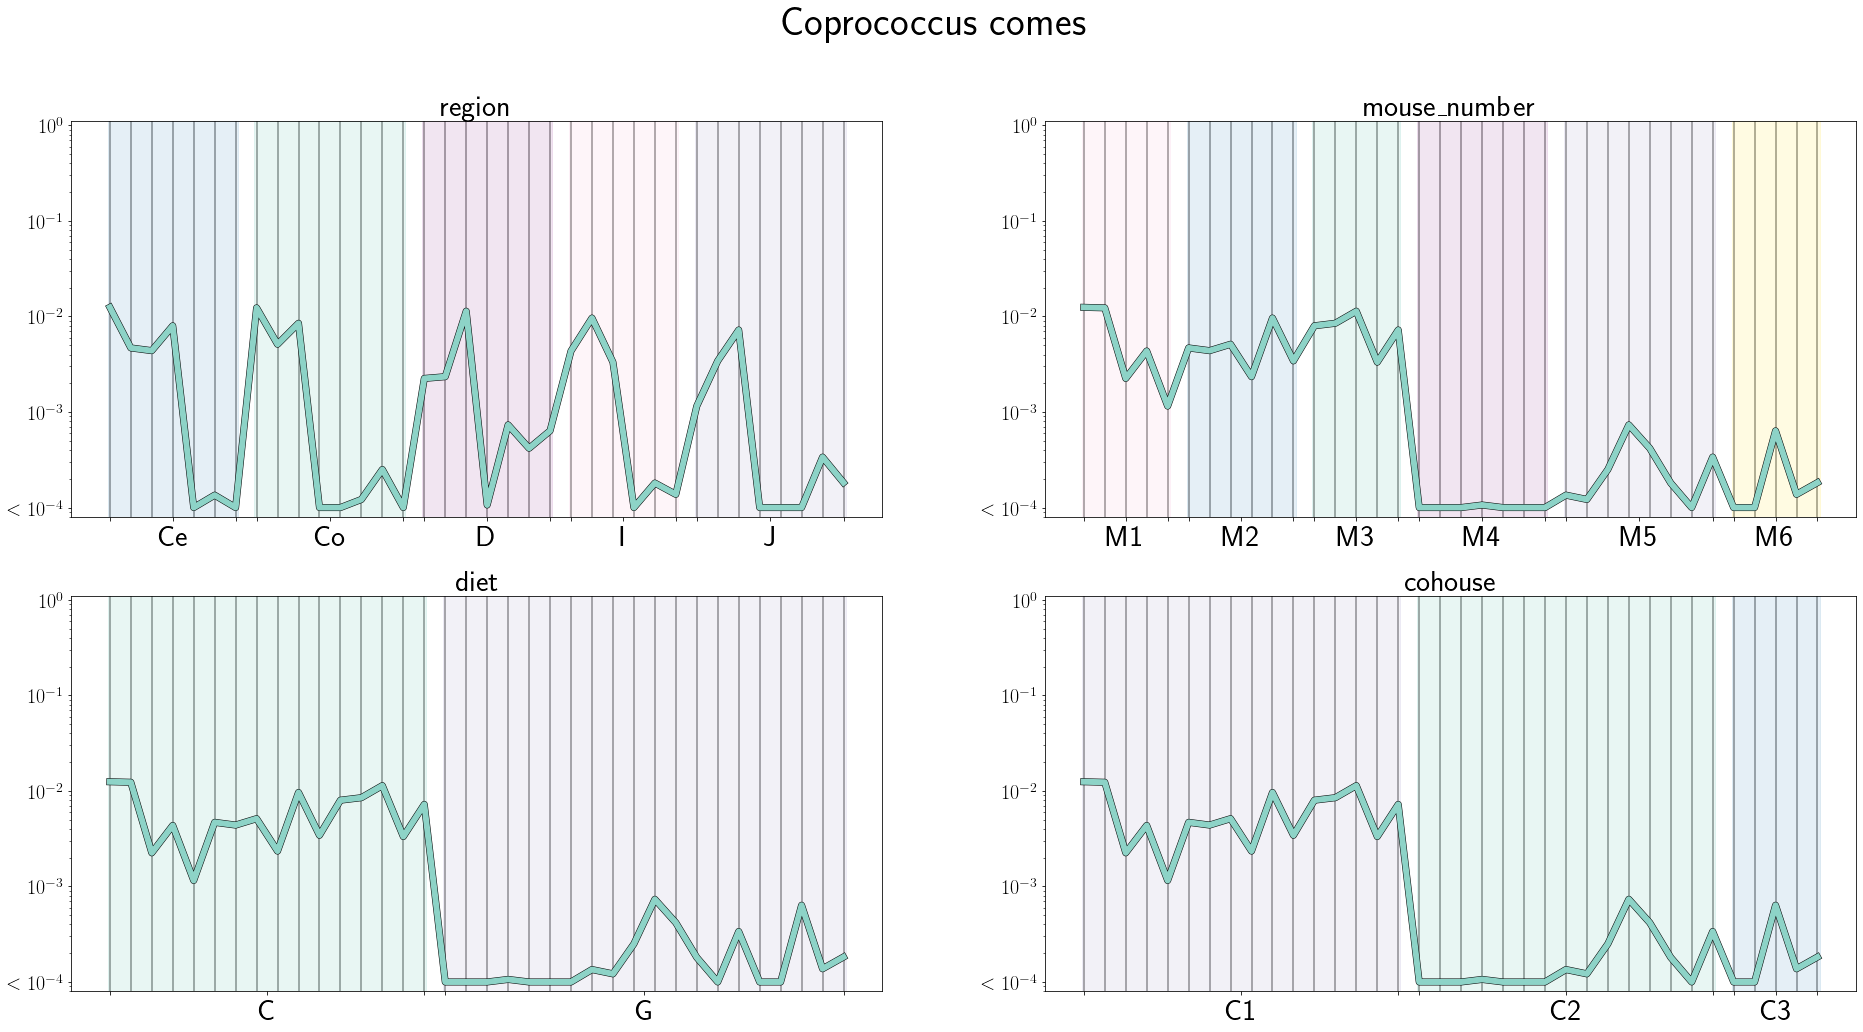

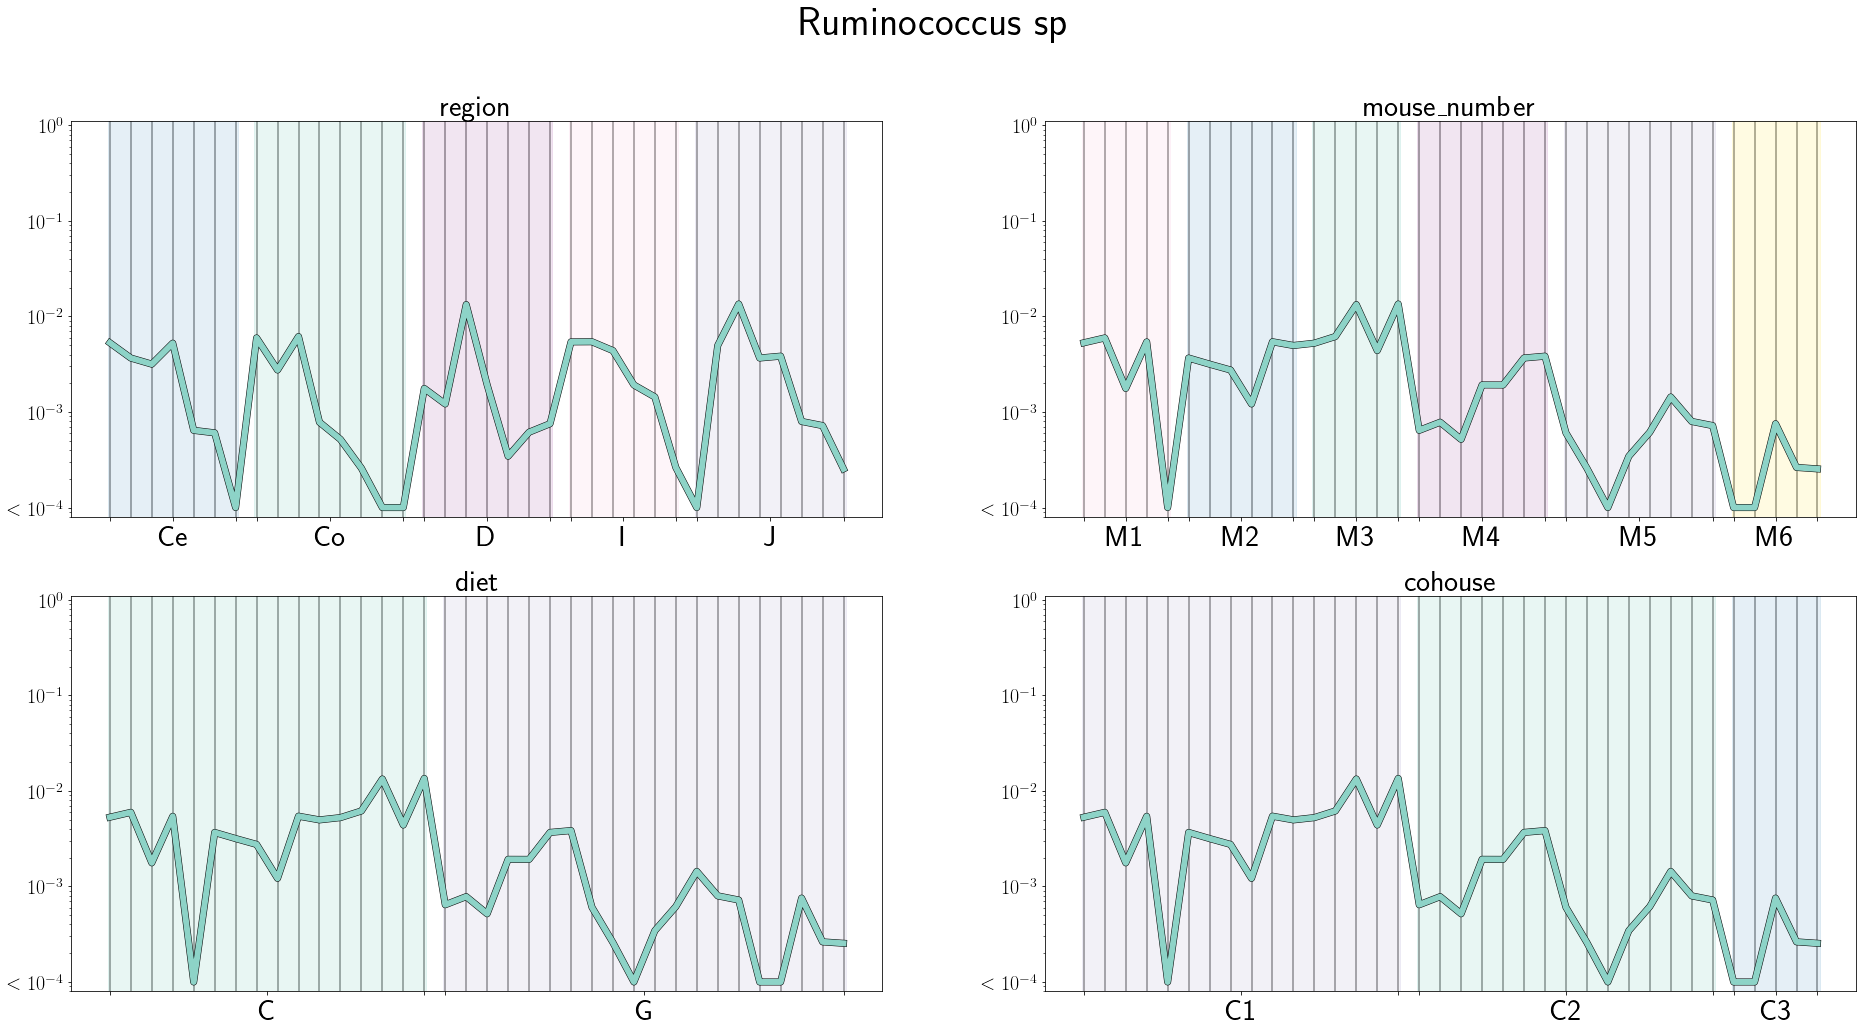

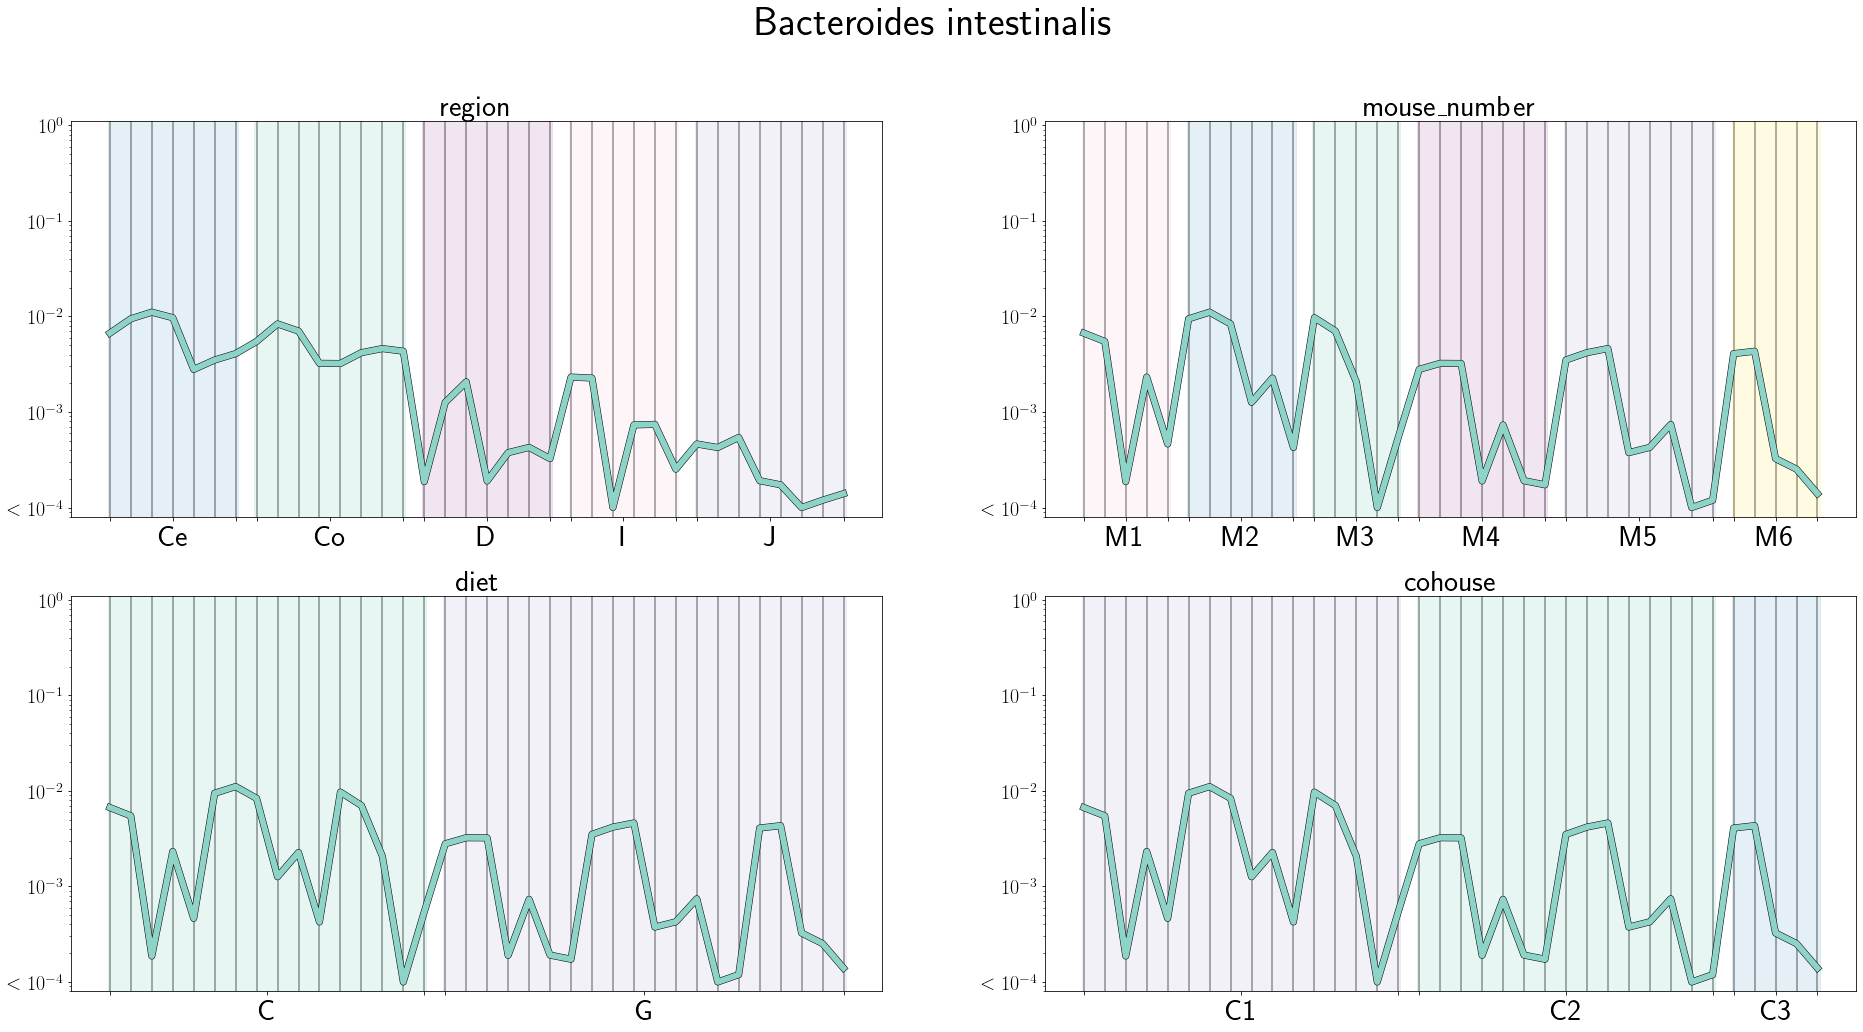

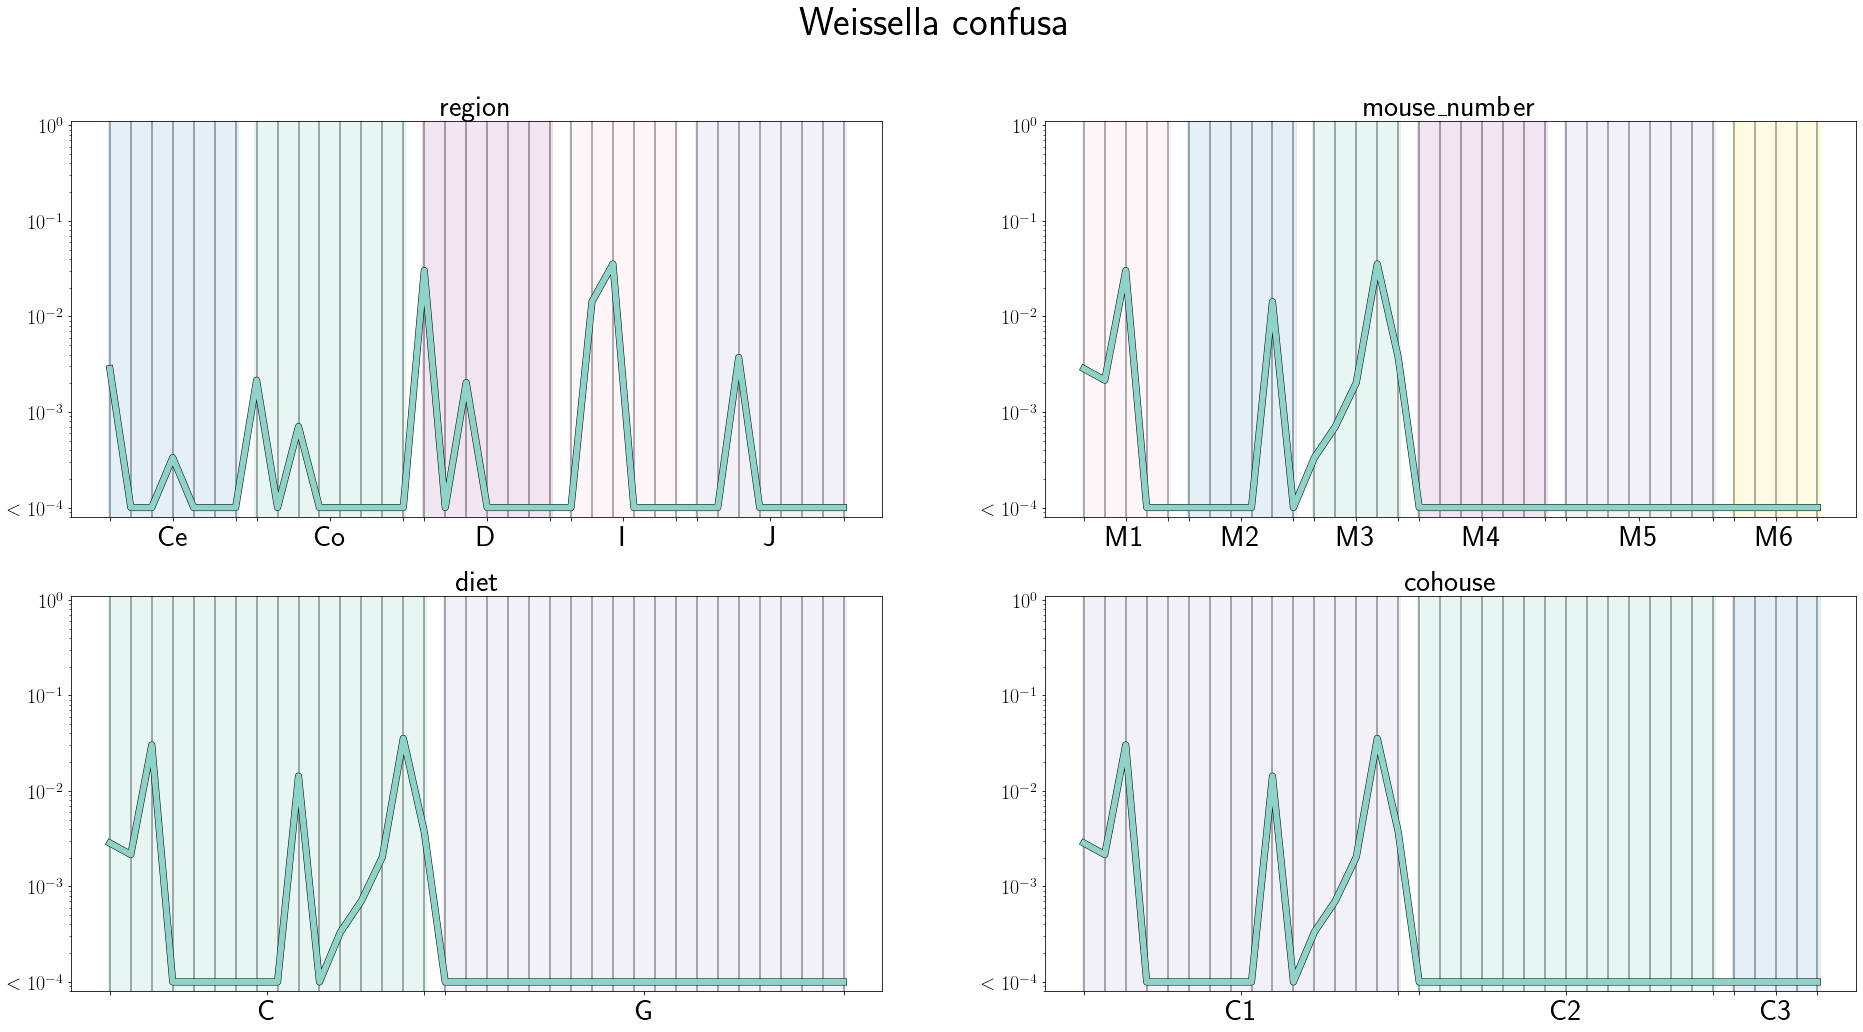

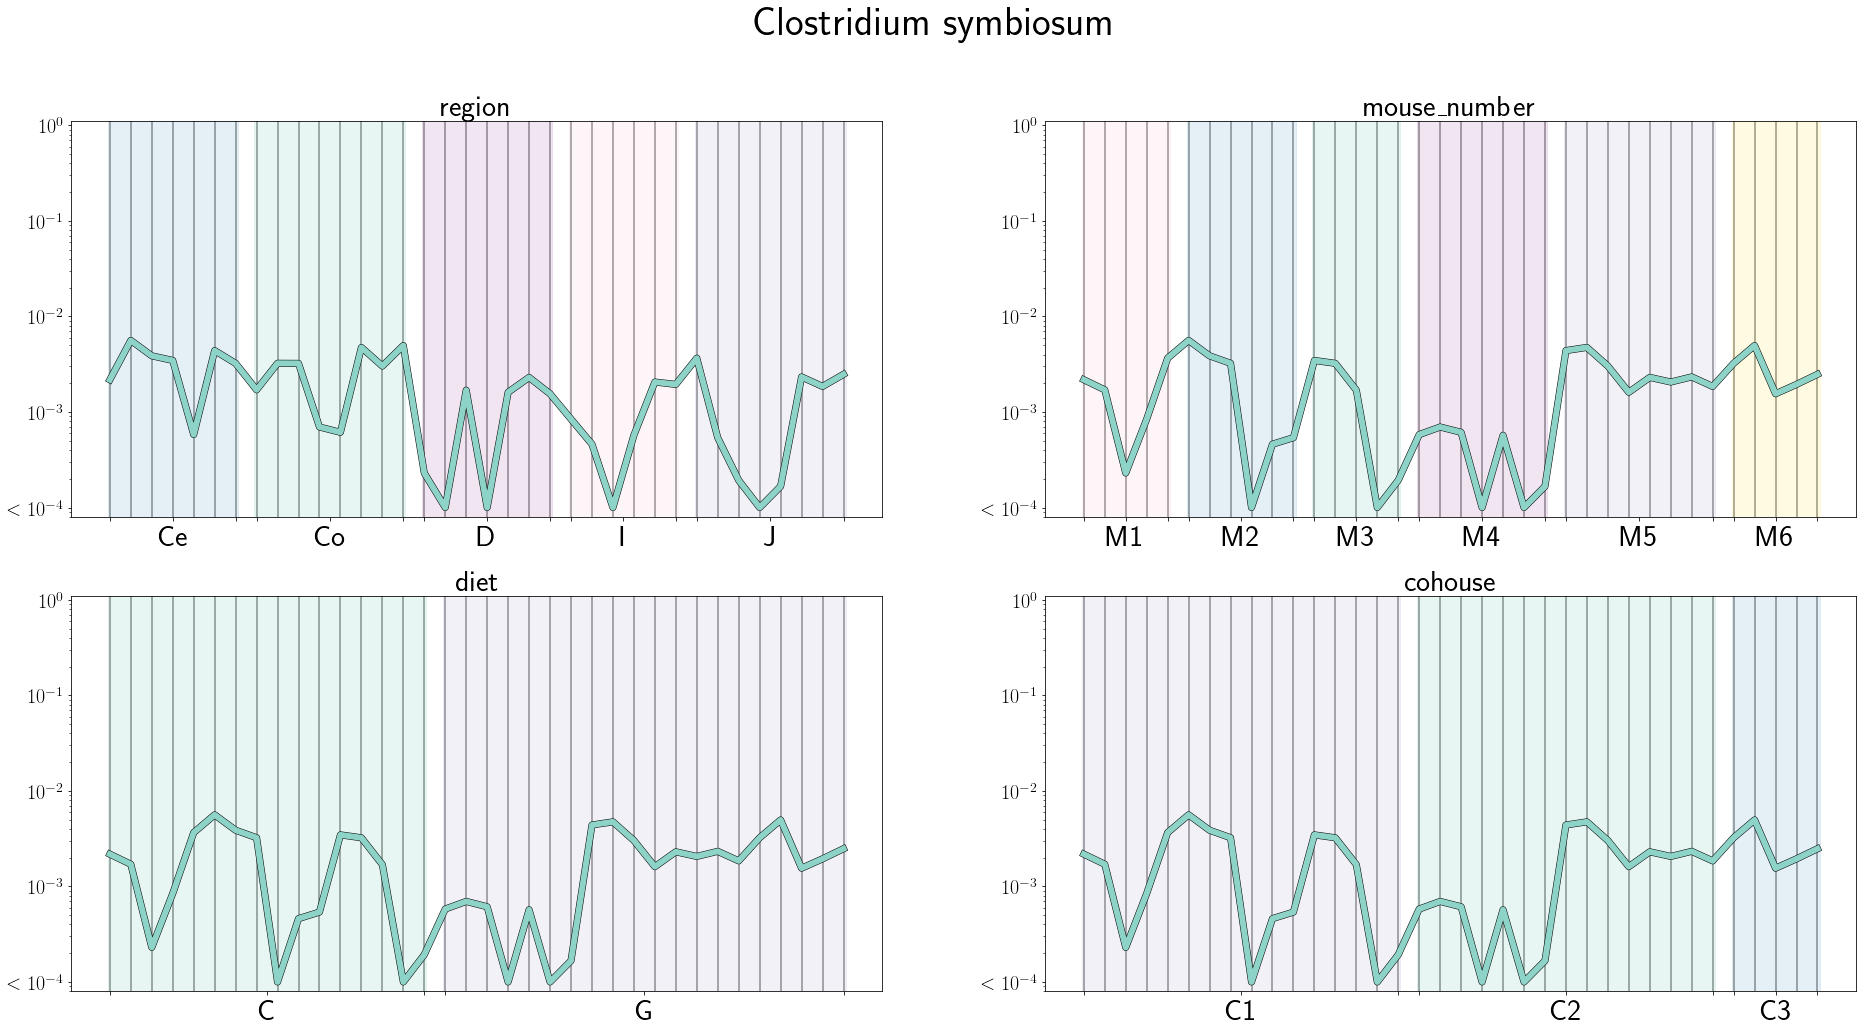

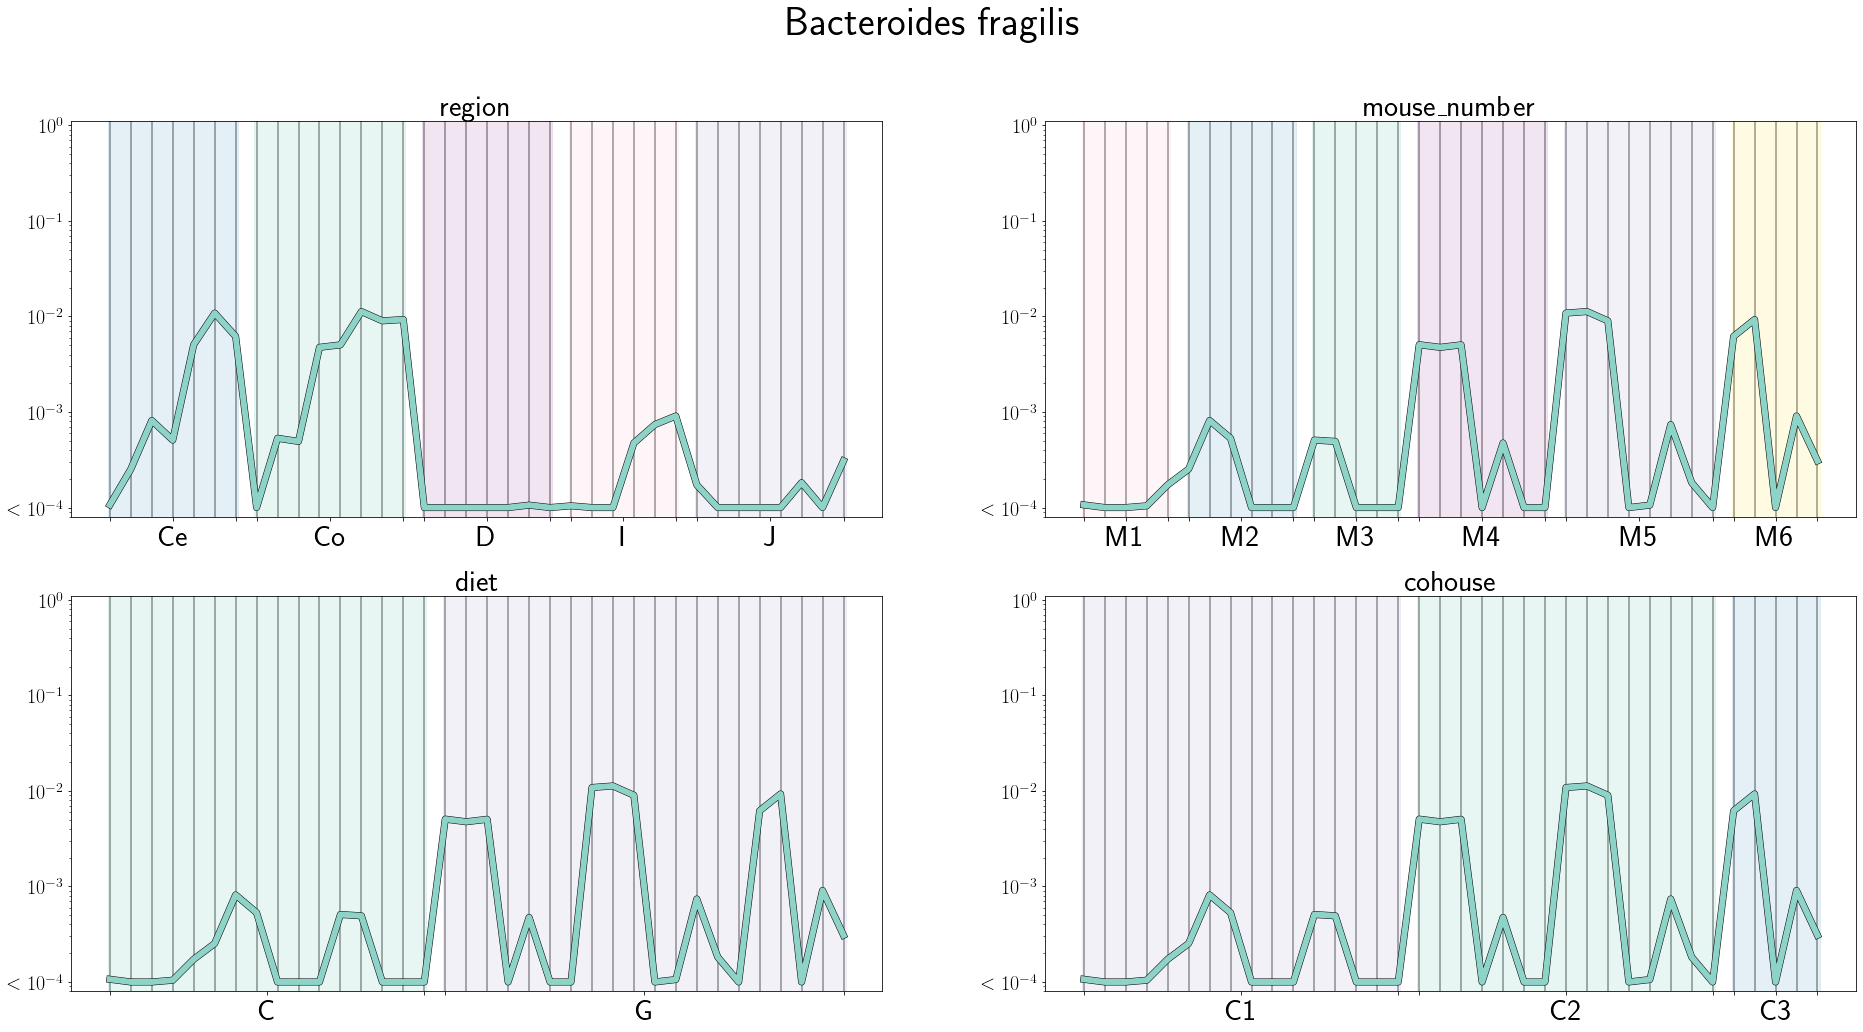

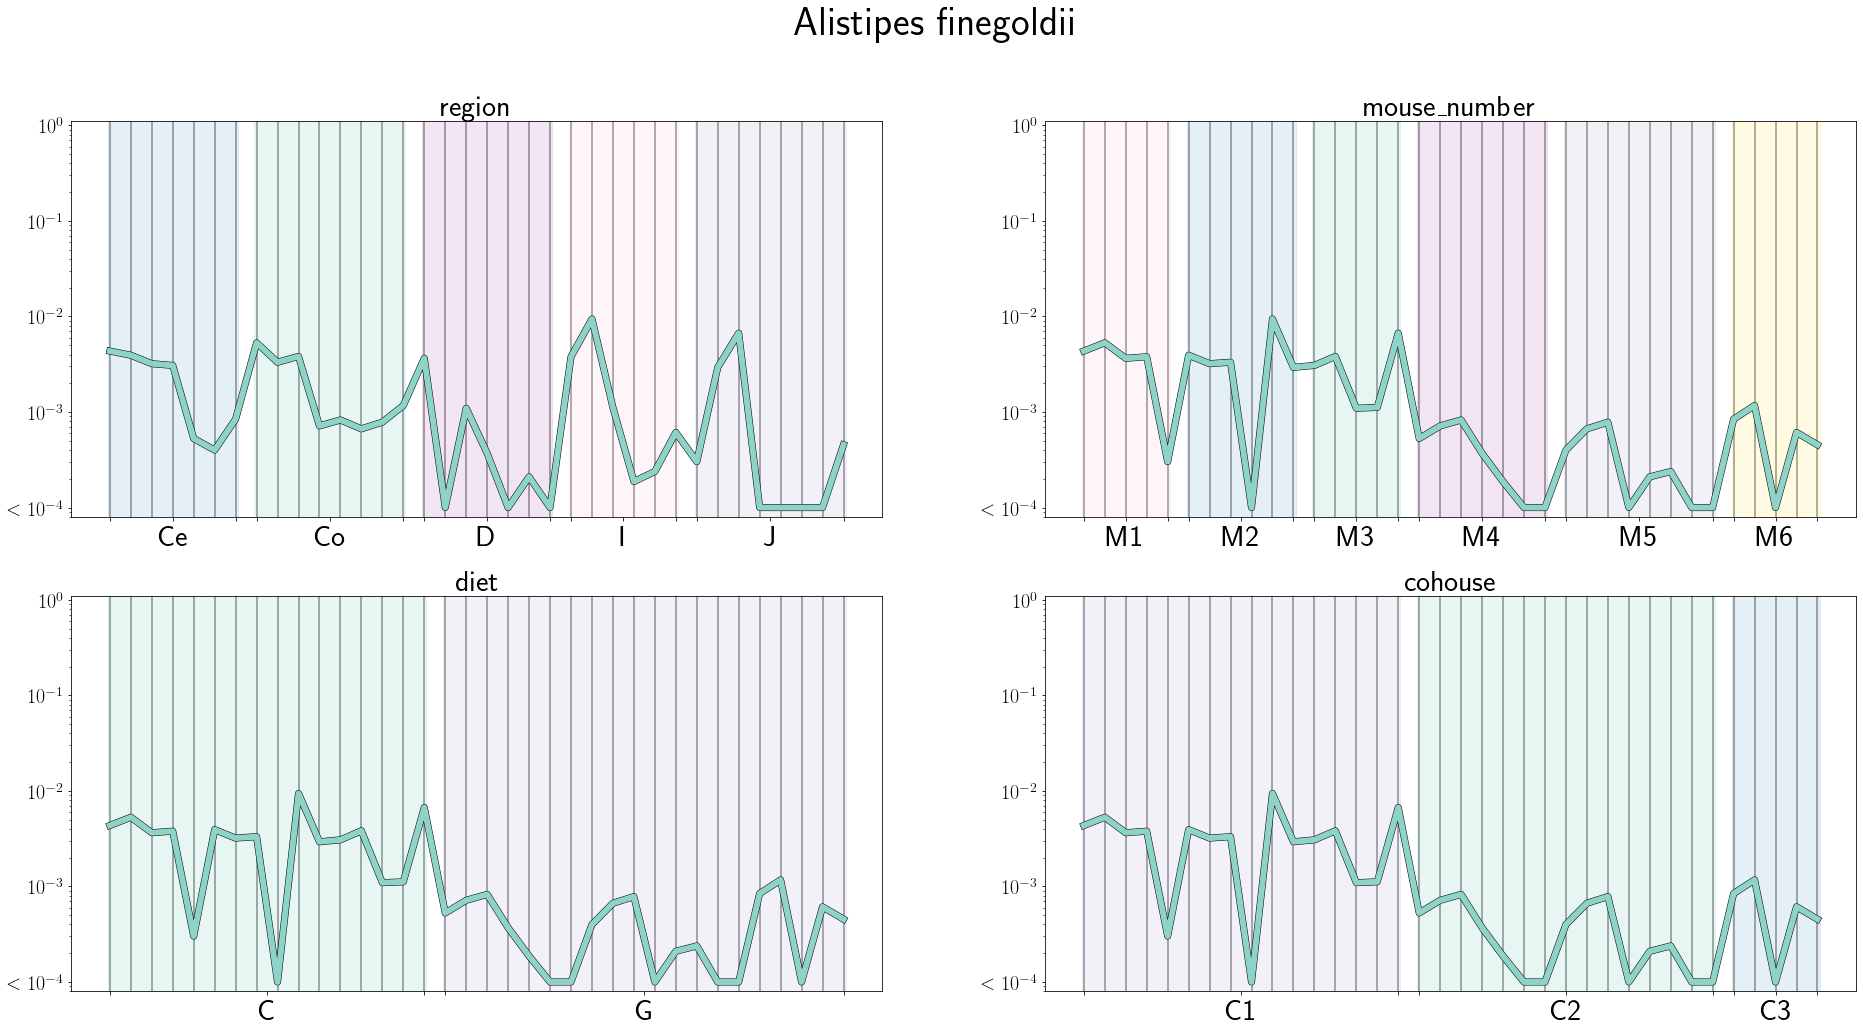

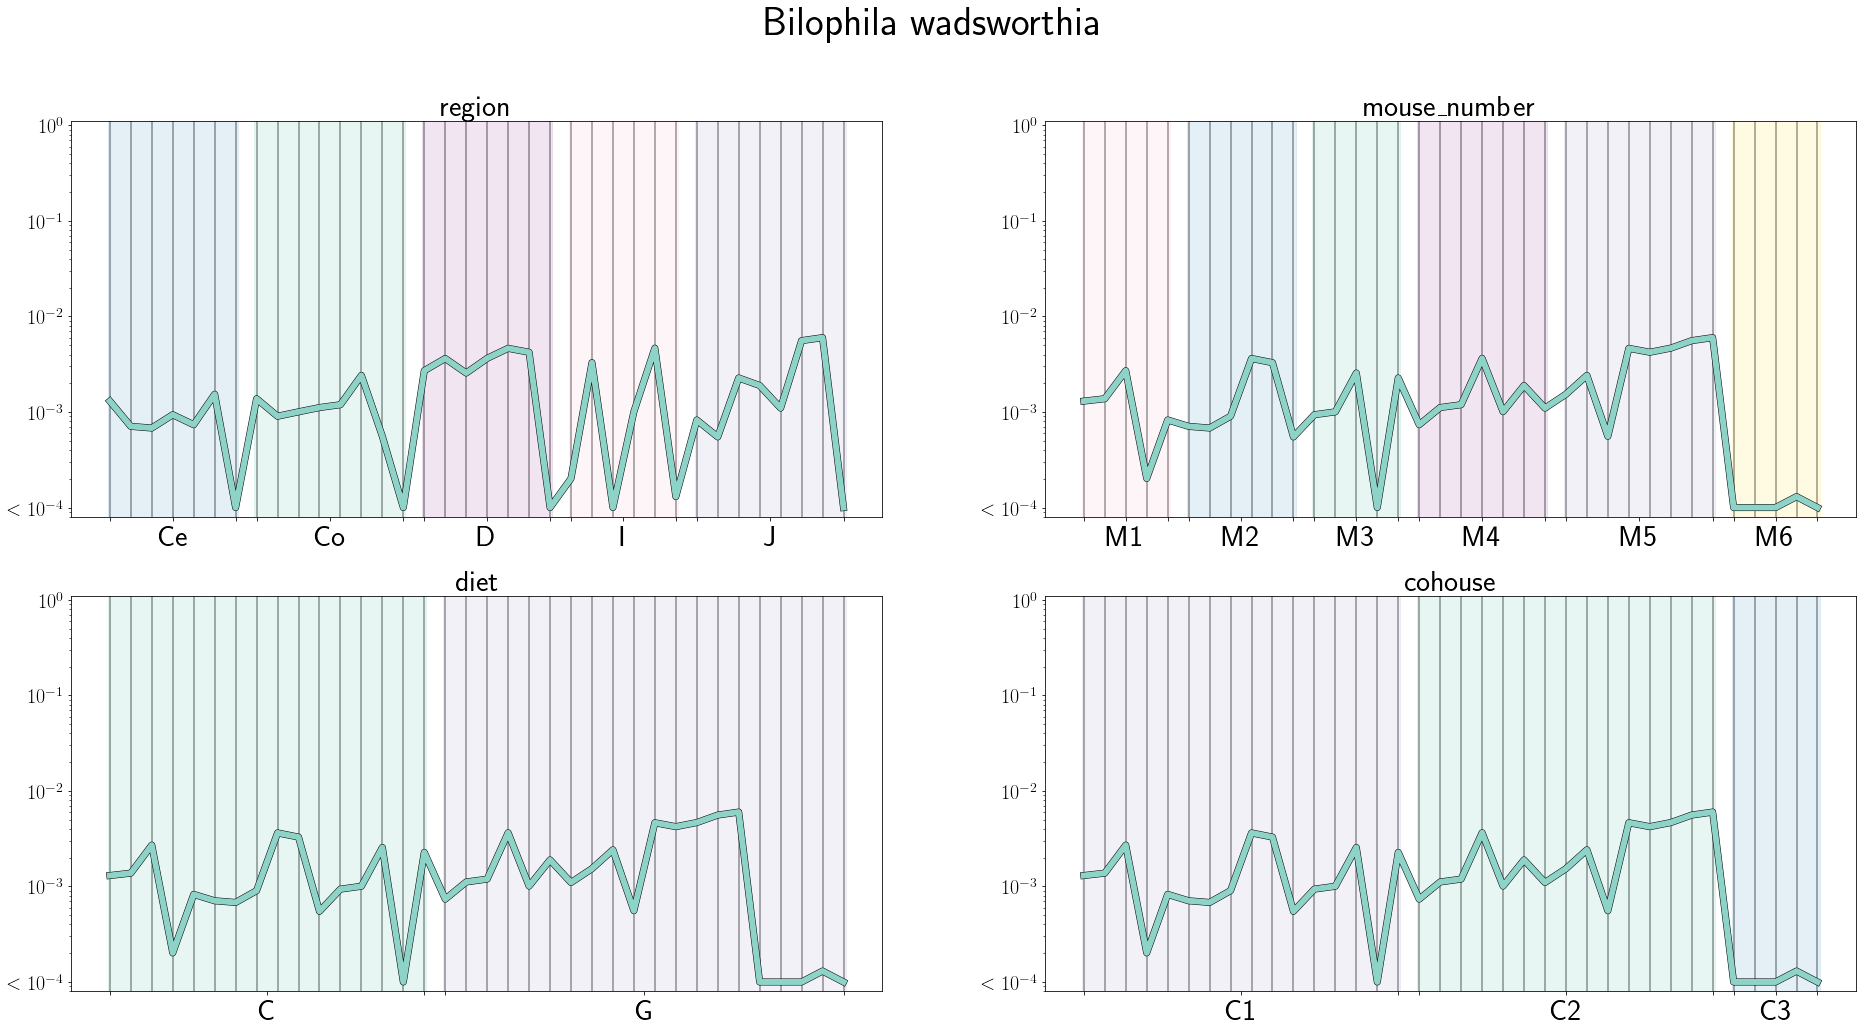

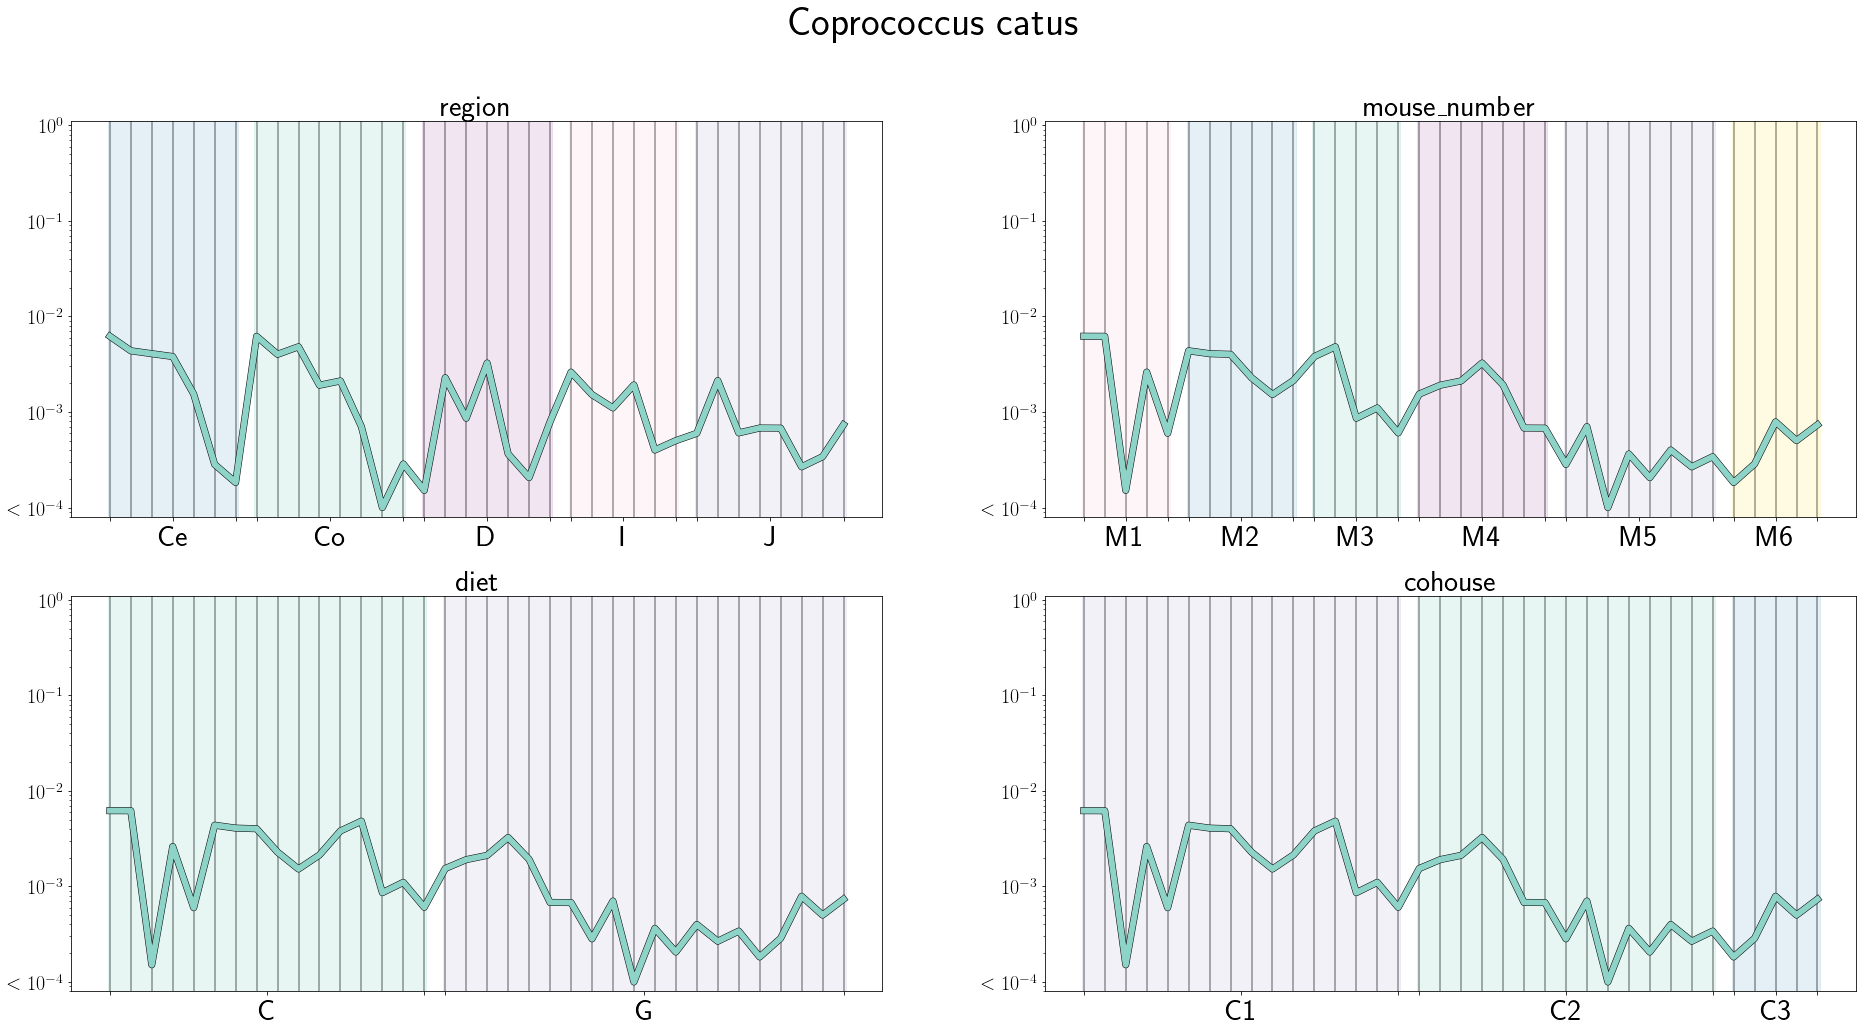

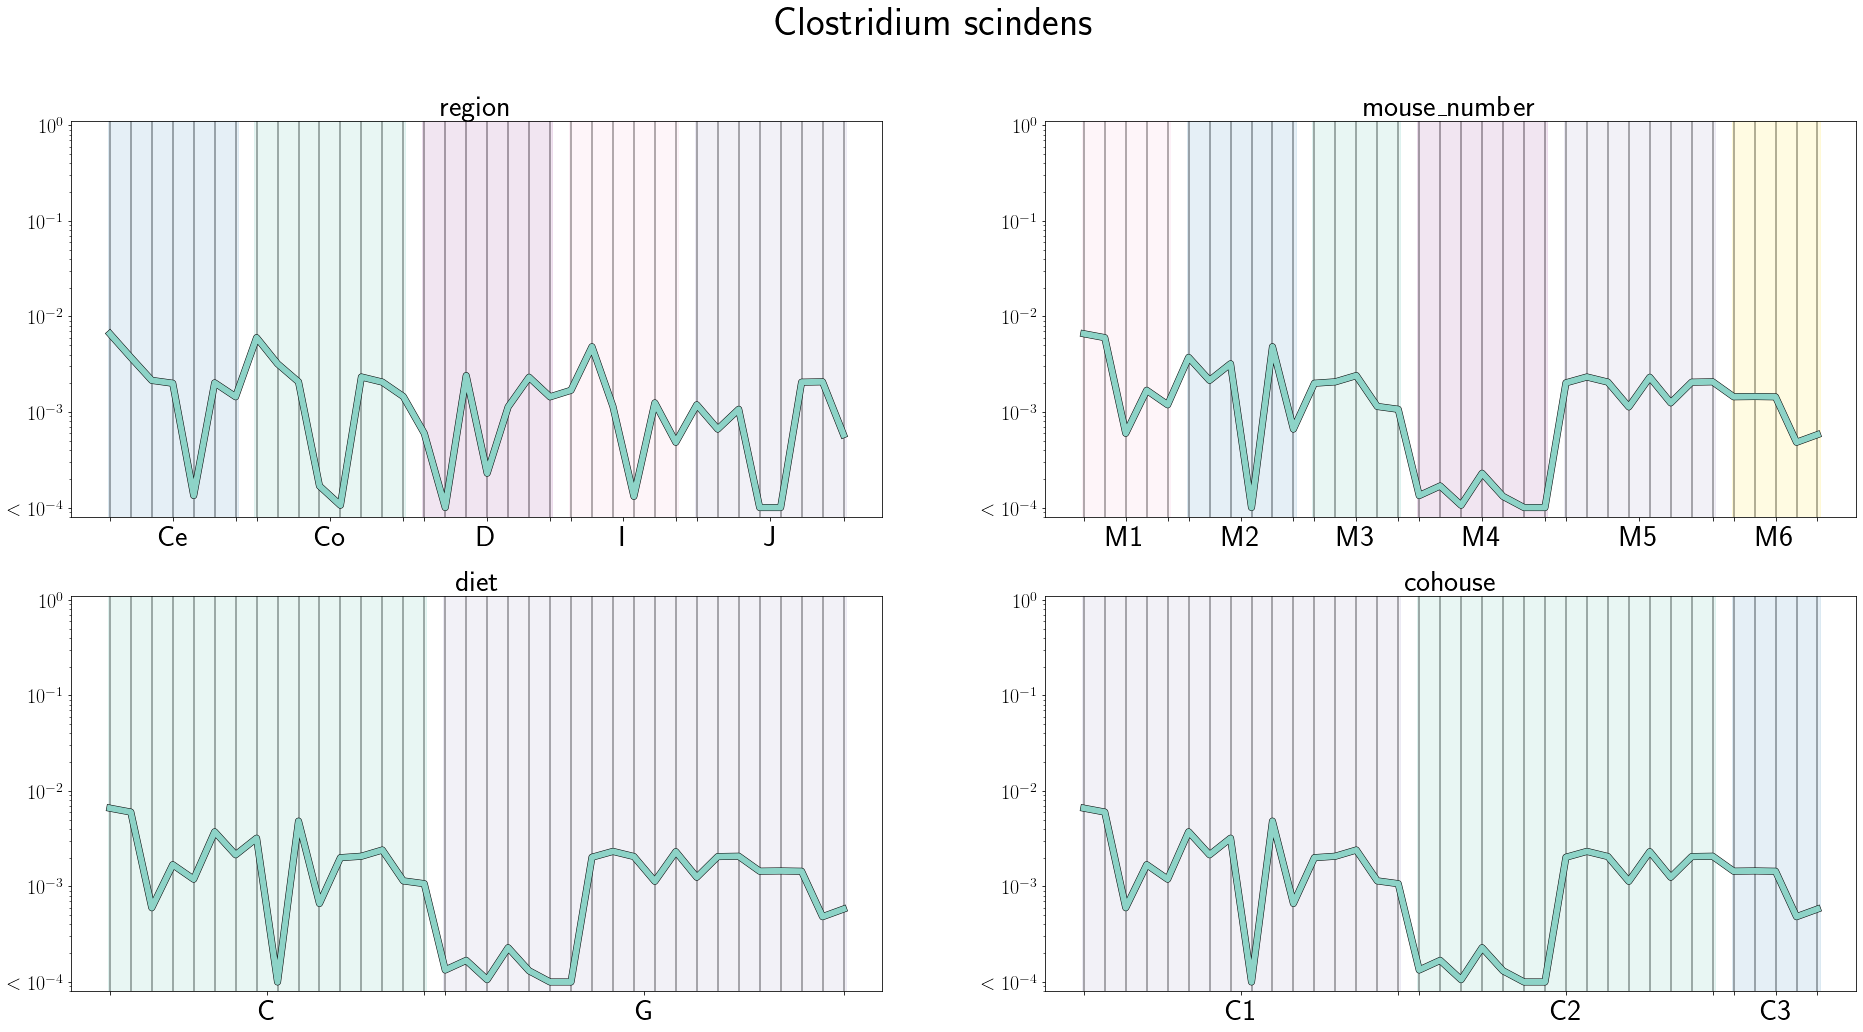

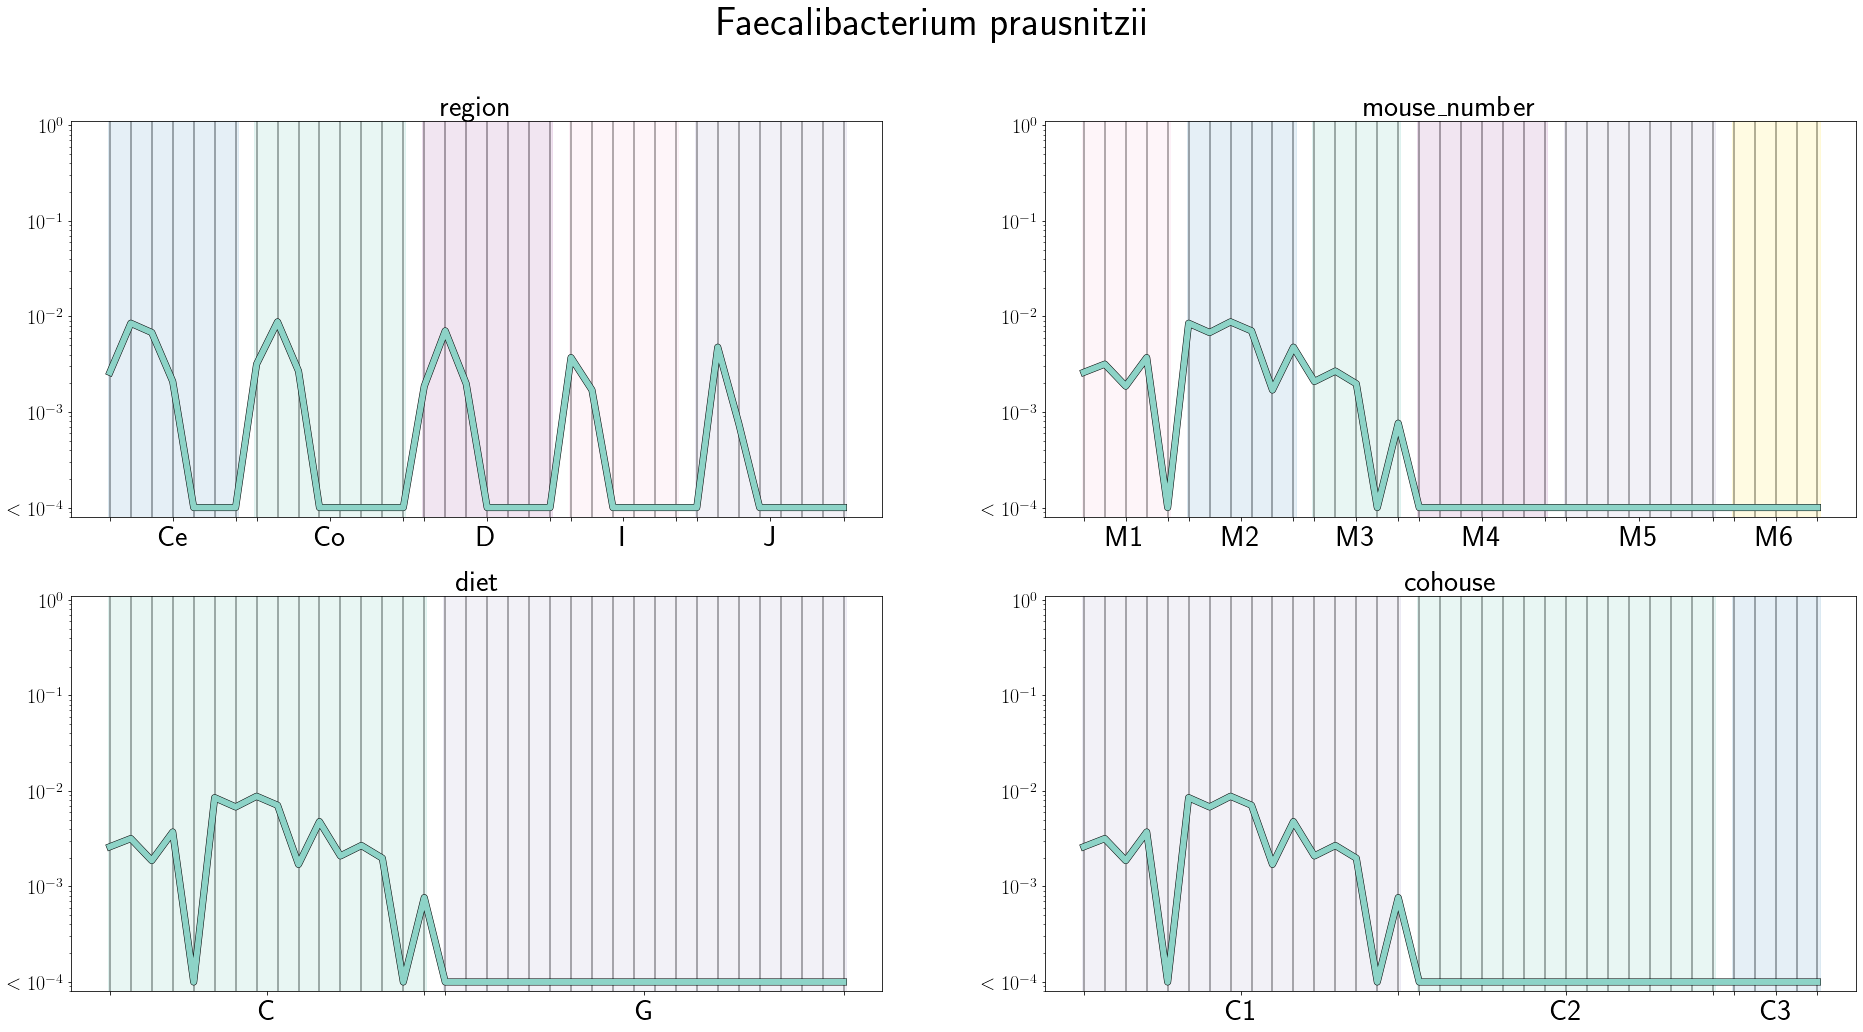

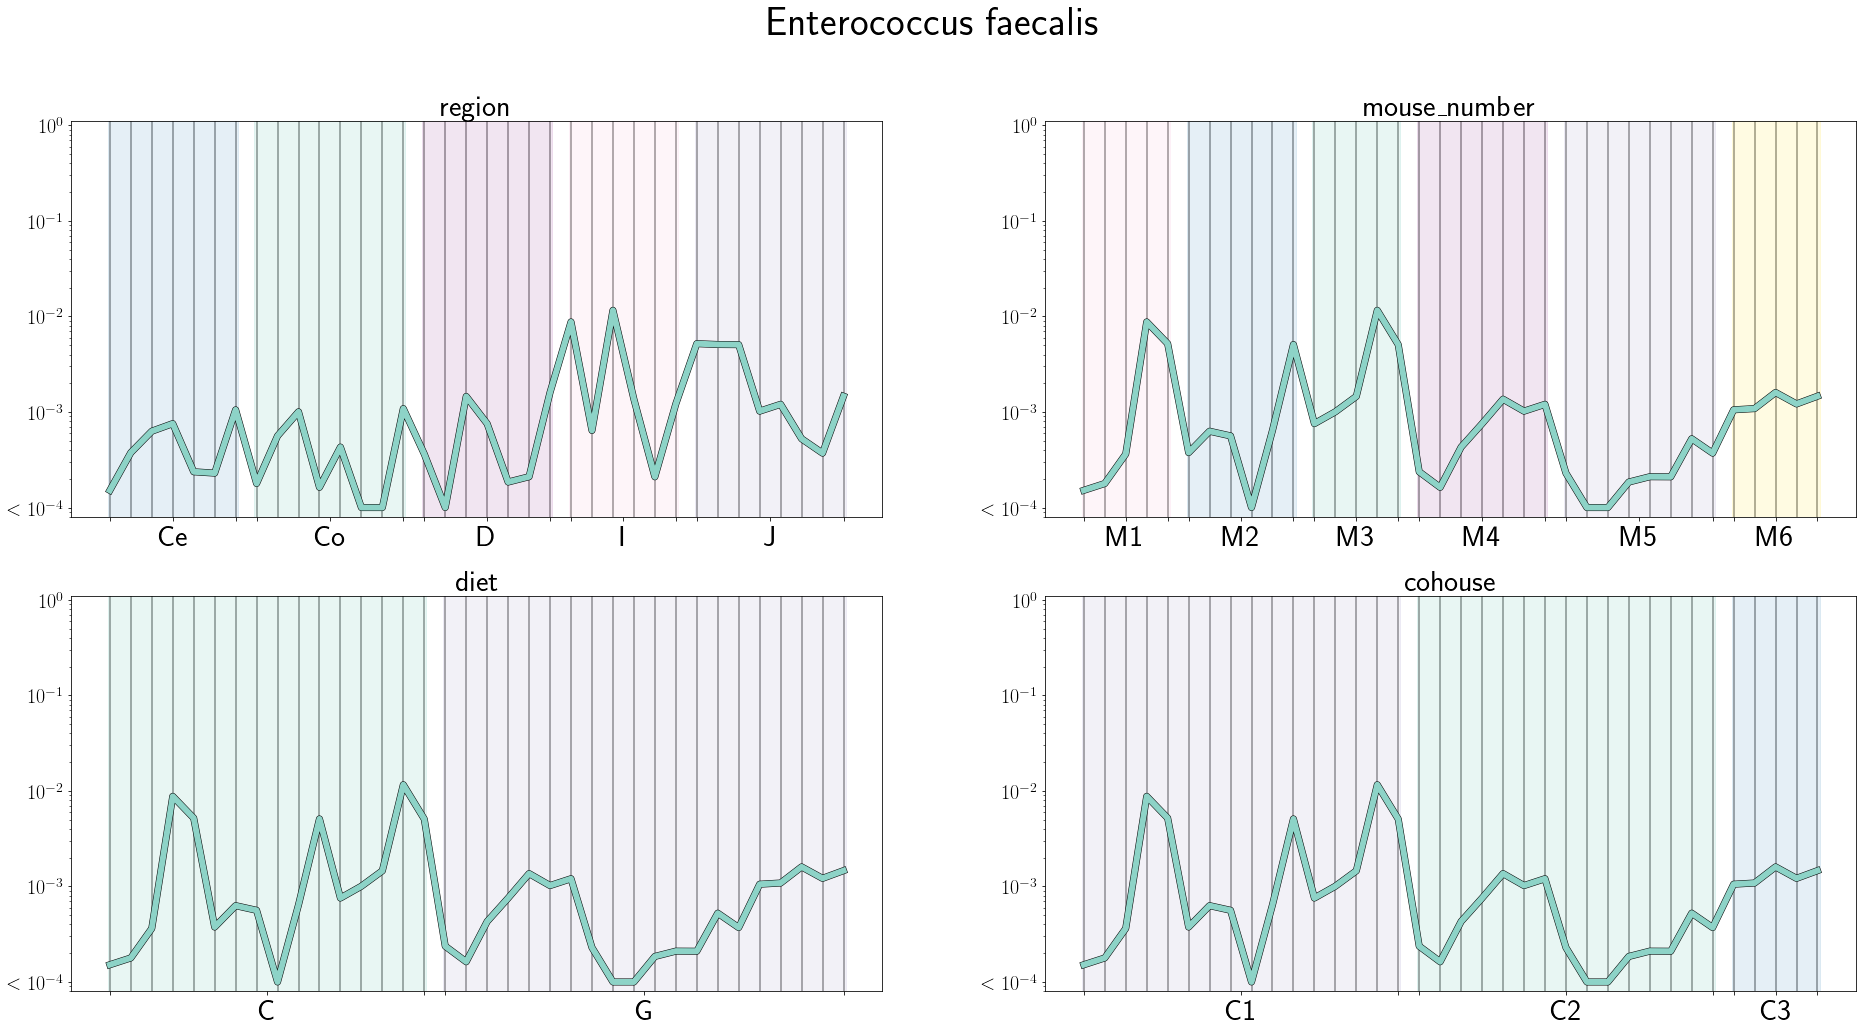

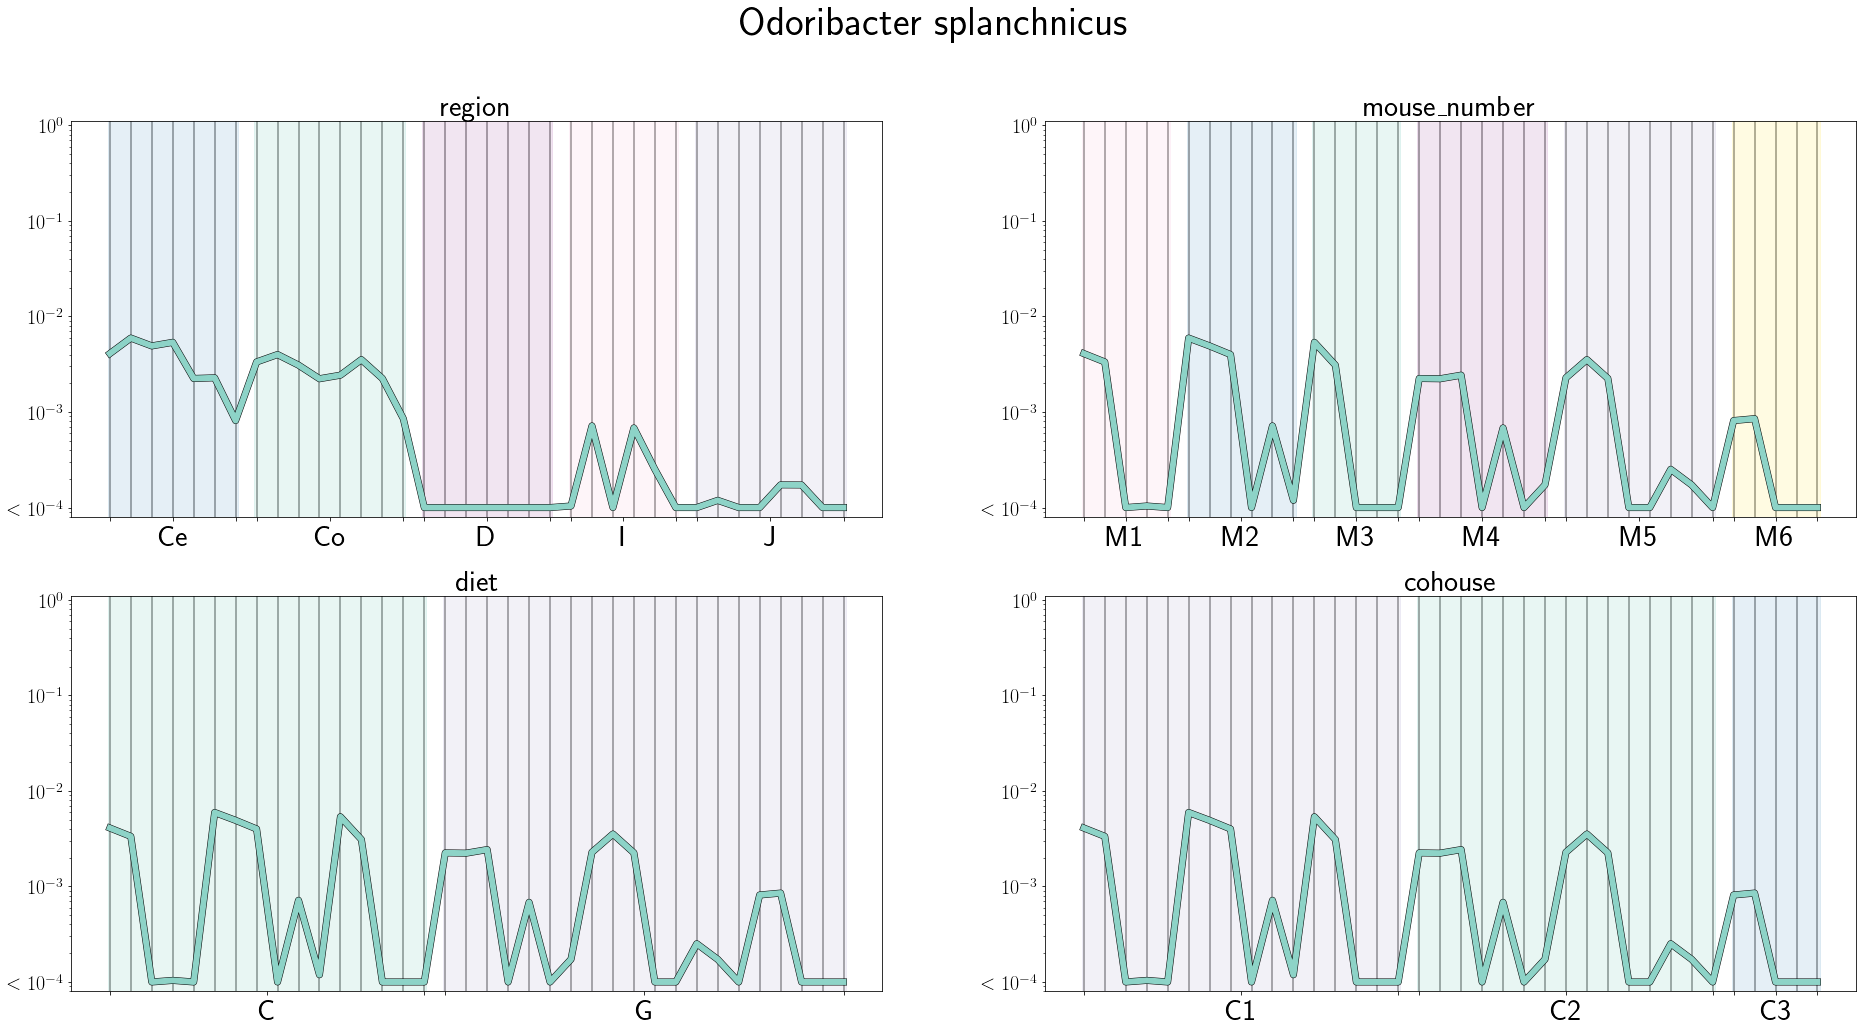

In [61]:
#species = "Ruminococcus_obeum_61472"

for species in df_species.mean().sort_values(ascending=False)[:50].index:

    fig,axs = plt.subplots(2,2,figsize=(32,16))
    fig.suptitle(fu.get_pretty_species_name(species),size=40)

    axs = axs.ravel()

    keys_order = ["region","mouse_number","diet","cohouse"]


    for i,ax in enumerate(axs):

        key_to_sort = keys_order[i]

        ax.set_title(key_to_sort,size=30)

        ax.semilogy()
        ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0],['$<10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$','$10^{0}$'],fontsize=20)
        ax.set_ylim([.8*1e-4,1.1]);

        f = df_species[species]
        f = f.sort_index(level=key_to_sort).values

        f[f < 1e-4] = 1e-4

        i = 0
        ax.plot(f,zorder=100,lw=6,color=cmap(i),);
        ax.plot(f,zorder=80,lw=7,color="k");

        major_x = []
        minor_x = []
        labels = []

        i = 0

        for key, item in all_sample_dics[key_to_sort].items():

            xmin = item.min() 
            xmax = item.max()

            ax.axvspan(xmin - .1,xmax+.1,alpha=.2,color=cmap(i))

            for e in item:
                ax.axvline(e,color="k",zorder=0,alpha=.5)

            if xmin != xmax:
                major_x.extend([xmin,(xmax + xmin)/2,xmax])
                minor_x.append((xmax + xmin)/2)
                labels.extend(["",key,""])
            else:
                major_x.append(xmin)
                minor_x.append(xmax)
                labels.extend([key])        
            i+=1

        ax.set_xticks(major_x)
        ax.set_xticks(minor_x, minor = True)

        ax.set_xticklabels(labels,fontsize=30);
    
    fig.savefig(f"figures/species/{species}")


In [6]:
df_species = pd.read_csv(f"/u/project/ngarud/Garud_lab/HumanizedMouse/merged_midas_output/species/coverage.txt.bz2",sep="\t",index_col=0)


In [8]:
mnum = [f[:2] for f in df_species.columns]
msite = [f[2:].split("_")[0][:-1] for f in df_species.columns]
mdiet = [f[2:].split("_")[0][-1] for f in df_species.columns]
mhouse = []
for m in mnum:
    if m == "M1" or m == "M2" or m == "M3":
        mhouse.append("C1")
    elif m == "M4" or m =="M5":
        mhouse.append("C2")
    else:
        mhouse.append("C3")
    
df_species = df_species.T
df_species["mouse_number"] = mnum
df_species.set_index('mouse_number', append=True, inplace=True)
df_species["region"] = msite
df_species.set_index('region', append=True, inplace=True)
df_species["diet"] = mdiet
df_species.set_index('diet', append=True, inplace=True)
df_species["cohouse"] = mhouse
df_species.set_index('cohouse', append=True, inplace=True)

df_species.index.names = ["sample","mouse_number","region","diet","cohouse"]
df_species = df_species.reorder_levels(["cohouse","mouse_number","region","diet","sample"])
df_species = df_species.sort_index(level="mouse_number")


In [18]:
df_species.groupby("region").mean()["Blautia_producta_56315"]

region
Ce     41.672130
Co     35.560470
D      27.518110
I     146.894547
J     124.723820
Name: Blautia_producta_56315, dtype: float64

In [17]:
df_species.groupby("region").mean().loc["D"].sort_values()

species_id
Yaniella_halotolerans_59132           0.000000
Cecembia_lonarensis_59611             0.000000
Cloacamonas_acidaminovorans_61555     0.000000
Anaerococcus_senegalensis_58365       0.000000
Prevotella_veroralis_57831            0.000000
                                       ...    
Roseburia_intestinalis_56239          9.821863
Burkholderiales_bacterium_56577      11.967259
Blautia_producta_56315               27.518110
Akkermansia_muciniphila_55290        36.639359
Lactobacillus_acidophilus_51143      47.593796
Name: D, Length: 5952, dtype: float64